In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from baynes.model_utils import inits_from_priors
from baynes.plotter import FitPlotter
from baynes.toyMC import SpectraSampler
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import json
import pandas as pd
plt.style.use('default')
import numbers
from multiprocessing.dummy import Pool as ThreadPool
import pickle

In [4]:
def lorentzian(E, E0, gamma):
    gamma_2 = gamma / 2
    return 1/np.pi * gamma_2 / ((E - E0) ** 2+gamma_2 ** 2)


def HoSpectrum(E,  m_nu,
                         Q_H=2838,
                         E_H=[2047, 1842, 414.2, 333.5, 49.9, 26.3],
                         gamma_H=[13.2, 6.0, 5.4, 5.3, 3.0, 3.0],
                         i_H=[1, 0.0526, 0.2329, 0.0119, 0.0345, 0.0015]):
    if isinstance(E, numbers.Number):
        spectrum =  np.array([0.])
    else:
        spectrum = np.zeros(len(E))
    for i in range(len(E_H)):
        spectrum += i_H[i]*lorentzian(E, E_H[i], gamma_H[i])
    return np.clip((Q_H - E), 0, None)*np.sqrt(np.clip((Q_H - E)**2 - m_nu**2, 0, None)) * spectrum


def hdi(samples, prob=0.95):
    n = len(samples)
    sorted_samples = np.sort(samples)
    interval_len = int(np.floor(prob * n))
    n_intervals = n - interval_len
    interval_widths = np.subtract(sorted_samples[interval_len:], sorted_samples[:n_intervals])

    min_idx = np.argmin(interval_widths)
    hdi_interval = sorted_samples[[min_idx, min_idx + interval_len]]

    return hdi_interval

In [28]:
stan_file= "Ho_spectrum.stan"
model = CmdStanModel(stan_file=stan_file,
                     cpp_options={"STAN_THREADS": True,"jN":16})

20:51:03 - cmdstanpy - INFO - compiling stan file /home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan to exe file /home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum
20:51:20 - cmdstanpy - INFO - compiled model executable: /home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum


In [5]:
stan_file= "Ho_sigma.stan"
model_sigma = CmdStanModel(stan_file=stan_file,
                     cpp_options={"STAN_THREADS": True,"jN":16})

Number of events in ROI:  2754
[0.95002736 0.04997264]


2.1233045007200477

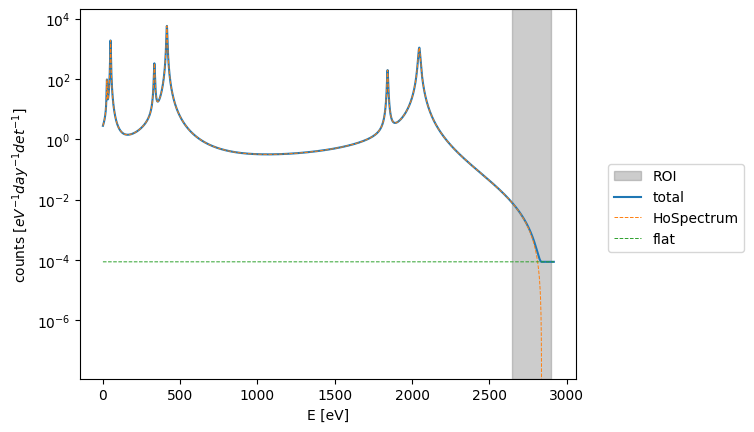

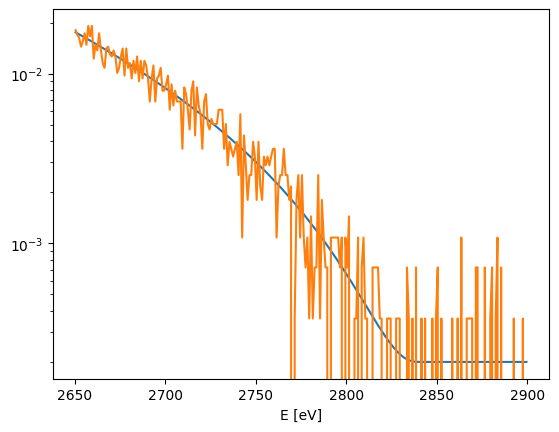

In [9]:
FWHM=5
m = 0
bkg = 1e-4
n_days = 100
A_Ho = 1

s = SpectraSampler([(HoSpectrum, [m, 2838], A_Ho)], flat_bkg=0, FWHM=FWHM)
s.flat_bkg=sum(s.spectrum['HoSpectrum'][s.ROI_idx[0]:s.ROI_idx[1]])*(0.05/(1-0.05))/len(s.ROI_bin_centers)
s.update_spectrum()

s.plot_spectrum()
s.set_measure_time(n_days, n_det=64)

true_weights = s.weights_in_ROI
print(true_weights)

x = s.bin_edges[s.ROI_idx[0]:s.ROI_idx[1]+1]
events = s.sample()[0]
ax = s.plot_pdf()
ax.plot(s.ROI_bin_centers, events/np.sum(events))

n_window = 51

data={'N_bins': len(x)-1, 
      'N_window': n_window,
      'x': x, 
      'counts': events,
      'N_ev': s.n_events,
      'p_Q': 2838,
      'p_FWHM': FWHM,
      'prior': 0,
}
s.sigma

17:50:45 - cmdstanpy - INFO - CmdStan start processing
17:50:45 - cmdstanpy - INFO - CmdStan start processing


Constructing prior predictive check


17:50:45 - cmdstanpy - INFO - CmdStan done processing
17:50:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_rng: Rate parameter[1] is -nan, but must be positive! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 58, column 2 to column 123)
	Exception: poisson_rng: Rate parameter[1] is -nan, but must be positive! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 58, column 2 to column 123)
	Exception: poisson_rng: Rate parameter[1] is -nan, but must be positive! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 58, column 2 to column 123)
	Exception: poisson_rng: Rate parameter[1] is -nan, but must be positive! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 58, column 2 to column 123)
	Exception: poisson_rng: Rate parameter[1] is -nan, but must be positive! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_

/home/pcampana/baynes/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:257: RuntimeWarning: invalid value encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),
/home/pcampana/baynes/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:257: RuntimeWarning: divide by zero encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),


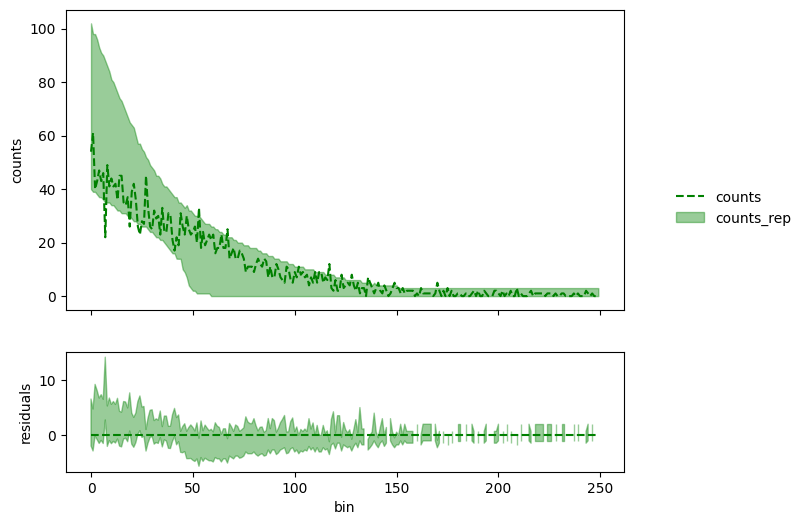

17:50:46 - cmdstanpy - INFO - CmdStan start processing


Fitting the model


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:51:09 - cmdstanpy - INFO - CmdStan done processing.
17:51:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/hol


Processing csv files: /tmp/tmp0qx2_dfe/Ho_spectrum83iqvf_d/Ho_spectrum-20230613175046_1.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp0qx2_dfe/Ho_spectrum83iqvf_d/Ho_spectrum-20230613175046_2.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp0qx2_dfe/Ho_spectrum83iqvf_d/Ho_spectrum-20230613175046_3.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp0qx2_dfe/Ho_spectrum83iqvf_d/Ho_spectrum-20230613175046_4.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



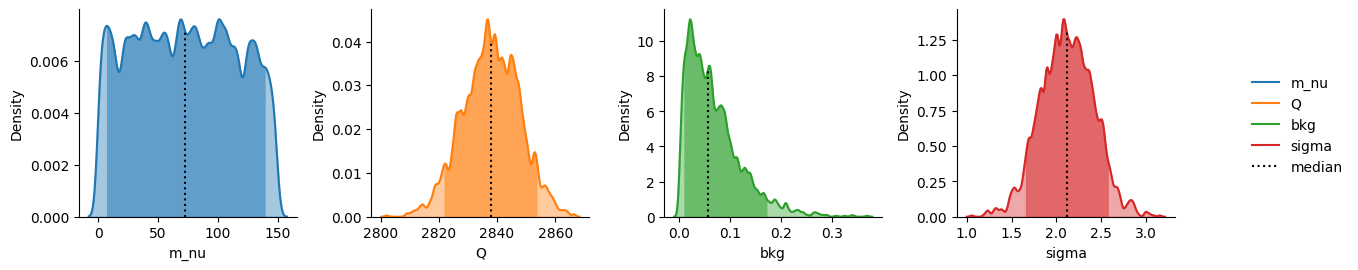

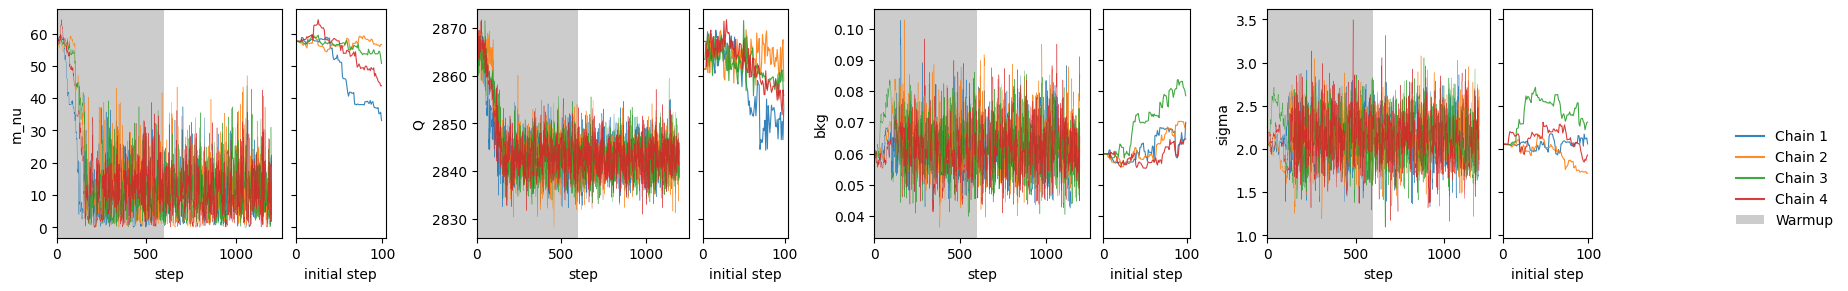

/home/pcampana/baynes/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:257: RuntimeWarning: divide by zero encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),
/home/pcampana/baynes/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:257: RuntimeWarning: invalid value encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),


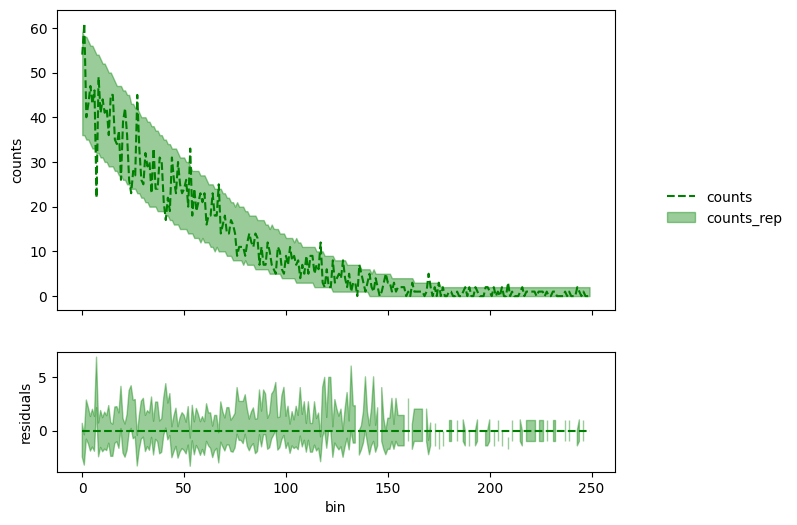

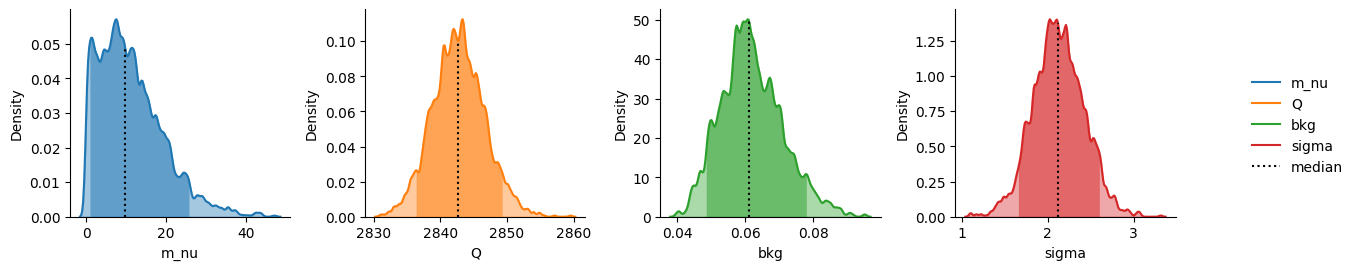

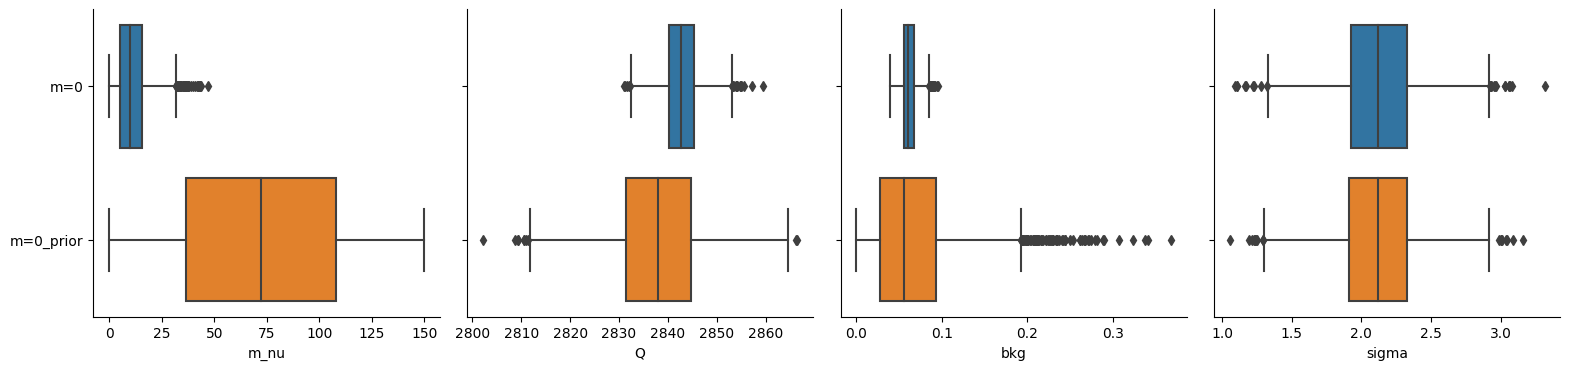

In [44]:
def standard_analysis(model, data, plot, sampler_kwargs, fit_title='fit', rep_key='counts_rep', data_key='counts', plot_params='all_stan'):
    print('Constructing prior predictive check')
    data['prior']=1
    sampler_kwargs['show_progress'] = False
    fit_prior = model.sample(data, **sampler_kwargs)
    print('\n ---- Prior predictive check ---- \n')
    plot.add_fit(fit_prior, fit_title=fit_title+'_prior')
    plot.predictive_check(rep_key, data=data, data_key=data_key)
    print('\n ---- Prior distribustions ---- \n')
    plot.kde_plot(parameters=plot_params, hue='variable')

    sampler_kwargs['inits'] = inits_from_priors(model, fit_prior, sampler_kwargs['chains'])
    data['prior']=0
    sampler_kwargs['show_progress'] = True
    print('Fitting the model')
    fit = model.sample(data, **sampler_kwargs)
    
    print(fit.diagnose())

    plot.add_fit(fit, fit_title=fit_title)
    plot.convergence_plot(parameters=plot_params, initial_steps=100)
    print('\n ---- Prior predictive check ---- \n')
    plot.predictive_check(rep_key, data=data, data_key=data_key)
    print('\n ---- Posterior distribustions ---- \n')
    plot.kde_plot(parameters=plot_params, hue='variable')
    print('\n ---- Prior vs posterior comparison ---- \n')

    p.cat_plot(parameters=plot_params, fit_titles=[fit_title, fit_title + '_prior'])
    return fit

sampler_kwargs={
    'chains': 4,
    'iter_warmup': 600,
    'iter_sampling': 600,
    'save_warmup': True, 
    'adapt_delta': 0.9
}

plot_pars = ['m_nu', 'Q', 'bkg', 'sigma']
p = FitPlotter(col_wrap=4, style="default")
fit = simple_analysis(model, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars)
#fit = simple_analysis(model_sigma, data, p, sampler_kwargs, fit_title='sigma')

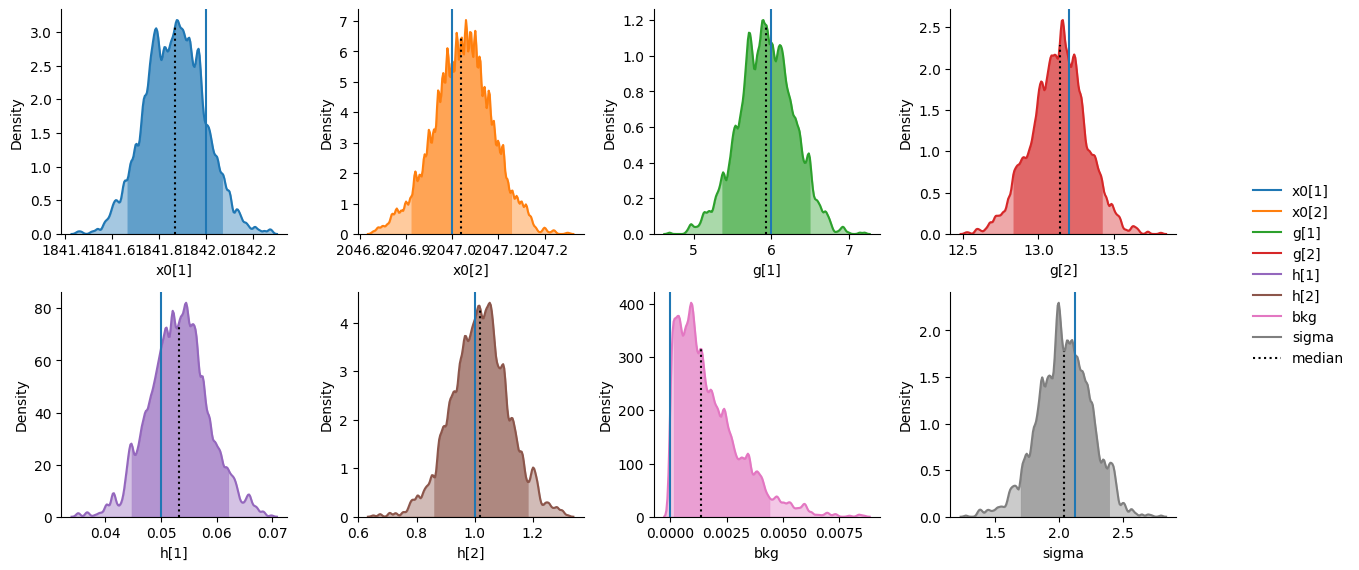

In [94]:
true_params=[1842, 2047, 6, 13.2, 0.05, 1, true_weights[1], s.sigma]
p.kde_plot(hue='variable')
plt.close()
p.add_lines(true_params)
p.get_current_figure()

17:21:37 - cmdstanpy - INFO - CmdStan start processing
17:21:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  43
Constructing prior predictive check


17:21:38 - cmdstanpy - INFO - CmdStan done processing
17:21:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_rng: Rate parameter[1] is -nan, but must be positive! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 58, column 2 to column 123)
	Exception: poisson_rng: Rate parameter[1] is -nan, but must be positive! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 58, column 2 to column 123)
	Exception: poisson_rng: Rate parameter[1] is -nan, but must be positive! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 58, column 2 to column 123)
	Exception: poisson_rng: Rate parameter[1] is -nan, but must be positive! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 58, column 2 to column 123)
	Exception: poisson_rng: Rate parameter[1] is -nan, but must be positive! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_

/home/pcampana/baynes/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:257: RuntimeWarning: invalid value encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),


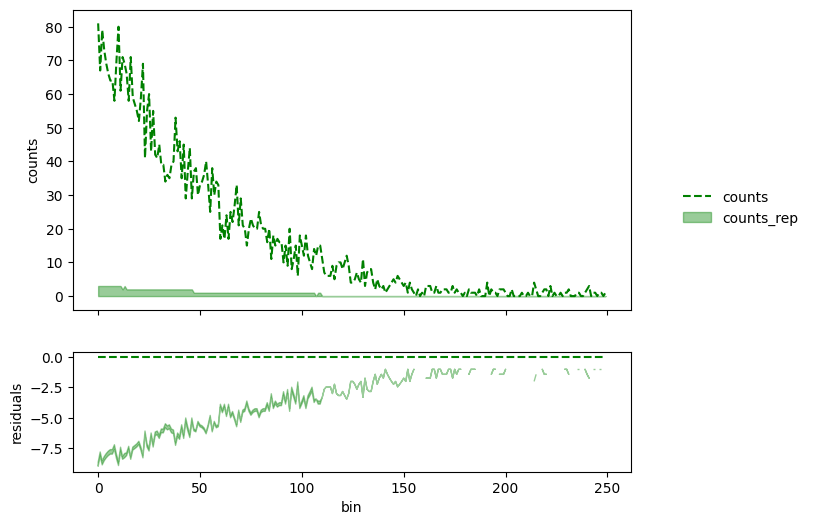

17:21:39 - cmdstanpy - INFO - CmdStan start processing


Fitting the model


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:22:18 - cmdstanpy - INFO - CmdStan done processing.
17:22:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/hol


Processing csv files: /tmp/tmp0qx2_dfe/Ho_spectrum8mbd9epj/Ho_spectrum-20230613172139_1.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp0qx2_dfe/Ho_spectrum8mbd9epj/Ho_spectrum-20230613172139_2.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp0qx2_dfe/Ho_spectrum8mbd9epj/Ho_spectrum-20230613172139_3.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp0qx2_dfe/Ho_spectrum8mbd9epj/Ho_spectrum-20230613172139_4.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



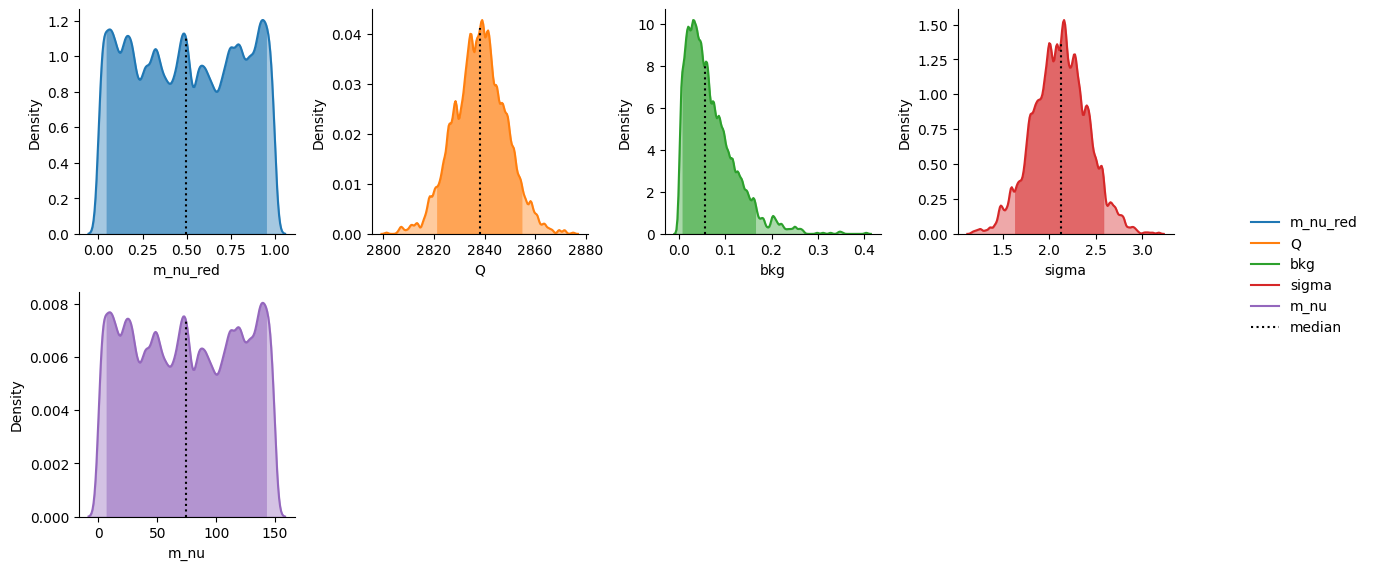

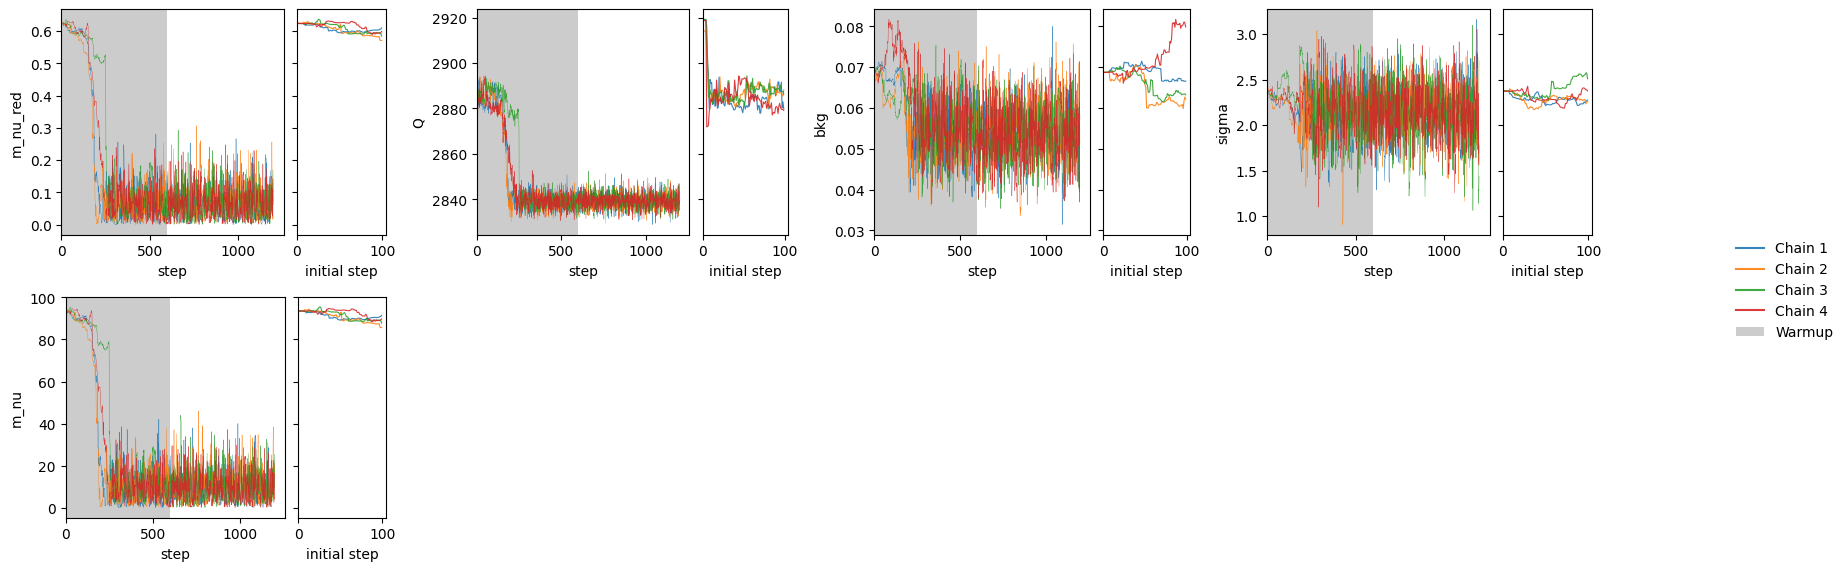

/home/pcampana/baynes/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:257: RuntimeWarning: invalid value encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),


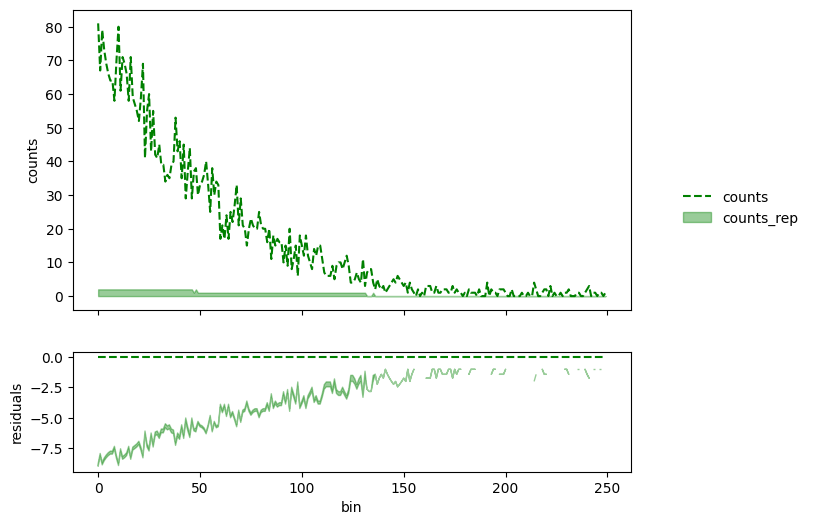

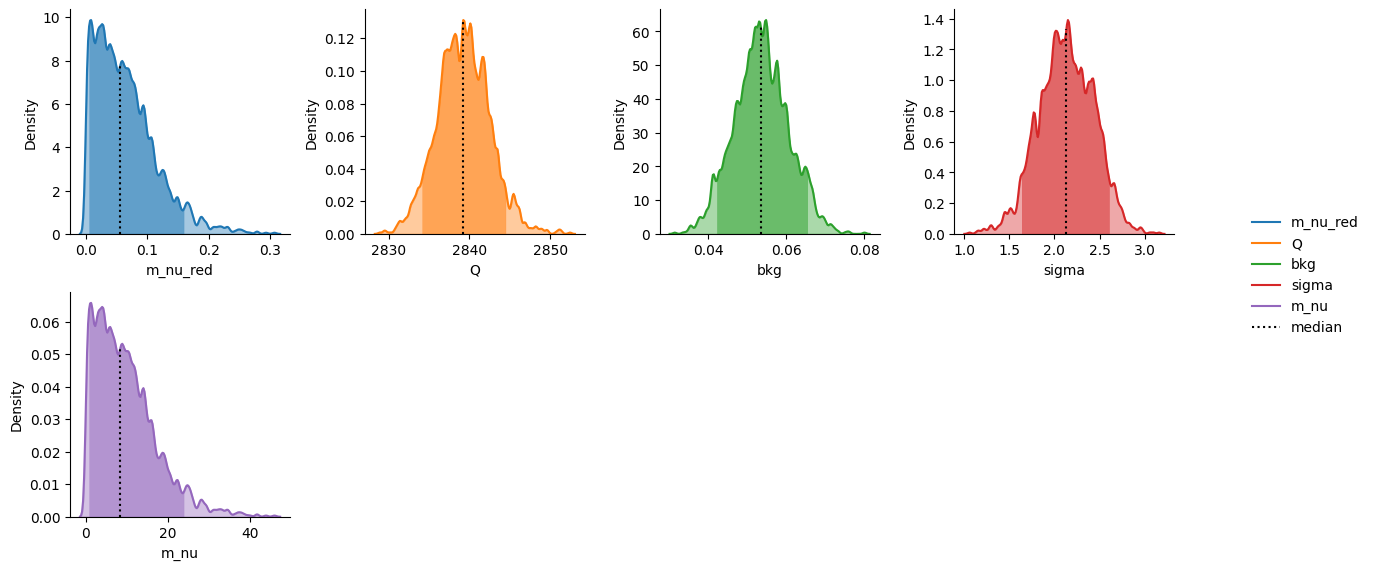

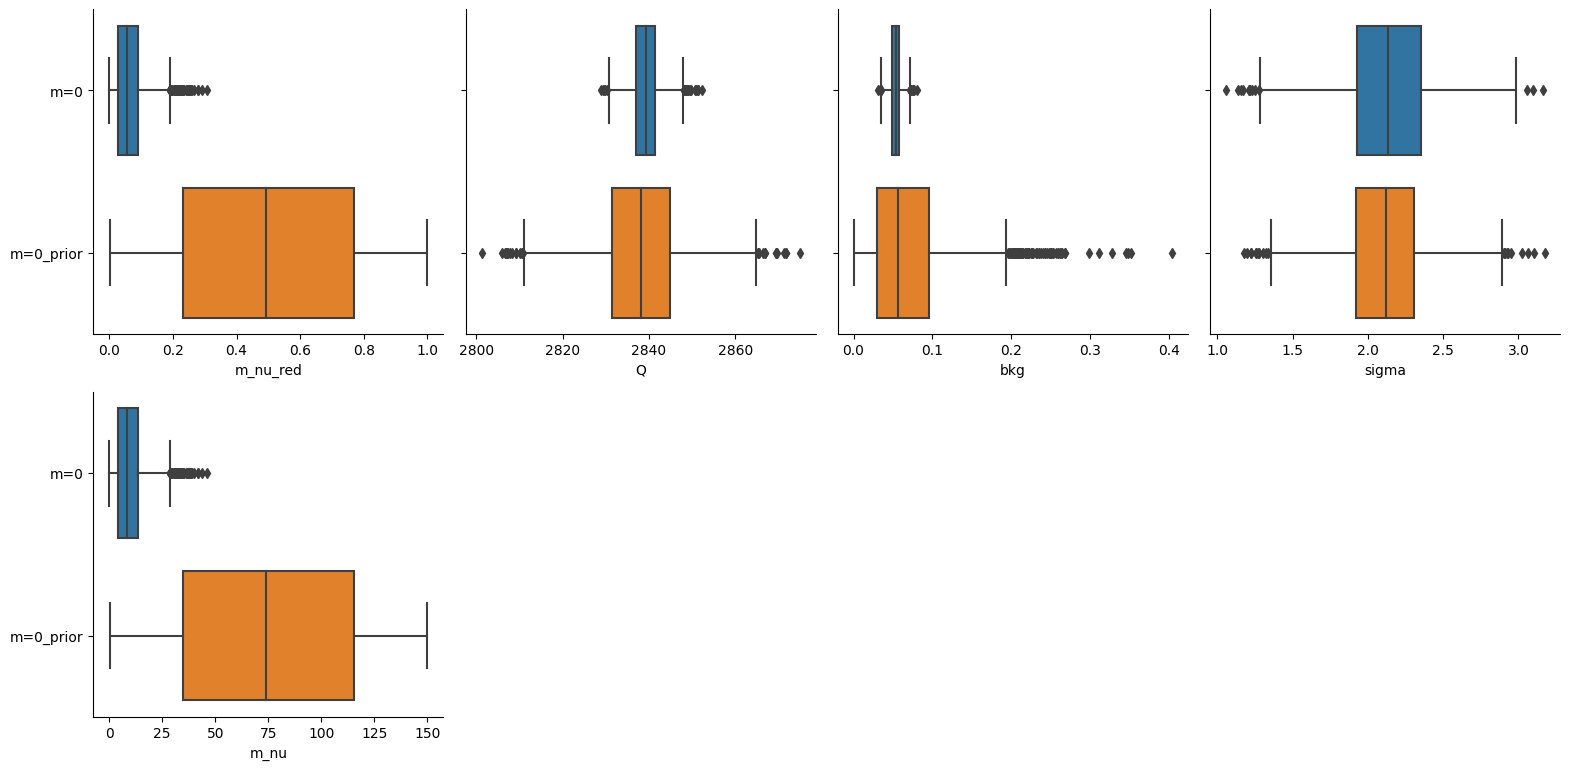

In [36]:

n_days=100
s.update_bins(ROI=[2650, 2900])
s.update_spectrum()
s.set_measure_time(n_days, n_det=1)
s.n_spectra=n_days
x = s.bin_edges[s.ROI_idx[0]:s.ROI_idx[1]+1]
events=s.sample()
data={'N_bins': len(x)-1, 
      'N_window': n_window,
      'N_peaks': 6,
      'x': x, 
      'counts': np.sum(events, axis=0),
      'p_Q': 2838,
      'p_m': 40,
      'p_FWHM': FWHM,
      'N_ev': s.n_events,
      'bkg': true_weights[1],
       'N_days': n_days,
      'counts_per_day': np.sum(events, axis=1)
}



In [5]:
def multithreaded_run(function, args, n_processes, filename='data.pkl'):
    pool = ThreadPool(processes=n_processes)
    results = pool.map(function, args)
    if filename is not None:
        output = open(filename, 'wb')
        pickle.dump(results, output)
        output.close()
    return results

In [52]:
def m0_coverage(m):
    Qp = np.random.normal(2838, 10)
    weight_bkg = np.random.beta(1.5, 20)
    FW = np.random.normal(5, 0.3*2*np.sqrt(2*np.log(2)))
    
    s = SpectraSampler([(HoSpectrum, [m, Qp], A_Ho)], flat_bkg=0, FWHM=FW)
    s.flat_bkg = sum(s.spectrum['HoSpectrum'][s.ROI_idx[0]:s.ROI_idx[1]])*(weight_bkg/(1-weight_bkg))/len(s.ROI_bin_centers)
    s.update_spectrum()
    s.set_measure_time(n_days, n_det=64)
    data={'N_bins': len(x)-1, 
          'N_window': n_window,
          'x': x, 
          'counts': s.sample()[0],
          'N_ev': s.n_events,
          'p_Q': 2838,
          'p_FWHM': 5,
          'prior': 0,
    }
    
    div = True
    while div is True:
        inits={}
        inits['m_nu_red'] = np.random.beta(1,1.05)/3 #the initial value for m_nu shouldn't be too large
        inits['Q'] = np.random.normal(2838, 10)
        inits['bkg'] = np.random.beta(1.5, 20)
        inits['sigma'] = np.random.normal(s.sigma, 0.3)
            
        fit = model.sample(data,
                           chains=2,
                           iter_warmup=500,
                           iter_sampling=1000,
                           save_warmup=False,
                           show_progress=False,
                           inits=inits,
                           adapt_delta=0.9)
        div = any(fit.divergences)
    return fit

multi_res = []
for m in (0, 5, 10, 15, 20, 25, 30):
    multi_res.append(multithreaded_run(m0_coverage, [m]*100, 24, filename='data/'+str(m)+'_priors.pkl'))

Number of events in ROI:  3108
Number of events in ROI:  2667


22:34:46 - cmdstanpy - INFO - CmdStan start processing
22:34:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3151
Number of events in ROI:  3199


22:34:52 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3187


22:34:54 - cmdstanpy - INFO - CmdStan start processing
22:34:56 - cmdstanpy - INFO - CmdStan start processing
22:34:57 - cmdstanpy - INFO - CmdStan start processing
22:34:58 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2763
Number of events in ROI:  3096
Number of events in ROI:  3332
Number of events in ROI:  2607
Number of events in ROI:  2896


22:34:58 - cmdstanpy - INFO - CmdStan start processing
22:34:59 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2569
Number of events in ROI:  2677


22:35:02 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3245
Number of events in ROI:  2349
Number of events in ROI:  2173
Number of events in ROI:  3112
Number of events in ROI:  3042
Number of events in ROI:  2844


22:35:08 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2400
Number of events in ROI:  2823
Number of events in ROI:  3676


22:35:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2917


22:35:14 - cmdstanpy - INFO - CmdStan start processing
22:35:15 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2258


22:35:15 - cmdstanpy - INFO - CmdStan done processing
22:35:15 - cmdstanpy - INFO - CmdStan start processing
22:35:17 - cmdstanpy - INFO - CmdStan start processing
22:35:18 - cmdstanpy - INFO - CmdStan start processing
22:35:18 - cmdstanpy - INFO - CmdStan start processing
22:35:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  3168


22:35:27 - cmdstanpy - INFO - CmdStan start processing
22:35:27 - cmdstanpy - INFO - CmdStan start processing
22:35:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonn

22:35:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[4] is -40.2641, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 

22:35:59 - cmdstanpy - INFO - CmdStan done processing
22:36:01 - cmdstanpy - INFO - CmdStan done processing
22:36:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

22:36:09 - cmdstanpy - INFO - CmdStan done processing
22:36:11 - cmdstanpy - INFO - CmdStan start processing
22:36:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

22:36:16 - cmdstanpy - INFO - CmdStan start processing
22:36:16 - cmdstanpy - INFO - CmdStan done processing
22:36:16 - cmdstanpy - INFO - CmdStan start processing
22:36:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

22:36:24 - cmdstanpy - INFO - CmdStan start processing
22:36:25 - cmdstanpy - INFO - CmdStan done processing
22:36:26 - cmdstanpy - INFO - CmdStan done processing
22:36:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: pois

22:36:41 - cmdstanpy - INFO - CmdStan start processing
22:36:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/hol

22:37:03 - cmdstanpy - INFO - CmdStan done processing
22:37:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2483


22:37:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3187


22:37:40 - cmdstanpy - INFO - CmdStan start processing
22:37:45 - cmdstanpy - INFO - CmdStan start processing
22:37:46 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3323
Number of events in ROI:  1871
Number of events in ROI:  2938


22:37:51 - cmdstanpy - INFO - CmdStan start processing
22:37:52 - cmdstanpy - INFO - CmdStan start processing
22:37:55 - cmdstanpy - INFO - CmdStan start processing
22:37:55 - cmdstanpy - INFO - CmdStan start processing
22:37:57 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3288


22:37:58 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2928


22:38:03 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2678


22:38:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
Consider re-running with show_console=True if the above output is unclear!
22:38:05 - cmdstanpy - INFO - CmdStan start processing
22:38:05 - cmdstanpy - INFO - CmdStan start proce

Number of events in ROI:  2725
Number of events in ROI:  3121


22:38:07 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2503


22:38:07 - cmdstanpy - INFO - CmdStan done processing
22:38:08 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2300
Number of events in ROI:  2714


22:38:10 - cmdstanpy - INFO - CmdStan start processing
22:38:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/hol

Number of events in ROI:  3881


22:38:12 - cmdstanpy - INFO - CmdStan start processing
22:38:13 - cmdstanpy - INFO - CmdStan start processing
22:38:14 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2918
Number of events in ROI:  2190
Number of events in ROI:  3463
Number of events in ROI:  3308


22:38:14 - cmdstanpy - INFO - CmdStan start processing
22:38:14 - cmdstanpy - INFO - CmdStan start processing
22:38:14 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2542
Number of events in ROI:  2864


22:38:16 - cmdstanpy - INFO - CmdStan start processing
22:38:20 - cmdstanpy - INFO - CmdStan start processing
22:38:20 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3846
Number of events in ROI:  3775
Number of events in ROI:  2826


22:38:21 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2656


22:38:21 - cmdstanpy - INFO - CmdStan start processing
22:38:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/hol

22:38:42 - cmdstanpy - INFO - CmdStan start processing
22:38:44 - cmdstanpy - INFO - CmdStan start processing
22:38:44 - cmdstanpy - INFO - CmdStan done processing
22:38:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

22:38:57 - cmdstanpy - INFO - CmdStan done processing
22:38:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

22:39:01 - cmdstanpy - INFO - CmdStan done processing
22:39:01 - cmdstanpy - INFO - CmdStan done processing
22:39:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

22:39:11 - cmdstanpy - INFO - CmdStan done processing
22:39:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:39:11 - cmdstanpy - INFO - CmdStan done processing
22:39:12 - cmdstanpy - INFO - CmdStan done processing
22:39:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate pa

22:39:20 - cmdstanpy - INFO - CmdStan done processing
22:39:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

22:39:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

22:39:34 - cmdstanpy - INFO - CmdStan start processing
22:39:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:39:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho

Number of events in ROI:  2964


22:39:44 - cmdstanpy - INFO - CmdStan start processing
22:39:46 - cmdstanpy - INFO - CmdStan start processing
22:39:48 - cmdstanpy - INFO - CmdStan start processing
22:39:50 - cmdstanpy - INFO - CmdStan start processing
22:39:52 - cmdstanpy - INFO - CmdStan start processing
22:39:53 - cmdstanpy - INFO - CmdStan start processing
22:40:02 - cmdstanpy - INFO - CmdStan done processing
22:40:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 

Number of events in ROI:  2504
Number of events in ROI:  Number of events in ROI:  2774
2548


22:40:28 - cmdstanpy - INFO - CmdStan done processing
22:40:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3322


22:40:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2664
Number of events in ROI:  3162


22:41:02 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2985


22:41:05 - cmdstanpy - INFO - CmdStan start processing
22:41:08 - cmdstanpy - INFO - CmdStan done processing
22:41:09 - cmdstanpy - INFO - CmdStan done processing
22:41:10 - cmdstanpy - INFO - CmdStan start processing
22:41:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.

Number of events in ROI:  3322
Number of events in ROI:  3836


22:41:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2488


22:41:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:41:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Excep

22:41:25 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2624


22:41:27 - cmdstanpy - INFO - CmdStan start processing
22:41:32 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2477


22:41:34 - cmdstanpy - INFO - CmdStan start processing
22:41:35 - cmdstanpy - INFO - CmdStan start processing
22:41:36 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:41:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/h

Number of events in ROI:  2723


22:41:43 - cmdstanpy - INFO - CmdStan done processing
22:41:44 - cmdstanpy - INFO - CmdStan done processing
22:41:45 - cmdstanpy - INFO - CmdStan done processing
22:41:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3024


22:41:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI: 

22:41:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

 3384


22:41:51 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3490


22:41:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3025


22:41:54 - cmdstanpy - INFO - CmdStan done processing
22:41:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2609


22:41:59 - cmdstanpy - INFO - CmdStan start processing
22:42:01 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3147
Number of events in ROI:  2756


22:42:02 - cmdstanpy - INFO - CmdStan start processing
22:42:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/hol

Number of events in ROI:  3056


22:42:04 - cmdstanpy - INFO - CmdStan start processing
22:42:07 - cmdstanpy - INFO - CmdStan start processing
22:42:08 - cmdstanpy - INFO - CmdStan start processing
22:42:08 - cmdstanpy - INFO - CmdStan start processing
22:42:11 - cmdstanpy - INFO - CmdStan start processing
22:42:12 - cmdstanpy - INFO - CmdStan start processing
22:42:13 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2877
Number of events in ROI:  3415


22:42:14 - cmdstanpy - INFO - CmdStan done processing
22:42:15 - cmdstanpy - INFO - CmdStan start processing
22:42:16 - cmdstanpy - INFO - CmdStan start processing
22:42:16 - cmdstanpy - INFO - CmdStan start processing
22:42:18 - cmdstanpy - INFO - CmdStan start processing
22:42:19 - cmdstanpy - INFO - CmdStan done processing
22:42:20 - cmdstanpy - INFO - CmdStan start processing
22:42:20 - cmdstanpy - INFO - CmdStan start processing
22:42:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/example

22:42:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

22:42:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

22:42:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

22:42:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2862


22:42:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

22:43:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:43:28 - cmdstanpy - INFO - CmdStan start processing
22:43:29 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2473


22:43:33 - cmdstanpy - INFO - CmdStan done processing
22:43:34 - cmdstanpy - INFO - CmdStan done processing
22:43:35 - cmdstanpy - INFO - CmdStan done processing
22:43:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poiss

22:43:39 - cmdstanpy - INFO - CmdStan start processing
22:43:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3490


22:43:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


Number of events in ROI:  3135


22:43:53 - cmdstanpy - INFO - CmdStan done processing
22:43:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3479


22:44:09 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:44:10 - cmdstanpy - INFO - CmdStan done processing
22:44:11 - cmdstanpy - INFO - CmdStan start processing
22:44:11 - cmdstanpy - INFO - CmdStan start processing
22:44:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate 

Number of events in ROI:  2540


22:44:25 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2569


22:44:28 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2576


22:44:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2004


22:44:33 - cmdstanpy - INFO - CmdStan start processing
22:44:33 - cmdstanpy - INFO - CmdStan start processing
22:44:34 - cmdstanpy - INFO - CmdStan done processing
22:44:35 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2550


22:44:39 - cmdstanpy - INFO - CmdStan start processing
22:44:39 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  

22:44:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI: 2108
 2526
Number of events in ROI:  2415


22:44:42 - cmdstanpy - INFO - CmdStan start processing
22:44:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2221


22:44:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2528
Number of events in ROI:  2940


22:44:51 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3023


22:44:52 - cmdstanpy - INFO - CmdStan start processing
22:44:53 - cmdstanpy - INFO - CmdStan start processing
22:44:56 - cmdstanpy - INFO - CmdStan start processing
22:44:58 - cmdstanpy - INFO - CmdStan start processing
22:45:01 - cmdstanpy - INFO - CmdStan start processing
22:45:02 - cmdstanpy - INFO - CmdStan start processing
22:45:03 - cmdstanpy - INFO - CmdStan start processing
22:45:04 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3222


22:45:05 - cmdstanpy - INFO - CmdStan start processing
22:45:06 - cmdstanpy - INFO - CmdStan start processing
22:45:07 - cmdstanpy - INFO - CmdStan done processing
22:45:10 - cmdstanpy - INFO - CmdStan done processing
22:45:10 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2806


22:45:11 - cmdstanpy - INFO - CmdStan done processing
22:45:12 - cmdstanpy - INFO - CmdStan done processing
22:45:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

Number of events in ROI:  3484
Number of events in ROI:  4001


22:45:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

22:45:25 - cmdstanpy - INFO - CmdStan start processing
22:45:25 - cmdstanpy - INFO - CmdStan start processing
22:45:27 - cmdstanpy - INFO - CmdStan start processing
22:45:27 - cmdstanpy - INFO - CmdStan done processing
22:45:28 - cmdstanpy - INFO - CmdStan done processing
22:45:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:45:29 - cmdstanpy - INFO - CmdStan done processing
22:45:29 - cmdstanpy - INFO - CmdStan start processing
22:45:31 - cmdstanpy - INFO - CmdStan done processing
22:45:32 - cmdstanpy - INFO - CmdStan start processing
22:45:32 - cmdstanpy - INFO - CmdStan done processing
22:45:33 - cmdstanpy - INFO - CmdStan done processing
22:45:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 5

22:45:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

22:45:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3112


22:45:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3321


22:45:57 - cmdstanpy - INFO - CmdStan done processing
22:45:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  

22:46:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

2845


22:46:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2517


22:46:24 - cmdstanpy - INFO - CmdStan start processing
22:46:27 - cmdstanpy - INFO - CmdStan start processing
22:46:27 - cmdstanpy - INFO - CmdStan start processing
22:46:31 - cmdstanpy - INFO - CmdStan start processing
22:46:33 - cmdstanpy - INFO - CmdStan start processing
22:46:38 - cmdstanpy - INFO - CmdStan done processing
22:46:39 - cmdstanpy - INFO - CmdStan done processing
22:46:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4

22:46:44 - cmdstanpy - INFO - CmdStan done processing
22:46:44 - cmdstanpy - INFO - CmdStan done processing
22:46:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

22:47:02 - cmdstanpy - INFO - CmdStan done processing
22:47:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2793


22:47:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


Number of events in ROI:  2591


22:47:14 - cmdstanpy - INFO - CmdStan done processing
22:47:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2750


22:47:20 - cmdstanpy - INFO - CmdStan start processing
22:47:21 - cmdstanpy - INFO - CmdStan start processing
22:47:22 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2869


22:47:27 - cmdstanpy - INFO - CmdStan start processing
22:47:28 - cmdstanpy - INFO - CmdStan start processing
22:47:30 - cmdstanpy - INFO - CmdStan start processing
22:47:30 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2237
Number of events in ROI:  2465
Number of events in ROI:  2839


22:47:37 - cmdstanpy - INFO - CmdStan done processing
22:47:37 - cmdstanpy - INFO - CmdStan start processing
22:47:38 - cmdstanpy - INFO - CmdStan start processing
22:47:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  1928


22:47:57 - cmdstanpy - INFO - CmdStan done processing
22:47:57 - cmdstanpy - INFO - CmdStan start processing
22:47:58 - cmdstanpy - INFO - CmdStan done processing
22:48:00 - cmdstanpy - INFO - CmdStan start processing
22:48:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.

Number of events in ROI:  2915


22:48:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2635


22:48:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI: 

22:48:10 - cmdstanpy - INFO - CmdStan done processing


 2982
Number of events in ROI:  3516


22:48:14 - cmdstanpy - INFO - CmdStan start processing
22:48:14 - cmdstanpy - INFO - CmdStan done processing
22:48:14 - cmdstanpy - INFO - CmdStan start processing
22:48:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3010
Number of events in ROI:  3560


22:48:20 - cmdstanpy - INFO - CmdStan start processing
22:48:22 - cmdstanpy - INFO - CmdStan start processing
22:48:23 - cmdstanpy - INFO - CmdStan start processing
22:48:25 - cmdstanpy - INFO - CmdStan done processing
22:48:26 - cmdstanpy - INFO - CmdStan start processing
22:48:27 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


Number of events in ROI:  2886


22:48:28 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI: 

22:48:29 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3130
 1957


22:48:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2801


22:48:36 - cmdstanpy - INFO - CmdStan start processing
22:48:37 - cmdstanpy - INFO - CmdStan start processing
22:48:37 - cmdstanpy - INFO - CmdStan start processing
22:48:38 - cmdstanpy - INFO - CmdStan start processing
22:48:39 - cmdstanpy - INFO - CmdStan start processing
22:48:40 - cmdstanpy - INFO - CmdStan start processing
22:48:41 - cmdstanpy - INFO - CmdStan done processing
22:48:41 - cmdstanpy - INFO - CmdStan start processing
22:48:42 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2931


22:48:45 - cmdstanpy - INFO - CmdStan done processing
22:48:47 - cmdstanpy - INFO - CmdStan start processing
22:48:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2279


22:48:48 - cmdstanpy - INFO - CmdStan done processing
22:48:50 - cmdstanpy - INFO - CmdStan done processing
22:48:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

Number of events in ROI:  2562


22:48:53 - cmdstanpy - INFO - CmdStan start processing
22:48:54 - cmdstanpy - INFO - CmdStan start processing
22:48:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonn

Number of events in ROI:  2629


22:48:58 - cmdstanpy - INFO - CmdStan done processing
22:48:59 - cmdstanpy - INFO - CmdStan start processing
22:49:00 - cmdstanpy - INFO - CmdStan start processing
22:49:02 - cmdstanpy - INFO - CmdStan start processing
22:49:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:49:03 - cmdstanpy - INFO - CmdStan done processing
22:49:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes

22:49:19 - cmdstanpy - INFO - CmdStan start processing
22:49:22 - cmdstanpy - INFO - CmdStan done processing
22:49:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2801


22:49:26 - cmdstanpy - INFO - CmdStan done processing
22:49:30 - cmdstanpy - INFO - CmdStan done processing
22:49:31 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:49:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/hom

Number of events in ROI:  2473
Number of events in ROI:  3217


22:49:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3365


22:49:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3798


22:50:07 - cmdstanpy - INFO - CmdStan done processing
22:50:07 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2833


22:50:10 - cmdstanpy - INFO - CmdStan done processing
22:50:13 - cmdstanpy - INFO - CmdStan start processing
22:50:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

22:50:33 - cmdstanpy - INFO - CmdStan done processing
22:50:35 - cmdstanpy - INFO - CmdStan done processing
22:50:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

Number of events in ROI:  2295
Number of events in ROI:  2734


22:50:47 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI: 

22:50:50 - cmdstanpy - INFO - CmdStan start processing


 2527


22:50:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2257


22:50:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:50:52 - cmdstanpy - INFO - CmdStan done processing
22:50:52 - cmdstanpy - INFO - CmdStan start processing
22:50:54 - cmdstanpy - INFO - CmdStan start processing
22:50:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate 

Number of events in ROI:  3160


22:51:01 - cmdstanpy - INFO - CmdStan start processing
22:51:04 - cmdstanpy - INFO - CmdStan start processing
22:51:05 - cmdstanpy - INFO - CmdStan start processing
22:51:05 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:51:08 - cmdstanpy - INFO - CmdStan start processing
22:51:10 - cmdstanpy - INFO - CmdStan start processing
22:51:13 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI: Number of events in ROI:  2609
 2915


22:51:18 - cmdstanpy - INFO - CmdStan start processing
22:51:20 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2934


22:51:25 - cmdstanpy - INFO - CmdStan start processing
22:51:26 - cmdstanpy - INFO - CmdStan start processing
22:51:26 - cmdstanpy - INFO - CmdStan start processing
22:51:27 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2962


22:51:29 - cmdstanpy - INFO - CmdStan start processing
22:51:31 - cmdstanpy - INFO - CmdStan start processing
22:51:32 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2859


22:51:35 - cmdstanpy - INFO - CmdStan start processing
22:51:35 - cmdstanpy - INFO - CmdStan done processing
22:51:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  4175


22:51:37 - cmdstanpy - INFO - CmdStan done processing
22:51:38 - cmdstanpy - INFO - CmdStan done processing
22:51:39 - cmdstanpy - INFO - CmdStan start processing
22:51:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: pois

Number of events in ROI:  2662


22:51:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3292
Number of events in ROI:  2608


22:51:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

22:51:58 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2975


22:51:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3762
Number of events in ROI:  3613


22:52:05 - cmdstanpy - INFO - CmdStan start processing
22:52:05 - cmdstanpy - INFO - CmdStan start processing
22:52:06 - cmdstanpy - INFO - CmdStan start processing
22:52:07 - cmdstanpy - INFO - CmdStan done processing
22:52:10 - cmdstanpy - INFO - CmdStan done processing
22:52:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampa

Number of events in ROI:  3714
Number of events in ROI:  3017


22:52:17 - cmdstanpy - INFO - CmdStan start processing
22:52:17 - cmdstanpy - INFO - CmdStan done processing
22:52:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

22:52:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

22:52:42 - cmdstanpy - INFO - CmdStan done processing
22:52:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

22:52:55 - cmdstanpy - INFO - CmdStan done processing
22:52:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
Consider re-running with show_console=True if the above output is unclear!
22:52:59 - cmdstanpy - INFO - CmdStan done processing
22:53:01 - cmdstanpy - INFO - CmdStan done processing
22:53:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be n

Number of events in ROI:  2743
Number of events in ROI:  2258
Number of events in ROI:  3086


22:53:24 - cmdstanpy - INFO - CmdStan start processing
22:53:27 - cmdstanpy - INFO - CmdStan start processing
22:53:28 - cmdstanpy - INFO - CmdStan start processing
22:53:29 - cmdstanpy - INFO - CmdStan start processing
22:53:32 - cmdstanpy - INFO - CmdStan start processing
22:53:34 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2244
Number of events in ROI:  2636


22:53:49 - cmdstanpy - INFO - CmdStan start processing
22:53:50 - cmdstanpy - INFO - CmdStan start processing
22:53:51 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2316


22:53:51 - cmdstanpy - INFO - CmdStan done processing
22:53:53 - cmdstanpy - INFO - CmdStan start processing
22:53:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2647


22:53:58 - cmdstanpy - INFO - CmdStan start processing
22:54:00 - cmdstanpy - INFO - CmdStan start processing
22:54:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonn

Number of events in ROI:  2373


22:54:23 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2992


22:54:25 - cmdstanpy - INFO - CmdStan start processing
22:54:27 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2668


22:54:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2207


22:54:31 - cmdstanpy - INFO - CmdStan start processing
22:54:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/hol

22:54:41 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2181


22:54:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:54:47 - cmdstanpy - INFO - CmdStan start processing
22:54:49 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3621


22:54:52 - cmdstanpy - INFO - CmdStan start processing
22:54:54 - cmdstanpy - INFO - CmdStan start processing
22:54:56 - cmdstanpy - INFO - CmdStan start processing
22:54:57 - cmdstanpy - INFO - CmdStan start processing
22:55:00 - cmdstanpy - INFO - CmdStan done processing
22:55:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  2940


22:55:06 - cmdstanpy - INFO - CmdStan done processing
22:55:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2745


22:55:11 - cmdstanpy - INFO - CmdStan start processing
22:55:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/hol

22:55:17 - cmdstanpy - INFO - CmdStan start processing
22:55:19 - cmdstanpy - INFO - CmdStan start processing
22:55:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonn

Number of events in ROI:  2247
Number of events in ROI:  2300


22:55:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:55:26 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2647


22:55:27 - cmdstanpy - INFO - CmdStan start processing
22:55:28 - cmdstanpy - INFO - CmdStan start processing
22:55:29 - cmdstanpy - INFO - CmdStan start processing
22:55:29 - cmdstanpy - INFO - CmdStan start processing
22:55:30 - cmdstanpy - INFO - CmdStan start processing
22:55:31 - cmdstanpy - INFO - CmdStan start processing
22:55:32 - cmdstanpy - INFO - CmdStan start processing
22:55:32 - cmdstanpy - INFO - CmdStan done processing
22:55:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/exampl

Number of events in ROI:  2119


22:55:39 - cmdstanpy - INFO - CmdStan done processing
22:55:41 - cmdstanpy - INFO - CmdStan start processing
22:55:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2802
Number of events in ROI:  2626
Number of events in ROI:  3168


22:55:48 - cmdstanpy - INFO - CmdStan start processing
22:55:48 - cmdstanpy - INFO - CmdStan start processing
22:55:49 - cmdstanpy - INFO - CmdStan done processing
22:55:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2511
Number of events in ROI:  2705


22:55:50 - cmdstanpy - INFO - CmdStan start processing
22:55:50 - cmdstanpy - INFO - CmdStan start processing
22:55:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonn

Number of events in ROI:  3457


22:55:56 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2368


22:55:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3010


22:55:58 - cmdstanpy - INFO - CmdStan start processing
22:55:58 - cmdstanpy - INFO - CmdStan start processing
22:55:59 - cmdstanpy - INFO - CmdStan start processing
22:56:04 - cmdstanpy - INFO - CmdStan start processing
22:56:05 - cmdstanpy - INFO - CmdStan start processing
22:56:05 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:56:06 - cmdstanpy - INFO - CmdStan start processing
22:56:07 - cmdstanpy - INFO - CmdStan done processing
22:56:08 - cmdstanpy - INFO - CmdStan start processing
22:56:08 - cmdstanpy - INFO - CmdStan done processing
22:56:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (i

22:56:17 - cmdstanpy - INFO - CmdStan done processing
22:56:17 - cmdstanpy - INFO - CmdStan done processing
22:56:17 - cmdstanpy - INFO - CmdStan done processing
22:56:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poiss

Number of events in ROI:  2489


22:56:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2473


22:56:26 - cmdstanpy - INFO - CmdStan done processing
22:56:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2017


22:56:28 - cmdstanpy - INFO - CmdStan done processing
22:56:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2523


22:56:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

22:56:36 - cmdstanpy - INFO - CmdStan start processing
22:56:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/hol

Number of events in ROI:  3407
Number of events in ROI:  2807
Number of events in ROI:  2983


22:56:43 - cmdstanpy - INFO - CmdStan start processing
22:56:43 - cmdstanpy - INFO - CmdStan start processing
22:56:43 - cmdstanpy - INFO - CmdStan start processing
22:56:44 - cmdstanpy - INFO - CmdStan start processing
22:56:44 - cmdstanpy - INFO - CmdStan start processing
22:56:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2462
Number of events in ROI:  2641


22:56:53 - cmdstanpy - INFO - CmdStan start processing
22:56:53 - cmdstanpy - INFO - CmdStan start processing
22:56:53 - cmdstanpy - INFO - CmdStan start processing
22:56:54 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2892


22:56:54 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  3449
Number of events in ROI:  3855


22:56:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2309


22:56:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3803


22:56:59 - cmdstanpy - INFO - CmdStan start processing
22:56:59 - cmdstanpy - INFO - CmdStan done processing
22:57:00 - cmdstanpy - INFO - CmdStan start processing
22:57:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2573


22:57:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2623
Number of events in ROI:  3049


22:57:01 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2211


22:57:02 - cmdstanpy - INFO - CmdStan done processing
22:57:02 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2500


22:57:02 - cmdstanpy - INFO - CmdStan start processing
22:57:02 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2490


22:57:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2596


22:57:03 - cmdstanpy - INFO - CmdStan start processing
22:57:03 - cmdstanpy - INFO - CmdStan start processing
22:57:03 - cmdstanpy - INFO - CmdStan start processing
22:57:03 - cmdstanpy - INFO - CmdStan done processing
22:57:03 - cmdstanpy - INFO - CmdStan start processing
22:57:04 - cmdstanpy - INFO - CmdStan start processing
22:57:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate paramete

Number of events in ROI:  3461


22:57:07 - cmdstanpy - INFO - CmdStan start processing
22:57:07 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2281


22:57:17 - cmdstanpy - INFO - CmdStan start processing
22:57:17 - cmdstanpy - INFO - CmdStan start processing
22:57:18 - cmdstanpy - INFO - CmdStan start processing
22:57:18 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3019


22:57:18 - cmdstanpy - INFO - CmdStan start processing
22:57:18 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3292


22:57:19 - cmdstanpy - INFO - CmdStan done processing
22:57:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

22:57:29 - cmdstanpy - INFO - CmdStan done processing
22:57:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

22:57:31 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:57:31 - cmdstanpy - INFO - CmdStan start processing
22:57:31 - cmdstanpy - INFO - CmdStan start processing
22:57:32 - cmdstanpy - INFO - CmdStan done processing
22:57:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate 

22:57:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.
22:57:35 - cmdstanpy - INFO - CmdStan start processing
22:57:35 - cmdstanpy - INFO - CmdStan start processing
22:57:36 - cmdstanpy - INFO - CmdStan done processing
22:57:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate 

Number of events in ROI:  3229


22:57:38 - cmdstanpy - INFO - CmdStan done processing
22:57:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

22:57:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

22:57:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
22:57:43 - cmdstanpy - INFO - CmdStan start processing
22:57:43 - cmdstanpy - INFO - CmdStan start processing
22:57:44 - cmdstanpy - INFO - CmdStan start processing
22:57:44 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2721


22:57:48 - cmdstanpy - INFO - CmdStan done processing
22:57:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

22:58:01 - cmdstanpy - INFO - CmdStan done processing
22:58:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3484


22:58:05 - cmdstanpy - INFO - CmdStan done processing
22:58:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

22:58:14 - cmdstanpy - INFO - CmdStan done processing
22:58:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2716


22:58:21 - cmdstanpy - INFO - CmdStan done processing
22:58:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2391
Number of events in ROI:  2476


23:01:51 - cmdstanpy - INFO - CmdStan start processing
23:01:51 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2106
Number of events in ROI:  2216
Number of events in ROI:  2389
Number of events in ROI:  3101
Number of events in ROI:  3509


23:01:53 - cmdstanpy - INFO - CmdStan start processing
23:01:53 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2650
Number of events in ROI:  3099
Number of events in ROI:  2973
Number of events in ROI:  3143


23:01:55 - cmdstanpy - INFO - CmdStan start processing
23:01:55 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  4028
Number of events in ROI:  2570
Number of events in ROI:  2554


23:01:55 - cmdstanpy - INFO - CmdStan start processing
23:01:55 - cmdstanpy - INFO - CmdStan start processing
23:01:56 - cmdstanpy - INFO - CmdStan start processing
23:01:56 - cmdstanpy - INFO - CmdStan start processing
23:01:56 - cmdstanpy - INFO - CmdStan start processing
23:01:56 - cmdstanpy - INFO - CmdStan start processing
23:01:56 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3685


23:01:56 - cmdstanpy - INFO - CmdStan start processing
23:01:57 - cmdstanpy - INFO - CmdStan start processing
23:01:57 - cmdstanpy - INFO - CmdStan start processing
23:01:57 - cmdstanpy - INFO - CmdStan start processing
23:01:57 - cmdstanpy - INFO - CmdStan start processing
23:01:57 - cmdstanpy - INFO - CmdStan start processing
23:01:58 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3093
Number of events in ROI:  2903


23:01:58 - cmdstanpy - INFO - CmdStan start processing
23:01:58 - cmdstanpy - INFO - CmdStan start processing
23:01:58 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3362


23:01:58 - cmdstanpy - INFO - CmdStan start processing
23:01:58 - cmdstanpy - INFO - CmdStan start processing
23:01:59 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3551
Number of events in ROI:  2862
Number of events in ROI:  3543


23:01:59 - cmdstanpy - INFO - CmdStan start processing
23:01:59 - cmdstanpy - INFO - CmdStan start processing
23:01:59 - cmdstanpy - INFO - CmdStan start processing
23:01:59 - cmdstanpy - INFO - CmdStan start processing
23:01:59 - cmdstanpy - INFO - CmdStan start processing
23:01:59 - cmdstanpy - INFO - CmdStan start processing
23:01:59 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2097


23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing
23:02:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3402
Number of events in ROI:  2865


23:02:18 - cmdstanpy - INFO - CmdStan done processing
23:02:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:02:25 - cmdstanpy - INFO - CmdStan done processing
23:02:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2486


23:02:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:02:31 - cmdstanpy - INFO - CmdStan done processing
23:02:31 - cmdstanpy - INFO - CmdStan done processing
23:02:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

23:02:32 - cmdstanpy - INFO - CmdStan done processing
23:02:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:02:37 - cmdstanpy - INFO - CmdStan done processing
23:02:37 - cmdstanpy - INFO - CmdStan done processing
23:02:38 - cmdstanpy - INFO - CmdStan done processing
23:02:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poiss

23:02:39 - cmdstanpy - INFO - CmdStan done processing
23:02:40 - cmdstanpy - INFO - CmdStan done processing
23:02:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

23:02:43 - cmdstanpy - INFO - CmdStan done processing
23:02:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:02:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:03:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:03:23 - cmdstanpy - INFO - CmdStan start processing
23:03:24 - cmdstanpy - INFO - CmdStan start processing
23:03:44 - cmdstanpy - INFO - CmdStan done processing
23:03:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate 

Number of events in ROI:  2477


23:03:51 - cmdstanpy - INFO - CmdStan done processing
23:03:51 - cmdstanpy - INFO - CmdStan start processing
23:03:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2679


23:04:31 - cmdstanpy - INFO - CmdStan start processing
23:04:32 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2351


23:04:35 - cmdstanpy - INFO - CmdStan start processing
23:04:35 - cmdstanpy - INFO - CmdStan start processing
23:04:37 - cmdstanpy - INFO - CmdStan done processing
23:04:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:04:55 - cmdstanpy - INFO - CmdStan done processing
23:04:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3686


23:05:06 - cmdstanpy - INFO - CmdStan start processing
23:05:06 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2786


23:05:11 - cmdstanpy - INFO - CmdStan start processing
23:05:11 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2990


23:05:16 - cmdstanpy - INFO - CmdStan start processing
23:05:17 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2082


23:05:19 - cmdstanpy - INFO - CmdStan start processing
23:05:21 - cmdstanpy - INFO - CmdStan start processing
23:05:21 - cmdstanpy - INFO - CmdStan done processing
23:05:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2719


23:05:25 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3405


23:05:26 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3091


23:05:26 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2307


23:05:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3012
Number of events in ROI:  2768
Number of events in ROI:  3191
Number of events in ROI: Number of events in ROI:  2168
 2416


23:05:33 - cmdstanpy - INFO - CmdStan start processing
23:05:33 - cmdstanpy - INFO - CmdStan start processing
23:05:33 - cmdstanpy - INFO - CmdStan start processing
23:05:34 - cmdstanpy - INFO - CmdStan start processing
23:05:34 - cmdstanpy - INFO - CmdStan start processing
23:05:34 - cmdstanpy - INFO - CmdStan start processing
23:05:34 - cmdstanpy - INFO - CmdStan start processing
23:05:34 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2293


23:05:35 - cmdstanpy - INFO - CmdStan start processing
23:05:35 - cmdstanpy - INFO - CmdStan start processing
23:05:36 - cmdstanpy - INFO - CmdStan start processing
23:05:36 - cmdstanpy - INFO - CmdStan start processing
23:05:38 - cmdstanpy - INFO - CmdStan done processing
23:05:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  3884


23:05:41 - cmdstanpy - INFO - CmdStan start processing
23:05:41 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI: Number of events in ROI:  3260
 3638


23:05:43 - cmdstanpy - INFO - CmdStan start processing
23:05:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2802


23:05:43 - cmdstanpy - INFO - CmdStan start processing
23:05:43 - cmdstanpy - INFO - CmdStan start processing
23:05:44 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3901


23:05:45 - cmdstanpy - INFO - CmdStan start processing
23:05:45 - cmdstanpy - INFO - CmdStan start processing
23:05:45 - cmdstanpy - INFO - CmdStan start processing
23:05:47 - cmdstanpy - INFO - CmdStan done processing
23:05:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum

23:05:55 - cmdstanpy - INFO - CmdStan done processing
23:05:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:06:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:06:03 - cmdstanpy - INFO - CmdStan done processing
23:06:03 - cmdstanpy - INFO - CmdStan done processing
23:06:04 - cmdstanpy - INFO - CmdStan done processing
23:06:04 - cmdstanpy - INFO - CmdStan done processing
23:06:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, co

23:06:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:06:11 - cmdstanpy - INFO - CmdStan done processing
23:06:11 - cmdstanpy - INFO - CmdStan done processing
23:06:11 - cmdstanpy - INFO - CmdStan start processing
23:06:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: pois

23:06:13 - cmdstanpy - INFO - CmdStan done processing
23:06:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:06:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_

Number of events in ROI:  2523


23:06:17 - cmdstanpy - INFO - CmdStan start processing
23:06:17 - cmdstanpy - INFO - CmdStan start processing
23:06:17 - cmdstanpy - INFO - CmdStan start processing
23:06:18 - cmdstanpy - INFO - CmdStan start processing
23:06:19 - cmdstanpy - INFO - CmdStan start processing
23:06:19 - cmdstanpy - INFO - CmdStan start processing
23:06:25 - cmdstanpy - INFO - CmdStan done processing
23:06:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 

Number of events in ROI:  2152


23:06:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:06:46 - cmdstanpy - INFO - CmdStan done processing
23:06:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2784


23:07:00 - cmdstanpy - INFO - CmdStan start processing
23:07:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2883
Number of events in ROI:  2446


23:07:04 - cmdstanpy - INFO - CmdStan start processing
23:07:06 - cmdstanpy - INFO - CmdStan start processing
23:07:06 - cmdstanpy - INFO - CmdStan start processing
23:07:07 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2617


23:07:17 - cmdstanpy - INFO - CmdStan start processing
23:07:19 - cmdstanpy - INFO - CmdStan start processing
23:07:22 - cmdstanpy - INFO - CmdStan done processing
23:07:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:07:33 - cmdstanpy - INFO - CmdStan done processing
23:07:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2890


23:07:47 - cmdstanpy - INFO - CmdStan done processing
23:07:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3289
Number of events in ROI:  2140


23:08:20 - cmdstanpy - INFO - CmdStan start processing
23:08:20 - cmdstanpy - INFO - CmdStan start processing
23:08:24 - cmdstanpy - INFO - CmdStan start processing
23:08:25 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3041


23:08:37 - cmdstanpy - INFO - CmdStan start processing
23:08:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3079


23:08:46 - cmdstanpy - INFO - CmdStan start processing
23:08:47 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2746
Number of events in ROI:  2293


23:08:52 - cmdstanpy - INFO - CmdStan start processing
23:08:53 - cmdstanpy - INFO - CmdStan start processing
23:08:54 - cmdstanpy - INFO - CmdStan done processing
23:08:54 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3020


23:08:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2808
Number of events in ROI:  3121


23:09:00 - cmdstanpy - INFO - CmdStan start processing
23:09:00 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2333


23:09:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3093


23:09:06 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


Number of events in ROI:  2931


23:09:07 - cmdstanpy - INFO - CmdStan start processing
23:09:07 - cmdstanpy - INFO - CmdStan start processing
23:09:08 - cmdstanpy - INFO - CmdStan start processing
23:09:09 - cmdstanpy - INFO - CmdStan start processing
23:09:09 - cmdstanpy - INFO - CmdStan done processing
23:09:09 - cmdstanpy - INFO - CmdStan start processing
23:09:10 - cmdstanpy - INFO - CmdStan start processing
23:09:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 

Number of events in ROI:  3158


23:09:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3178


23:09:19 - cmdstanpy - INFO - CmdStan start processing
23:09:20 - cmdstanpy - INFO - CmdStan start processing
23:09:21 - cmdstanpy - INFO - CmdStan done processing
23:09:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3235


23:09:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2753
Number of events in ROI:  2621


23:09:26 - cmdstanpy - INFO - CmdStan start processing
23:09:27 - cmdstanpy - INFO - CmdStan start processing
23:09:27 - cmdstanpy - INFO - CmdStan done processing
23:09:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3370


23:09:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:09:40 - cmdstanpy - INFO - CmdStan done processing
23:09:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:09:49 - cmdstanpy - INFO - CmdStan done processing
23:09:49 - cmdstanpy - INFO - CmdStan done processing
23:09:49 - cmdstanpy - INFO - CmdStan done processing
23:09:49 - cmdstanpy - INFO - CmdStan done processing
23:09:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.st

23:09:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3524
Number of events in ROI:  2064


23:09:55 - cmdstanpy - INFO - CmdStan start processing
23:09:55 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3513


23:09:56 - cmdstanpy - INFO - CmdStan done processing
23:09:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3370


23:10:02 - cmdstanpy - INFO - CmdStan start processing
23:10:03 - cmdstanpy - INFO - CmdStan start processing
23:10:04 - cmdstanpy - INFO - CmdStan start processing
23:10:05 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3384


23:10:14 - cmdstanpy - INFO - CmdStan done processing
23:10:14 - cmdstanpy - INFO - CmdStan start processing
23:10:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2255


23:10:22 - cmdstanpy - INFO - CmdStan start processing
23:10:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/hol

23:10:33 - cmdstanpy - INFO - CmdStan done processing
23:10:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2553


23:10:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:11:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:11:28 - cmdstanpy - INFO - CmdStan start processing
23:11:28 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3414


23:11:37 - cmdstanpy - INFO - CmdStan start processing
23:11:38 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2329


23:11:49 - cmdstanpy - INFO - CmdStan start processing
23:11:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2456


23:11:53 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2368


23:11:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3146
Number of events in ROI:  2585


23:12:01 - cmdstanpy - INFO - CmdStan start processing
23:12:01 - cmdstanpy - INFO - CmdStan start processing
23:12:03 - cmdstanpy - INFO - CmdStan start processing
23:12:03 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3017
Number of events in ROI:  3376


23:12:07 - cmdstanpy - INFO - CmdStan start processing
23:12:07 - cmdstanpy - INFO - CmdStan start processing
23:12:08 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2337


23:12:09 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2691


23:12:09 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2729


23:12:09 - cmdstanpy - INFO - CmdStan start processing
23:12:10 - cmdstanpy - INFO - CmdStan start processing
23:12:10 - cmdstanpy - INFO - CmdStan start processing
23:12:10 - cmdstanpy - INFO - CmdStan start processing
23:12:10 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2511


23:12:16 - cmdstanpy - INFO - CmdStan done processing
23:12:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2255
Number of events in ROI:  2696


23:12:18 - cmdstanpy - INFO - CmdStan start processing
23:12:18 - cmdstanpy - INFO - CmdStan start processing
23:12:18 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3606


23:12:19 - cmdstanpy - INFO - CmdStan start processing
23:12:19 - cmdstanpy - INFO - CmdStan start processing
23:12:19 - cmdstanpy - INFO - CmdStan done processing
23:12:19 - cmdstanpy - INFO - CmdStan start processing
23:12:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum

Number of events in ROI:  2744


23:12:21 - cmdstanpy - INFO - CmdStan start processing
23:12:21 - cmdstanpy - INFO - CmdStan start processing
23:12:21 - cmdstanpy - INFO - CmdStan start processing
23:12:21 - cmdstanpy - INFO - CmdStan start processing
23:12:22 - cmdstanpy - INFO - CmdStan done processing
23:12:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  2929


23:12:23 - cmdstanpy - INFO - CmdStan start processing
23:12:23 - cmdstanpy - INFO - CmdStan start processing
23:12:23 - cmdstanpy - INFO - CmdStan start processing
23:12:23 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2064


23:12:23 - cmdstanpy - INFO - CmdStan done processing
23:12:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  1775


23:12:28 - cmdstanpy - INFO - CmdStan done processing
23:12:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:12:35 - cmdstanpy - INFO - CmdStan done processing
23:12:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:12:43 - cmdstanpy - INFO - CmdStan done processing
23:12:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:12:47 - cmdstanpy - INFO - CmdStan done processing
23:12:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:12:51 - cmdstanpy - INFO - CmdStan start processing
23:12:51 - cmdstanpy - INFO - CmdStan start processing
23:12:51 - cmdstanpy - INFO - CmdStan done processing
23:12:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3194


23:12:52 - cmdstanpy - INFO - CmdStan done processing
23:12:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2020


23:13:08 - cmdstanpy - INFO - CmdStan done processing
23:13:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:13:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:13:19 - cmdstanpy - INFO - CmdStan start processing
23:13:19 - cmdstanpy - INFO - CmdStan start processing
23:13:23 - cmdstanpy - INFO - CmdStan done processing
23:13:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate 

23:13:47 - cmdstanpy - INFO - CmdStan done processing
23:13:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2894
Number of events in ROI:  2407
Number of events in ROI:  3168
Number of events in ROI:  2663


23:17:03 - cmdstanpy - INFO - CmdStan start processing
23:17:04 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2968
Number of events in ROI:  2223


23:17:04 - cmdstanpy - INFO - CmdStan start processing
23:17:04 - cmdstanpy - INFO - CmdStan start processing
23:17:05 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3460


23:17:05 - cmdstanpy - INFO - CmdStan start processing
23:17:05 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2538


23:17:05 - cmdstanpy - INFO - CmdStan start processing
23:17:05 - cmdstanpy - INFO - CmdStan start processing
23:17:06 - cmdstanpy - INFO - CmdStan start processing
23:17:06 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2699


23:17:07 - cmdstanpy - INFO - CmdStan start processing
23:17:07 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2595
Number of events in ROI:  2108


23:17:08 - cmdstanpy - INFO - CmdStan start processing
23:17:08 - cmdstanpy - INFO - CmdStan start processing
23:17:09 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2481
Number of events in ROI:  2641


23:17:09 - cmdstanpy - INFO - CmdStan start processing
23:17:10 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3224
Number of events in ROI:  2934


23:17:10 - cmdstanpy - INFO - CmdStan start processing
23:17:10 - cmdstanpy - INFO - CmdStan start processing
23:17:10 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2923
Number of events in ROI:  2486
Number of events in ROI:  2863
Number of events in ROI:  2427


23:17:10 - cmdstanpy - INFO - CmdStan start processing
23:17:10 - cmdstanpy - INFO - CmdStan start processing
23:17:11 - cmdstanpy - INFO - CmdStan start processing
23:17:11 - cmdstanpy - INFO - CmdStan start processing
23:17:11 - cmdstanpy - INFO - CmdStan start processing
23:17:11 - cmdstanpy - INFO - CmdStan start processing
23:17:11 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3167
Number of events in ROI:  2939


23:17:11 - cmdstanpy - INFO - CmdStan start processing
23:17:11 - cmdstanpy - INFO - CmdStan start processing
23:17:11 - cmdstanpy - INFO - CmdStan start processing
23:17:11 - cmdstanpy - INFO - CmdStan start processing
23:17:11 - cmdstanpy - INFO - CmdStan start processing
23:17:12 - cmdstanpy - INFO - CmdStan start processing
23:17:12 - cmdstanpy - INFO - CmdStan start processing
23:17:12 - cmdstanpy - INFO - CmdStan start processing
23:17:12 - cmdstanpy - INFO - CmdStan start processing
23:17:12 - cmdstanpy - INFO - CmdStan start processing
23:17:12 - cmdstanpy - INFO - CmdStan start processing
23:17:12 - cmdstanpy - INFO - CmdStan start processing
23:17:12 - cmdstanpy - INFO - CmdStan start processing
23:17:12 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3350


23:17:13 - cmdstanpy - INFO - CmdStan start processing
23:17:13 - cmdstanpy - INFO - CmdStan start processing
23:17:13 - cmdstanpy - INFO - CmdStan start processing
23:17:13 - cmdstanpy - INFO - CmdStan start processing
23:17:13 - cmdstanpy - INFO - CmdStan start processing
23:17:13 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2638
Number of events in ROI:  3701


23:17:37 - cmdstanpy - INFO - CmdStan done processing
23:17:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:17:40 - cmdstanpy - INFO - CmdStan start processing
23:17:40 - cmdstanpy - INFO - CmdStan start processing
23:17:41 - cmdstanpy - INFO - CmdStan done processing
23:17:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:17:43 - cmdstanpy - INFO - CmdStan done processing
23:17:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:17:46 - cmdstanpy - INFO - CmdStan start processing
23:17:47 - cmdstanpy - INFO - CmdStan start processing
23:17:47 - cmdstanpy - INFO - CmdStan done processing
23:17:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:17:49 - cmdstanpy - INFO - CmdStan done processing
23:17:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:17:51 - cmdstanpy - INFO - CmdStan done processing
23:17:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:17:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_

23:17:53 - cmdstanpy - INFO - CmdStan start processing
23:17:53 - cmdstanpy - INFO - CmdStan start processing
23:17:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonn

23:17:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:18:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:18:06 - cmdstanpy - INFO - CmdStan start processing
23:18:06 - cmdstanpy - INFO - CmdStan start processing
23:18:10 - cmdstanpy - INFO - CmdStan done processing
23:18:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3768


23:18:19 - cmdstanpy - INFO - CmdStan done processing
23:18:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:18:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 iterations at max treedepth (0.8%)
	Use function "diagnose()" to see further information.


Number of events in ROI:  3317


23:19:30 - cmdstanpy - INFO - CmdStan start processing
23:19:31 - cmdstanpy - INFO - CmdStan start processing
23:19:52 - cmdstanpy - INFO - CmdStan done processing
23:19:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2674
Number of events in ROI:  2868


23:20:12 - cmdstanpy - INFO - CmdStan start processing
23:20:13 - cmdstanpy - INFO - CmdStan start processing
23:20:15 - cmdstanpy - INFO - CmdStan start processing
23:20:16 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3293


23:20:20 - cmdstanpy - INFO - CmdStan start processing
23:20:21 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2902


23:20:26 - cmdstanpy - INFO - CmdStan start processing
23:20:28 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2850


23:20:33 - cmdstanpy - INFO - CmdStan done processing
23:20:33 - cmdstanpy - INFO - CmdStan start processing
23:20:33 - cmdstanpy - INFO - CmdStan start processing
23:20:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2833


23:20:46 - cmdstanpy - INFO - CmdStan start processing
23:20:47 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3311


23:20:52 - cmdstanpy - INFO - CmdStan done processing
23:20:53 - cmdstanpy - INFO - CmdStan done processing
23:20:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

Number of events in ROI:  3047


23:20:54 - cmdstanpy - INFO - CmdStan start processing
23:20:57 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2794
Number of events in ROI:  3723


23:20:57 - cmdstanpy - INFO - CmdStan start processing
23:20:57 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2054


23:20:59 - cmdstanpy - INFO - CmdStan start processing
23:20:59 - cmdstanpy - INFO - CmdStan start processing
23:21:00 - cmdstanpy - INFO - CmdStan start processing
23:21:00 - cmdstanpy - INFO - CmdStan start processing
23:21:01 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2560


23:21:01 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2882


23:21:04 - cmdstanpy - INFO - CmdStan start processing
23:21:04 - cmdstanpy - INFO - CmdStan start processing
23:21:05 - cmdstanpy - INFO - CmdStan start processing
23:21:05 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3289
Number of events in ROI:  3449


23:21:07 - cmdstanpy - INFO - CmdStan start processing
23:21:08 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2302


23:21:08 - cmdstanpy - INFO - CmdStan done processing
23:21:09 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3337
Number of events in ROI:  2465


23:21:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2959
Number of events in ROI:  3030


23:21:15 - cmdstanpy - INFO - CmdStan start processing
23:21:16 - cmdstanpy - INFO - CmdStan start processing
23:21:16 - cmdstanpy - INFO - CmdStan done processing
23:21:16 - cmdstanpy - INFO - CmdStan start processing
23:21:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum

Number of events in ROI:  4366


23:21:20 - cmdstanpy - INFO - CmdStan done processing
23:21:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3202


23:21:24 - cmdstanpy - INFO - CmdStan start processing
23:21:24 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2739


23:21:25 - cmdstanpy - INFO - CmdStan start processing
23:21:26 - cmdstanpy - INFO - CmdStan start processing
23:21:31 - cmdstanpy - INFO - CmdStan done processing
23:21:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:21:35 - cmdstanpy - INFO - CmdStan done processing
23:21:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:21:39 - cmdstanpy - INFO - CmdStan done processing
23:21:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:21:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:21:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:21:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Excep

Number of events in ROI:  2526


23:22:06 - cmdstanpy - INFO - CmdStan start processing
23:22:06 - cmdstanpy - INFO - CmdStan start processing
23:22:23 - cmdstanpy - INFO - CmdStan done processing
23:22:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2862
Number of events in ROI:  2831


23:22:48 - cmdstanpy - INFO - CmdStan start processing
23:22:48 - cmdstanpy - INFO - CmdStan start processing
23:22:51 - cmdstanpy - INFO - CmdStan start processing
23:22:51 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3398


23:23:00 - cmdstanpy - INFO - CmdStan start processing
23:23:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3020


23:23:05 - cmdstanpy - INFO - CmdStan start processing
23:23:06 - cmdstanpy - INFO - CmdStan start processing
23:23:11 - cmdstanpy - INFO - CmdStan done processing
23:23:11 - cmdstanpy - INFO - CmdStan done processing
23:23:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.

23:23:16 - cmdstanpy - INFO - CmdStan done processing
23:23:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2812


23:23:24 - cmdstanpy - INFO - CmdStan done processing
23:23:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2340


23:23:28 - cmdstanpy - INFO - CmdStan start processing
23:23:28 - cmdstanpy - INFO - CmdStan start processing
23:23:29 - cmdstanpy - INFO - CmdStan start processing
23:23:30 - cmdstanpy - INFO - CmdStan start processing
23:23:52 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2785


23:23:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2604


23:23:58 - cmdstanpy - INFO - CmdStan start processing
23:23:58 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2634


23:24:07 - cmdstanpy - INFO - CmdStan start processing
23:24:08 - cmdstanpy - INFO - CmdStan start processing
23:24:13 - cmdstanpy - INFO - CmdStan done processing
23:24:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2759
Number of events in ROI:  3040


23:24:29 - cmdstanpy - INFO - CmdStan start processing
23:24:29 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2526


23:24:30 - cmdstanpy - INFO - CmdStan done processing
23:24:31 - cmdstanpy - INFO - CmdStan start processing
23:24:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2622


23:24:32 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2981


23:24:32 - cmdstanpy - INFO - CmdStan start processing
23:24:33 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2409


23:24:34 - cmdstanpy - INFO - CmdStan start processing
23:24:35 - cmdstanpy - INFO - CmdStan start processing
23:24:36 - cmdstanpy - INFO - CmdStan start processing
23:24:36 - cmdstanpy - INFO - CmdStan start processing
23:24:37 - cmdstanpy - INFO - CmdStan start processing
23:24:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2807
Number of events in ROI:  2477
Number of events in ROI:  3002


23:24:42 - cmdstanpy - INFO - CmdStan start processing
23:24:43 - cmdstanpy - INFO - CmdStan start processing
23:24:43 - cmdstanpy - INFO - CmdStan start processing
23:24:44 - cmdstanpy - INFO - CmdStan start processing
23:24:45 - cmdstanpy - INFO - CmdStan start processing
23:24:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3483
Number of events in ROI:  2700


23:24:47 - cmdstanpy - INFO - CmdStan start processing
23:24:48 - cmdstanpy - INFO - CmdStan start processing
23:24:48 - cmdstanpy - INFO - CmdStan start processing
23:24:49 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3632


23:24:50 - cmdstanpy - INFO - CmdStan start processing
23:24:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2586


23:24:53 - cmdstanpy - INFO - CmdStan done processing
23:24:53 - cmdstanpy - INFO - CmdStan start processing
23:24:53 - cmdstanpy - INFO - CmdStan start processing
23:24:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:25:03 - cmdstanpy - INFO - CmdStan done processing
23:25:03 - cmdstanpy - INFO - CmdStan done processing
23:25:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

23:25:06 - cmdstanpy - INFO - CmdStan done processing
23:25:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3069


23:25:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:25:23 - cmdstanpy - INFO - CmdStan done processing
23:25:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:25:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2329


23:25:39 - cmdstanpy - INFO - CmdStan start processing
23:25:39 - cmdstanpy - INFO - CmdStan start processing
23:25:46 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2813


23:25:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2303
Number of events in ROI:  2920


23:25:49 - cmdstanpy - INFO - CmdStan start processing
23:25:50 - cmdstanpy - INFO - CmdStan start processing
23:25:50 - cmdstanpy - INFO - CmdStan start processing
23:25:50 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:25:51 - cmdstanpy - INFO - CmdStan start processing
23:25:51 - cmdstanpy - INFO - CmdStan start processing
23:25:52 - cmdstanpy - INFO - CmdStan start processing
23:25:54 - cmdstanpy - INFO - CmdStan start processing
23:25:56 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2230


23:25:58 - cmdstanpy - INFO - CmdStan start processing
23:25:59 - cmdstanpy - INFO - CmdStan start processing
23:26:15 - cmdstanpy - INFO - CmdStan done processing
23:26:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:26:23 - cmdstanpy - INFO - CmdStan done processing
23:26:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2643


23:26:25 - cmdstanpy - INFO - CmdStan start processing
23:26:25 - cmdstanpy - INFO - CmdStan start processing
23:26:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonn

23:26:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3073


23:26:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2532


23:26:38 - cmdstanpy - INFO - CmdStan start processing
23:26:40 - cmdstanpy - INFO - CmdStan done processing
23:26:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2469


23:26:52 - cmdstanpy - INFO - CmdStan start processing
23:26:53 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2498


23:26:54 - cmdstanpy - INFO - CmdStan done processing
23:26:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2907


23:27:16 - cmdstanpy - INFO - CmdStan done processing
23:27:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2915


23:27:21 - cmdstanpy - INFO - CmdStan done processing
23:27:21 - cmdstanpy - INFO - CmdStan start processing
23:27:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2353


23:27:27 - cmdstanpy - INFO - CmdStan start processing
23:27:28 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3006
Number of events in ROI:  2917


23:27:29 - cmdstanpy - INFO - CmdStan start processing
23:27:29 - cmdstanpy - INFO - CmdStan start processing
23:27:30 - cmdstanpy - INFO - CmdStan start processing
23:27:30 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2421


23:27:31 - cmdstanpy - INFO - CmdStan start processing
23:27:32 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2897
Number of events in ROI:  3149


23:27:33 - cmdstanpy - INFO - CmdStan start processing
23:27:34 - cmdstanpy - INFO - CmdStan start processing
23:27:34 - cmdstanpy - INFO - CmdStan start processing
23:27:34 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2209


23:27:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3488


23:27:37 - cmdstanpy - INFO - CmdStan start processing
23:27:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2458


23:27:37 - cmdstanpy - INFO - CmdStan start processing
23:27:38 - cmdstanpy - INFO - CmdStan start processing
23:27:38 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2559
Number of events in ROI:  2168


23:27:38 - cmdstanpy - INFO - CmdStan start processing
23:27:38 - cmdstanpy - INFO - CmdStan start processing
23:27:38 - cmdstanpy - INFO - CmdStan start processing
23:27:38 - cmdstanpy - INFO - CmdStan start processing
23:27:41 - cmdstanpy - INFO - CmdStan done processing
23:27:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  2828


23:27:45 - cmdstanpy - INFO - CmdStan start processing
23:27:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2985


23:27:45 - cmdstanpy - INFO - CmdStan done processing
23:27:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:27:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:27:51 - cmdstanpy - INFO - CmdStan start processing
23:27:51 - cmdstanpy - INFO - CmdStan start processing
23:27:52 - cmdstanpy - INFO - CmdStan done processing
23:27:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate 

23:28:00 - cmdstanpy - INFO - CmdStan done processing
23:28:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2882


23:28:03 - cmdstanpy - INFO - CmdStan done processing
23:28:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:28:05 - cmdstanpy - INFO - CmdStan start processing
23:28:05 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3104


23:28:09 - cmdstanpy - INFO - CmdStan done processing
23:28:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:28:17 - cmdstanpy - INFO - CmdStan done processing
23:28:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:28:42 - cmdstanpy - INFO - CmdStan done processing
23:28:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:29:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 1 had 1 iterations at max treedepth (0.1%)
	Use function "diagnose()" to see further information.
23:29:04 - cmdstanpy - INFO - CmdStan start processing
23:29:04 - cmdstanpy - INFO - CmdStan start processing
23:29:06 - cmdstanpy - INFO - CmdStan done processing
23:29:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, colu

Number of events in ROI:  2809
Number of events in ROI:  2689


23:33:52 - cmdstanpy - INFO - CmdStan start processing
23:33:53 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3256


23:33:53 - cmdstanpy - INFO - CmdStan start processing
23:33:54 - cmdstanpy - INFO - CmdStan start processing
23:33:55 - cmdstanpy - INFO - CmdStan start processing
23:33:55 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI: Number of events in ROI:  2575
 2220
Number of events in ROI:  3583
Number of events in ROI:  2857
Number of events in ROI:  3272


23:33:58 - cmdstanpy - INFO - CmdStan start processing
23:33:59 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3165


23:34:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2646


23:34:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2254
Number of events in ROI:  2601


23:34:00 - cmdstanpy - INFO - CmdStan start processing
23:34:00 - cmdstanpy - INFO - CmdStan start processing
23:34:00 - cmdstanpy - INFO - CmdStan start processing
23:34:01 - cmdstanpy - INFO - CmdStan start processing
23:34:01 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2979
Number of events in ROI:  2741


23:34:01 - cmdstanpy - INFO - CmdStan start processing
23:34:01 - cmdstanpy - INFO - CmdStan start processing
23:34:02 - cmdstanpy - INFO - CmdStan start processing
23:34:02 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3024
Number of events in ROI:  3704


23:34:03 - cmdstanpy - INFO - CmdStan start processing
23:34:03 - cmdstanpy - INFO - CmdStan start processing
23:34:03 - cmdstanpy - INFO - CmdStan start processing
23:34:03 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2445


23:34:03 - cmdstanpy - INFO - CmdStan start processing
23:34:04 - cmdstanpy - INFO - CmdStan start processing
23:34:04 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2585


23:34:04 - cmdstanpy - INFO - CmdStan start processing
23:34:04 - cmdstanpy - INFO - CmdStan start processing
23:34:04 - cmdstanpy - INFO - CmdStan start processing
23:34:05 - cmdstanpy - INFO - CmdStan start processing
23:34:05 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  4219
Number of events in ROI:  2778


23:34:05 - cmdstanpy - INFO - CmdStan start processing
23:34:05 - cmdstanpy - INFO - CmdStan start processing
23:34:05 - cmdstanpy - INFO - CmdStan start processing
23:34:05 - cmdstanpy - INFO - CmdStan start processing
23:34:05 - cmdstanpy - INFO - CmdStan start processing
23:34:06 - cmdstanpy - INFO - CmdStan start processing
23:34:06 - cmdstanpy - INFO - CmdStan start processing
23:34:06 - cmdstanpy - INFO - CmdStan start processing
23:34:06 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  4581


23:34:06 - cmdstanpy - INFO - CmdStan start processing
23:34:06 - cmdstanpy - INFO - CmdStan start processing
23:34:07 - cmdstanpy - INFO - CmdStan start processing
23:34:07 - cmdstanpy - INFO - CmdStan start processing
23:34:07 - cmdstanpy - INFO - CmdStan start processing
23:34:07 - cmdstanpy - INFO - CmdStan start processing
23:34:07 - cmdstanpy - INFO - CmdStan start processing
23:34:07 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3153
Number of events in ROI:  2819
Number of events in ROI:  2662


23:34:14 - cmdstanpy - INFO - CmdStan done processing
23:34:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2529


23:34:29 - cmdstanpy - INFO - CmdStan done processing
23:34:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:34:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:34:30 - cmdstanpy - INFO - CmdStan start processing
23:34:30 - cmdstanpy - INFO - CmdStan start processing
23:34:31 - cmdstanpy - INFO - CmdStan done processing
23:34:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate 

23:34:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:34:36 - cmdstanpy - INFO - CmdStan start processing
23:34:36 - cmdstanpy - INFO - CmdStan start processing
23:34:36 - cmdstanpy - INFO - CmdStan done processing
23:34:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate 

23:34:41 - cmdstanpy - INFO - CmdStan done processing
23:34:41 - cmdstanpy - INFO - CmdStan done processing
23:34:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

23:34:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:34:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:34:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:34:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:35:09 - cmdstanpy - INFO - CmdStan done processing
23:35:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2567


23:35:56 - cmdstanpy - INFO - CmdStan start processing
23:35:57 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3318


23:36:05 - cmdstanpy - INFO - CmdStan start processing
23:36:05 - cmdstanpy - INFO - CmdStan start processing
23:36:29 - cmdstanpy - INFO - CmdStan done processing
23:36:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3098


23:36:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:36:45 - cmdstanpy - INFO - CmdStan start processing
23:36:46 - cmdstanpy - INFO - CmdStan start processing
23:36:46 - cmdstanpy - INFO - CmdStan start processing
23:36:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3053
Number of events in ROI:  2446


23:36:58 - cmdstanpy - INFO - CmdStan start processing
23:36:59 - cmdstanpy - INFO - CmdStan start processing
23:37:01 - cmdstanpy - INFO - CmdStan start processing
23:37:01 - cmdstanpy - INFO - CmdStan start processing
23:37:11 - cmdstanpy - INFO - CmdStan done processing
23:37:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  2578


23:37:19 - cmdstanpy - INFO - CmdStan done processing
23:37:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3658


23:37:25 - cmdstanpy - INFO - CmdStan start processing
23:37:26 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2794


23:37:30 - cmdstanpy - INFO - CmdStan start processing
23:37:30 - cmdstanpy - INFO - CmdStan done processing
23:37:30 - cmdstanpy - INFO - CmdStan start processing
23:37:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  4365


23:37:33 - cmdstanpy - INFO - CmdStan done processing
23:37:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2439


23:37:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:37:37 - cmdstanpy - INFO - CmdStan start processing
23:37:37 - cmdstanpy - INFO - CmdStan start processing
23:37:38 - cmdstanpy - INFO - CmdStan done processing
23:37:38 - cmdstanpy - INFO - CmdStan start processing
23:37:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53,

Number of events in ROI:  2751


23:37:41 - cmdstanpy - INFO - CmdStan done processing
23:37:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI: Number of events in ROI:  2030
 2968


23:37:42 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2194


23:37:43 - cmdstanpy - INFO - CmdStan start processing
23:37:44 - cmdstanpy - INFO - CmdStan start processing
23:37:44 - cmdstanpy - INFO - CmdStan start processing
23:37:44 - cmdstanpy - INFO - CmdStan start processing
23:37:44 - cmdstanpy - INFO - CmdStan start processing
23:37:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2576


23:37:46 - cmdstanpy - INFO - CmdStan start processing
23:37:47 - cmdstanpy - INFO - CmdStan start processing
23:37:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2779
Number of events in ROI:  2293
Number of events in ROI:  3205


23:37:50 - cmdstanpy - INFO - CmdStan done processing
23:37:50 - cmdstanpy - INFO - CmdStan start processing
23:37:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2735


23:37:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3198
Number of events in ROI:  2050


23:37:53 - cmdstanpy - INFO - CmdStan start processing
23:37:54 - cmdstanpy - INFO - CmdStan start processing
23:37:54 - cmdstanpy - INFO - CmdStan start processing
23:37:54 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3009


23:37:58 - cmdstanpy - INFO - CmdStan start processing
23:37:59 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2501


23:38:05 - cmdstanpy - INFO - CmdStan start processing
23:38:05 - cmdstanpy - INFO - CmdStan done processing
23:38:05 - cmdstanpy - INFO - CmdStan start processing
23:38:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  1767


23:38:09 - cmdstanpy - INFO - CmdStan start processing
23:38:09 - cmdstanpy - INFO - CmdStan start processing
23:38:10 - cmdstanpy - INFO - CmdStan done processing
23:38:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:38:15 - cmdstanpy - INFO - CmdStan done processing
23:38:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:38:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2935


23:38:28 - cmdstanpy - INFO - CmdStan done processing
23:38:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:38:33 - cmdstanpy - INFO - CmdStan done processing
23:38:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:38:48 - cmdstanpy - INFO - CmdStan done processing
23:38:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  1985


23:39:12 - cmdstanpy - INFO - CmdStan start processing
23:39:12 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2929
Number of events in ROI:  3333


23:39:40 - cmdstanpy - INFO - CmdStan start processing
23:39:41 - cmdstanpy - INFO - CmdStan start processing
23:39:42 - cmdstanpy - INFO - CmdStan start processing
23:39:42 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2676


23:39:50 - cmdstanpy - INFO - CmdStan start processing
23:39:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2729
Number of events in ROI:  3014
Number of events in ROI:  2491


23:39:59 - cmdstanpy - INFO - CmdStan done processing
23:40:00 - cmdstanpy - INFO - CmdStan start processing
23:40:00 - cmdstanpy - INFO - CmdStan start processing
23:40:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:40:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:40:20 - cmdstanpy - INFO - CmdStan start processing
23:40:21 - cmdstanpy - INFO - CmdStan start processing
23:40:24 - cmdstanpy - INFO - CmdStan done processing
23:40:25 - cmdstanpy - INFO - CmdStan done processing
23:40:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, 

23:40:27 - cmdstanpy - INFO - CmdStan done processing
23:40:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3053


23:40:45 - cmdstanpy - INFO - CmdStan done processing
23:40:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2678
Number of events in ROI:  3581


23:41:02 - cmdstanpy - INFO - CmdStan start processing
23:41:03 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2900


23:41:04 - cmdstanpy - INFO - CmdStan start processing
23:41:04 - cmdstanpy - INFO - CmdStan start processing
23:41:05 - cmdstanpy - INFO - CmdStan done processing
23:41:06 - cmdstanpy - INFO - CmdStan start processing
23:41:07 - cmdstanpy - INFO - CmdStan start processing
23:41:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  2502


23:41:08 - cmdstanpy - INFO - CmdStan done processing
23:41:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  1994


23:41:14 - cmdstanpy - INFO - CmdStan start processing
23:41:15 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2888


23:41:19 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2658


23:41:20 - cmdstanpy - INFO - CmdStan start processing
23:41:21 - cmdstanpy - INFO - CmdStan start processing
23:41:21 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2354


23:41:25 - cmdstanpy - INFO - CmdStan start processing
23:41:26 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2474


23:41:28 - cmdstanpy - INFO - CmdStan done processing
23:41:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2596


23:41:30 - cmdstanpy - INFO - CmdStan done processing
23:41:31 - cmdstanpy - INFO - CmdStan start processing
23:41:32 - cmdstanpy - INFO - CmdStan start processing
23:41:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2385


23:41:33 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2856


23:41:33 - cmdstanpy - INFO - CmdStan start processing
23:41:33 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3193


23:41:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2772


23:41:37 - cmdstanpy - INFO - CmdStan done processing
23:41:38 - cmdstanpy - INFO - CmdStan start processing
23:41:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2371


23:41:43 - cmdstanpy - INFO - CmdStan start processing
23:41:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2834


23:41:44 - cmdstanpy - INFO - CmdStan start processing
23:41:45 - cmdstanpy - INFO - CmdStan start processing
23:41:46 - cmdstanpy - INFO - CmdStan done processing
23:41:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:41:56 - cmdstanpy - INFO - CmdStan done processing
23:41:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:42:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3355


23:42:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:42:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:42:17 - cmdstanpy - INFO - CmdStan done processing
23:42:18 - cmdstanpy - INFO - CmdStan start processing
23:42:18 - cmdstanpy - INFO - CmdStan start processing
23:42:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate 

Number of events in ROI:  3201


23:42:34 - cmdstanpy - INFO - CmdStan done processing
23:42:35 - cmdstanpy - INFO - CmdStan start processing
23:42:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2714
Number of events in ROI:  2858


23:42:45 - cmdstanpy - INFO - CmdStan start processing
23:42:46 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3271


23:42:47 - cmdstanpy - INFO - CmdStan start processing
23:42:48 - cmdstanpy - INFO - CmdStan start processing
23:42:48 - cmdstanpy - INFO - CmdStan start processing
23:42:50 - cmdstanpy - INFO - CmdStan start processing
23:42:57 - cmdstanpy - INFO - CmdStan done processing
23:42:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  2661


23:43:11 - cmdstanpy - INFO - CmdStan start processing
23:43:11 - cmdstanpy - INFO - CmdStan start processing
23:43:12 - cmdstanpy - INFO - CmdStan done processing
23:43:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2695
Number of events in ROI:  2622


23:43:27 - cmdstanpy - INFO - CmdStan start processing
23:43:28 - cmdstanpy - INFO - CmdStan start processing
23:43:28 - cmdstanpy - INFO - CmdStan start processing
23:43:29 - cmdstanpy - INFO - CmdStan start processing
23:43:40 - cmdstanpy - INFO - CmdStan done processing
23:43:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  2968


23:43:54 - cmdstanpy - INFO - CmdStan start processing
23:43:54 - cmdstanpy - INFO - CmdStan start processing
23:43:55 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2945


23:43:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2436


23:43:58 - cmdstanpy - INFO - CmdStan start processing
23:43:59 - cmdstanpy - INFO - CmdStan start processing
23:44:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2865


23:44:01 - cmdstanpy - INFO - CmdStan start processing
23:44:02 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2709


23:44:06 - cmdstanpy - INFO - CmdStan start processing
23:44:06 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3279


23:44:14 - cmdstanpy - INFO - CmdStan start processing
23:44:14 - cmdstanpy - INFO - CmdStan start processing
23:44:15 - cmdstanpy - INFO - CmdStan done processing
23:44:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2129
Number of events in ROI:  2466


23:44:18 - cmdstanpy - INFO - CmdStan start processing
23:44:18 - cmdstanpy - INFO - CmdStan start processing
23:44:19 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2803


23:44:19 - cmdstanpy - INFO - CmdStan start processing
23:44:19 - cmdstanpy - INFO - CmdStan start processing
23:44:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonn

Number of events in ROI:  3671


23:44:20 - cmdstanpy - INFO - CmdStan done processing
23:44:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3305
Number of events in ROI:  2696


23:44:25 - cmdstanpy - INFO - CmdStan start processing
23:44:25 - cmdstanpy - INFO - CmdStan start processing
23:44:25 - cmdstanpy - INFO - CmdStan start processing
23:44:25 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2877


23:44:26 - cmdstanpy - INFO - CmdStan start processing
23:44:26 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3046


23:44:27 - cmdstanpy - INFO - CmdStan start processing
23:44:27 - cmdstanpy - INFO - CmdStan start processing
23:44:27 - cmdstanpy - INFO - CmdStan done processing
23:44:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3044
Number of events in ROI:  2035


23:44:29 - cmdstanpy - INFO - CmdStan done processing
23:44:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2678


23:44:44 - cmdstanpy - INFO - CmdStan done processing
23:44:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:44:50 - cmdstanpy - INFO - CmdStan done processing
23:44:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:44:50 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:44:50 - cmdstanpy - INFO - CmdStan start processing
23:44:50 - cmdstanpy - INFO - CmdStan start processing
23:44:51 - cmdstanpy - INFO - CmdStan done processing
23:44:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
Consider re-running with show_c

23:45:01 - cmdstanpy - INFO - CmdStan done processing
23:45:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:45:05 - cmdstanpy - INFO - CmdStan done processing
23:45:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2612


23:45:11 - cmdstanpy - INFO - CmdStan done processing
23:45:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:45:26 - cmdstanpy - INFO - CmdStan done processing
23:45:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2845


23:48:33 - cmdstanpy - INFO - CmdStan start processing
23:48:34 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2638


23:48:37 - cmdstanpy - INFO - CmdStan start processing
23:48:38 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2784
Number of events in ROI:  2194
Number of events in ROI:  2979


23:48:41 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2861


23:48:42 - cmdstanpy - INFO - CmdStan start processing
23:48:43 - cmdstanpy - INFO - CmdStan start processing
23:48:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2629


23:48:43 - cmdstanpy - INFO - CmdStan start processing
23:48:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2913


23:48:44 - cmdstanpy - INFO - CmdStan start processing
23:48:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2133
Number of events in ROI:  2492
Number of events in ROI:  2579


23:48:46 - cmdstanpy - INFO - CmdStan start processing
23:48:46 - cmdstanpy - INFO - CmdStan start processing
23:48:46 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2679


23:48:46 - cmdstanpy - INFO - CmdStan start processing
23:48:47 - cmdstanpy - INFO - CmdStan start processing
23:48:47 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2616


23:48:47 - cmdstanpy - INFO - CmdStan start processing
23:48:47 - cmdstanpy - INFO - CmdStan start processing
23:48:47 - cmdstanpy - INFO - CmdStan start processing
23:48:47 - cmdstanpy - INFO - CmdStan start processing
23:48:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2401
Number of events in ROI:  1734
Number of events in ROI:  3565


23:48:48 - cmdstanpy - INFO - CmdStan start processing
23:48:49 - cmdstanpy - INFO - CmdStan start processing
23:48:49 - cmdstanpy - INFO - CmdStan start processing
23:48:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2800
Number of events in ROI:  2791
Number of events in ROI:  2541


23:48:50 - cmdstanpy - INFO - CmdStan start processing
23:48:50 - cmdstanpy - INFO - CmdStan start processing
23:48:50 - cmdstanpy - INFO - CmdStan start processing
23:48:50 - cmdstanpy - INFO - CmdStan start processing
23:48:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3074


23:48:50 - cmdstanpy - INFO - CmdStan start processing
23:48:50 - cmdstanpy - INFO - CmdStan start processing
23:48:50 - cmdstanpy - INFO - CmdStan start processing
23:48:50 - cmdstanpy - INFO - CmdStan start processing
23:48:51 - cmdstanpy - INFO - CmdStan start processing
23:48:51 - cmdstanpy - INFO - CmdStan start processing
23:48:51 - cmdstanpy - INFO - CmdStan start processing
23:48:51 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3183


23:48:51 - cmdstanpy - INFO - CmdStan start processing
23:48:51 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2891


23:48:51 - cmdstanpy - INFO - CmdStan start processing
23:48:51 - cmdstanpy - INFO - CmdStan start processing
23:48:52 - cmdstanpy - INFO - CmdStan start processing
23:48:52 - cmdstanpy - INFO - CmdStan start processing
23:48:52 - cmdstanpy - INFO - CmdStan start processing
23:48:52 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3282
Number of events in ROI:  3119


23:48:55 - cmdstanpy - INFO - CmdStan done processing
23:48:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2376


23:49:08 - cmdstanpy - INFO - CmdStan done processing
23:49:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3013


23:49:19 - cmdstanpy - INFO - CmdStan done processing
23:49:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:49:24 - cmdstanpy - INFO - CmdStan done processing
23:49:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:49:29 - cmdstanpy - INFO - CmdStan done processing
23:49:29 - cmdstanpy - INFO - CmdStan done processing
23:49:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

23:49:30 - cmdstanpy - INFO - CmdStan done processing
23:49:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:49:35 - cmdstanpy - INFO - CmdStan done processing
23:49:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:49:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana

23:49:39 - cmdstanpy - INFO - CmdStan start processing
23:49:39 - cmdstanpy - INFO - CmdStan done processing
23:49:39 - cmdstanpy - INFO - CmdStan start processing
23:49:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:49:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:49:48 - cmdstanpy - INFO - CmdStan done processing
23:49:48 - cmdstanpy - INFO - CmdStan done processing
23:49:49 - cmdstanpy - INFO - CmdStan done processing
23:49:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poiss

23:49:54 - cmdstanpy - INFO - CmdStan start processing
23:49:54 - cmdstanpy - INFO - CmdStan start processing
23:49:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:50:00 - cmdstanpy - INFO - CmdStan start processing
23:50:00 - cmdstanpy - INFO - CmdStan start processing
23:50:01 - cmdstanpy - INFO - CmdStan done processing
23:50:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayne

23:50:08 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2418


23:50:18 - cmdstanpy - INFO - CmdStan start processing
23:50:18 - cmdstanpy - INFO - CmdStan done processing
23:50:18 - cmdstanpy - INFO - CmdStan start processing
23:50:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3454


23:50:32 - cmdstanpy - INFO - CmdStan start processing
23:50:33 - cmdstanpy - INFO - CmdStan start processing
23:50:45 - cmdstanpy - INFO - CmdStan done processing
23:50:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:50:53 - cmdstanpy - INFO - CmdStan start processing
23:50:54 - cmdstanpy - INFO - CmdStan start processing
23:50:54 - cmdstanpy - INFO - CmdStan done processing
23:50:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2450


23:51:10 - cmdstanpy - INFO - CmdStan start processing
23:51:11 - cmdstanpy - INFO - CmdStan start processing
23:51:14 - cmdstanpy - INFO - CmdStan done processing
23:51:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2964


23:51:38 - cmdstanpy - INFO - CmdStan done processing
23:51:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2443
Number of events in ROI: Number of events in ROI:  2690
 2866


23:51:58 - cmdstanpy - INFO - CmdStan start processing
23:51:59 - cmdstanpy - INFO - CmdStan start processing
23:52:00 - cmdstanpy - INFO - CmdStan start processing
23:52:00 - cmdstanpy - INFO - CmdStan start processing
23:52:00 - cmdstanpy - INFO - CmdStan start processing
23:52:01 - cmdstanpy - INFO - CmdStan done processing
23:52:01 - cmdstanpy - INFO - CmdStan start processing
23:52:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 

Number of events in ROI:  3232
Number of events in ROI:  3257


23:52:07 - cmdstanpy - INFO - CmdStan start processing
23:52:07 - cmdstanpy - INFO - CmdStan start processing
23:52:09 - cmdstanpy - INFO - CmdStan start processing
23:52:10 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2975


23:52:16 - cmdstanpy - INFO - CmdStan start processing
23:52:17 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2609


23:52:22 - cmdstanpy - INFO - CmdStan done processing
23:52:22 - cmdstanpy - INFO - CmdStan done processing
23:52:22 - cmdstanpy - INFO - CmdStan start processing
23:52:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: pois

Number of events in ROI:  2491
Number of events in ROI: Number of events in ROI:  2965
 2342


23:52:27 - cmdstanpy - INFO - CmdStan done processing
23:52:28 - cmdstanpy - INFO - CmdStan start processing
23:52:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2154


23:52:28 - cmdstanpy - INFO - CmdStan start processing
23:52:28 - cmdstanpy - INFO - CmdStan start processing
23:52:29 - cmdstanpy - INFO - CmdStan start processing
23:52:29 - cmdstanpy - INFO - CmdStan start processing
23:52:30 - cmdstanpy - INFO - CmdStan start processing
23:52:30 - cmdstanpy - INFO - CmdStan start processing
23:52:31 - cmdstanpy - INFO - CmdStan start processing
23:52:31 - cmdstanpy - INFO - CmdStan done processing
23:52:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/exampl

Number of events in ROI:  3322
Number of events in ROI:  3297


23:52:34 - cmdstanpy - INFO - CmdStan start processing
23:52:35 - cmdstanpy - INFO - CmdStan start processing
23:52:35 - cmdstanpy - INFO - CmdStan start processing
23:52:36 - cmdstanpy - INFO - CmdStan start processing
23:52:36 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  3434


23:52:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2750


23:52:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2635


23:52:46 - cmdstanpy - INFO - CmdStan start processing
23:52:46 - cmdstanpy - INFO - CmdStan done processing
23:52:46 - cmdstanpy - INFO - CmdStan start processing
23:52:48 - cmdstanpy - INFO - CmdStan done processing
23:52:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.

Number of events in ROI:  2076


23:52:55 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2119


23:52:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2639


23:53:09 - cmdstanpy - INFO - CmdStan start processing
23:53:10 - cmdstanpy - INFO - CmdStan done processing
23:53:10 - cmdstanpy - INFO - CmdStan start processing
23:53:10 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2989


23:53:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:53:12 - cmdstanpy - INFO - CmdStan start processing
23:53:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:53:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho

Number of events in ROI:  3675


23:53:29 - cmdstanpy - INFO - CmdStan start processing
23:53:29 - cmdstanpy - INFO - CmdStan start processing
23:53:30 - cmdstanpy - INFO - CmdStan done processing
23:53:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

23:53:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:53:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2637


23:53:56 - cmdstanpy - INFO - CmdStan start processing
23:53:57 - cmdstanpy - INFO - CmdStan start processing
23:53:57 - cmdstanpy - INFO - CmdStan done processing
23:53:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3218


23:54:07 - cmdstanpy - INFO - CmdStan start processing
23:54:08 - cmdstanpy - INFO - CmdStan start processing
23:54:23 - cmdstanpy - INFO - CmdStan done processing
23:54:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3336
Number of events in ROI:  3219
Number of events in ROI:  2854


23:54:51 - cmdstanpy - INFO - CmdStan start processing
23:54:51 - cmdstanpy - INFO - CmdStan start processing
23:54:54 - cmdstanpy - INFO - CmdStan start processing
23:54:54 - cmdstanpy - INFO - CmdStan start processing
23:54:54 - cmdstanpy - INFO - CmdStan start processing
23:54:55 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2489


23:55:00 - cmdstanpy - INFO - CmdStan start processing
23:55:01 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2404


23:55:09 - cmdstanpy - INFO - CmdStan start processing
23:55:09 - cmdstanpy - INFO - CmdStan start processing
23:55:11 - cmdstanpy - INFO - CmdStan done processing
23:55:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2682
Number of events in ROI:  2349


23:55:31 - cmdstanpy - INFO - CmdStan start processing
23:55:32 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2853


23:55:33 - cmdstanpy - INFO - CmdStan done processing
23:55:33 - cmdstanpy - INFO - CmdStan done processing
23:55:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

Number of events in ROI:  2686


23:55:39 - cmdstanpy - INFO - CmdStan start processing
23:55:41 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2869


23:55:50 - cmdstanpy - INFO - CmdStan start processing
23:55:51 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3282


23:55:59 - cmdstanpy - INFO - CmdStan done processing
23:55:59 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2376


23:55:59 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  3254


23:56:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:56:03 - cmdstanpy - INFO - CmdStan start processing
23:56:04 - cmdstanpy - INFO - CmdStan start processing
23:56:05 - cmdstanpy - INFO - CmdStan start processing
23:56:05 - cmdstanpy - INFO - CmdStan done processing
23:56:05 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:56:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53,

Number of events in ROI:  3103


23:56:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2605


23:56:19 - cmdstanpy - INFO - CmdStan done processing
23:56:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2636


23:56:25 - cmdstanpy - INFO - CmdStan start processing
23:56:26 - cmdstanpy - INFO - CmdStan start processing
23:56:30 - cmdstanpy - INFO - CmdStan done processing
23:56:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2936
Number of events in ROI:  2813


23:56:31 - cmdstanpy - INFO - CmdStan done processing
23:56:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2739


23:56:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2609
Number of events in ROI:  3175


23:56:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2222


23:56:44 - cmdstanpy - INFO - CmdStan start processing
23:56:44 - cmdstanpy - INFO - CmdStan start processing
23:56:44 - cmdstanpy - INFO - CmdStan start processing
23:56:45 - cmdstanpy - INFO - CmdStan start processing
23:56:45 - cmdstanpy - INFO - CmdStan done processing
23:56:45 - cmdstanpy - INFO - CmdStan start processing
23:56:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate paramete

23:56:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2547


23:57:05 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


Number of events in ROI:  2811


23:57:05 - cmdstanpy - INFO - CmdStan start processing
23:57:06 - cmdstanpy - INFO - CmdStan start processing
23:57:07 - cmdstanpy - INFO - CmdStan start processing
23:57:07 - cmdstanpy - INFO - CmdStan start processing
23:57:08 - cmdstanpy - INFO - CmdStan start processing
23:57:09 - cmdstanpy - INFO - CmdStan start processing
23:57:13 - cmdstanpy - INFO - CmdStan done processing
23:57:13 - cmdstanpy - INFO - CmdStan done processing
23:57:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/example

23:57:30 - cmdstanpy - INFO - CmdStan done processing
23:57:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2636


23:57:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

23:57:39 - cmdstanpy - INFO - CmdStan done processing
23:57:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3198


23:57:53 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2939


23:57:54 - cmdstanpy - INFO - CmdStan start processing
23:57:56 - cmdstanpy - INFO - CmdStan start processing
23:57:56 - cmdstanpy - INFO - CmdStan start processing
23:57:57 - cmdstanpy - INFO - CmdStan done processing
23:57:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum

Number of events in ROI:  3679


23:58:02 - cmdstanpy - INFO - CmdStan start processing
23:58:02 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3082


23:58:05 - cmdstanpy - INFO - CmdStan start processing
23:58:06 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2634


23:58:14 - cmdstanpy - INFO - CmdStan start processing
23:58:15 - cmdstanpy - INFO - CmdStan start processing
23:58:15 - cmdstanpy - INFO - CmdStan done processing
23:58:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2952


23:58:20 - cmdstanpy - INFO - CmdStan start processing
23:58:20 - cmdstanpy - INFO - CmdStan start processing
23:58:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonn

Number of events in ROI:  3340


23:58:37 - cmdstanpy - INFO - CmdStan start processing
23:58:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2370


23:58:39 - cmdstanpy - INFO - CmdStan done processing
23:58:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2850


23:58:43 - cmdstanpy - INFO - CmdStan done processing
23:58:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2327
Number of events in ROI:  2721


23:58:53 - cmdstanpy - INFO - CmdStan start processing
23:58:54 - cmdstanpy - INFO - CmdStan start processing
23:58:54 - cmdstanpy - INFO - CmdStan start processing
23:58:54 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2640
Number of events in ROI:  2648
Number of events in ROI:  2259


23:58:57 - cmdstanpy - INFO - CmdStan start processing
23:58:57 - cmdstanpy - INFO - CmdStan start processing
23:58:57 - cmdstanpy - INFO - CmdStan start processing
23:58:58 - cmdstanpy - INFO - CmdStan start processing
23:58:58 - cmdstanpy - INFO - CmdStan start processing
23:58:58 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3268


23:59:01 - cmdstanpy - INFO - CmdStan start processing
23:59:01 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2674


23:59:04 - cmdstanpy - INFO - CmdStan start processing
23:59:04 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2698


23:59:04 - cmdstanpy - INFO - CmdStan start processing
23:59:04 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2659


23:59:08 - cmdstanpy - INFO - CmdStan start processing
23:59:08 - cmdstanpy - INFO - CmdStan start processing
23:59:09 - cmdstanpy - INFO - CmdStan start processing
23:59:09 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2487


23:59:10 - cmdstanpy - INFO - CmdStan start processing
23:59:10 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2760


23:59:11 - cmdstanpy - INFO - CmdStan done processing
23:59:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:59:16 - cmdstanpy - INFO - CmdStan start processing
23:59:16 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2963


23:59:17 - cmdstanpy - INFO - CmdStan done processing
23:59:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:59:25 - cmdstanpy - INFO - CmdStan start processing
23:59:25 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2466


23:59:26 - cmdstanpy - INFO - CmdStan done processing
23:59:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:59:37 - cmdstanpy - INFO - CmdStan done processing
23:59:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:59:43 - cmdstanpy - INFO - CmdStan done processing
23:59:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

23:59:47 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
23:59:47 - cmdstanpy - INFO - CmdStan start processing
23:59:47 - cmdstanpy - INFO - CmdStan start processing
23:59:47 - cmdstanpy - INFO - CmdStan done processing
23:59:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate 

00:00:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
00:00:13 - cmdstanpy - INFO - CmdStan start processing
00:00:13 - cmdstanpy - INFO - CmdStan start processing
00:00:53 - cmdstanpy - INFO - CmdStan done processing
00:00:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 t

Number of events in ROI:  2473
Number of events in ROI:  2763
Number of events in ROI:  2466
Number of events in ROI:  2189
Number of events in ROI:  2245
Number of events in ROI:  1848


00:04:11 - cmdstanpy - INFO - CmdStan start processing
00:04:12 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2322
Number of events in ROI:  3303


00:04:12 - cmdstanpy - INFO - CmdStan start processing
00:04:12 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2530
Number of events in ROI:  2576


00:04:13 - cmdstanpy - INFO - CmdStan start processing
00:04:13 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2768
Number of events in ROI:  2491
Number of events in ROI:  2448
Number of events in ROI:  2818


00:04:14 - cmdstanpy - INFO - CmdStan start processing
00:04:14 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2634
Number of events in ROI:  2577


00:04:14 - cmdstanpy - INFO - CmdStan start processing
00:04:14 - cmdstanpy - INFO - CmdStan start processing
00:04:15 - cmdstanpy - INFO - CmdStan start processing
00:04:15 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2690
Number of events in ROI:  2935


00:04:15 - cmdstanpy - INFO - CmdStan start processing
00:04:16 - cmdstanpy - INFO - CmdStan start processing
00:04:16 - cmdstanpy - INFO - CmdStan start processing
00:04:16 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2624


00:04:16 - cmdstanpy - INFO - CmdStan start processing
00:04:16 - cmdstanpy - INFO - CmdStan start processing
00:04:17 - cmdstanpy - INFO - CmdStan start processing
00:04:17 - cmdstanpy - INFO - CmdStan start processing
00:04:17 - cmdstanpy - INFO - CmdStan start processing
00:04:17 - cmdstanpy - INFO - CmdStan start processing
00:04:17 - cmdstanpy - INFO - CmdStan start processing
00:04:17 - cmdstanpy - INFO - CmdStan start processing
00:04:17 - cmdstanpy - INFO - CmdStan start processing
00:04:18 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2752


00:04:18 - cmdstanpy - INFO - CmdStan start processing
00:04:18 - cmdstanpy - INFO - CmdStan start processing
00:04:18 - cmdstanpy - INFO - CmdStan start processing
00:04:18 - cmdstanpy - INFO - CmdStan start processing
00:04:18 - cmdstanpy - INFO - CmdStan start processing
00:04:18 - cmdstanpy - INFO - CmdStan start processing
00:04:19 - cmdstanpy - INFO - CmdStan start processing
00:04:19 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2740
Number of events in ROI:  2430
Number of events in ROI:  2963


00:04:19 - cmdstanpy - INFO - CmdStan start processing
00:04:19 - cmdstanpy - INFO - CmdStan start processing
00:04:19 - cmdstanpy - INFO - CmdStan start processing
00:04:20 - cmdstanpy - INFO - CmdStan start processing
00:04:20 - cmdstanpy - INFO - CmdStan start processing
00:04:20 - cmdstanpy - INFO - CmdStan start processing
00:04:20 - cmdstanpy - INFO - CmdStan start processing
00:04:20 - cmdstanpy - INFO - CmdStan start processing
00:04:20 - cmdstanpy - INFO - CmdStan start processing
00:04:20 - cmdstanpy - INFO - CmdStan start processing
00:04:20 - cmdstanpy - INFO - CmdStan start processing
00:04:20 - cmdstanpy - INFO - CmdStan start processing
00:04:20 - cmdstanpy - INFO - CmdStan start processing
00:04:20 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3138


00:04:51 - cmdstanpy - INFO - CmdStan done processing
00:04:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:04:58 - cmdstanpy - INFO - CmdStan done processing
00:04:59 - cmdstanpy - INFO - CmdStan done processing
00:04:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

00:05:00 - cmdstanpy - INFO - CmdStan done processing
00:05:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2682


00:05:04 - cmdstanpy - INFO - CmdStan start processing
00:05:04 - cmdstanpy - INFO - CmdStan start processing
00:05:05 - cmdstanpy - INFO - CmdStan done processing
00:05:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

00:05:13 - cmdstanpy - INFO - CmdStan done processing
00:05:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:05:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

00:05:20 - cmdstanpy - INFO - CmdStan done processing
00:05:20 - cmdstanpy - INFO - CmdStan done processing
00:05:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

00:05:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
00:05:27 - cmdstanpy - INFO - CmdStan start processing
00:05:27 - cmdstanpy - INFO - CmdStan start processing
00:05:28 - cmdstanpy - INFO - CmdStan start processing
00:05:28 - cmdstanpy - INFO - CmdStan start processing
00:05:29 - cmdstanpy - INFO - CmdStan done processing
00:05:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayne

00:05:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

00:06:06 - cmdstanpy - INFO - CmdStan done processing
00:06:07 - cmdstanpy - INFO - CmdStan done processing
00:06:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

00:06:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


Number of events in ROI:  2794


00:06:16 - cmdstanpy - INFO - CmdStan done processing
00:06:17 - cmdstanpy - INFO - CmdStan start processing
00:06:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  3631
Number of events in ROI:  2496


00:07:01 - cmdstanpy - INFO - CmdStan start processing
00:07:02 - cmdstanpy - INFO - CmdStan start processing
00:07:04 - cmdstanpy - INFO - CmdStan start processing
00:07:05 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2763


00:07:13 - cmdstanpy - INFO - CmdStan start processing
00:07:14 - cmdstanpy - INFO - CmdStan start processing
00:07:15 - cmdstanpy - INFO - CmdStan done processing
00:07:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  1974
Number of events in ROI:  2023


00:07:27 - cmdstanpy - INFO - CmdStan start processing
00:07:28 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2154


00:07:30 - cmdstanpy - INFO - CmdStan start processing
00:07:30 - cmdstanpy - INFO - CmdStan start processing
00:07:32 - cmdstanpy - INFO - CmdStan start processing
00:07:33 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3216


00:07:36 - cmdstanpy - INFO - CmdStan start processing
00:07:38 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2465
Number of events in ROI:  3123


00:07:47 - cmdstanpy - INFO - CmdStan start processing
00:07:47 - cmdstanpy - INFO - CmdStan start processing
00:07:47 - cmdstanpy - INFO - CmdStan start processing
00:07:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3638


00:07:50 - cmdstanpy - INFO - CmdStan start processing
00:07:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3440


00:07:52 - cmdstanpy - INFO - CmdStan start processing
00:07:52 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2406
Number of events in ROI:  3049
Number of events in ROI:  3246
Number of events in ROI:  2914


00:07:57 - cmdstanpy - INFO - CmdStan start processing
00:07:57 - cmdstanpy - INFO - CmdStan start processing
00:07:57 - cmdstanpy - INFO - CmdStan start processing
00:07:57 - cmdstanpy - INFO - CmdStan start processing
00:07:57 - cmdstanpy - INFO - CmdStan start processing
00:07:58 - cmdstanpy - INFO - CmdStan start processing
00:07:58 - cmdstanpy - INFO - CmdStan start processing
00:07:58 - cmdstanpy - INFO - CmdStan start processing
00:08:00 - cmdstanpy - INFO - CmdStan done processing
00:08:00 - cmdstanpy - INFO - CmdStan done processing
00:08:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exceptio

Number of events in ROI:  2310


00:08:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
00:08:04 - cmdstanpy - INFO - CmdStan start processing
00:08:04 - cmdstanpy - INFO - CmdStan start processing
00:08:04 - cmdstanpy - INFO - CmdStan start processing
00:08:04 - cmdstanpy - INFO - CmdStan start processing
00:08:05 - cmdstanpy - INFO - CmdStan start processing
00:08:05 - cmdstanpy - INFO - CmdStan start processing
00:08:06 - cmdstanpy - INFO - CmdStan done processing
00:08:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)


Number of events in ROI:  2575
Number of events in ROI:  2795
Number of events in ROI:  2479


00:08:07 - cmdstanpy - INFO - CmdStan start processing
00:08:07 - cmdstanpy - INFO - CmdStan start processing
00:08:07 - cmdstanpy - INFO - CmdStan start processing
00:08:08 - cmdstanpy - INFO - CmdStan start processing
00:08:08 - cmdstanpy - INFO - CmdStan start processing
00:08:09 - cmdstanpy - INFO - CmdStan start processing
00:08:09 - cmdstanpy - INFO - CmdStan done processing
00:08:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 

00:08:15 - cmdstanpy - INFO - CmdStan done processing
00:08:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  3055


00:08:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2322


00:08:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.
00:08:24 - cmdstanpy - INFO - CmdStan start processing
00:08:24 - cmdstanpy - INFO - CmdStan start processing
00:08:25 - cmdstanpy - INFO - CmdStan done processing
00:08:25 - cmdstanpy - INFO - CmdStan start processing
00:08:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53,

Number of events in ROI:  2998


00:08:26 - cmdstanpy - INFO - CmdStan start processing
00:08:27 - cmdstanpy - INFO - CmdStan start processing
00:08:27 - cmdstanpy - INFO - CmdStan done processing
00:08:28 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
00:08:28 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2241


00:08:28 - cmdstanpy - INFO - CmdStan done processing
00:08:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:08:38 - cmdstanpy - INFO - CmdStan done processing
00:08:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2277


00:08:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3582


00:08:42 - cmdstanpy - INFO - CmdStan done processing
00:08:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:08:49 - cmdstanpy - INFO - CmdStan done processing
00:08:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:08:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

00:09:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

00:09:11 - cmdstanpy - INFO - CmdStan done processing
00:09:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2980


00:09:47 - cmdstanpy - INFO - CmdStan start processing
00:09:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2069


00:10:03 - cmdstanpy - INFO - CmdStan start processing
00:10:04 - cmdstanpy - INFO - CmdStan start processing
00:10:06 - cmdstanpy - INFO - CmdStan done processing
00:10:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2348


00:10:23 - cmdstanpy - INFO - CmdStan start processing
00:10:24 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2770


00:10:27 - cmdstanpy - INFO - CmdStan start processing
00:10:28 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2634
Number of events in ROI:  3267


00:10:36 - cmdstanpy - INFO - CmdStan start processing
00:10:36 - cmdstanpy - INFO - CmdStan start processing
00:10:37 - cmdstanpy - INFO - CmdStan start processing
00:10:38 - cmdstanpy - INFO - CmdStan start processing
00:10:44 - cmdstanpy - INFO - CmdStan done processing
00:10:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  2685


00:11:02 - cmdstanpy - INFO - CmdStan start processing
00:11:02 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2366


00:11:05 - cmdstanpy - INFO - CmdStan done processing
00:11:06 - cmdstanpy - INFO - CmdStan start processing
00:11:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  3140


00:11:12 - cmdstanpy - INFO - CmdStan start processing
00:11:13 - cmdstanpy - INFO - CmdStan start processing
00:11:15 - cmdstanpy - INFO - CmdStan done processing
00:11:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3368
Number of events in ROI:  2864


00:11:24 - cmdstanpy - INFO - CmdStan start processing
00:11:24 - cmdstanpy - INFO - CmdStan done processing
00:11:24 - cmdstanpy - INFO - CmdStan start processing
00:11:25 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2578


00:11:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2875


00:11:33 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2936


00:11:33 - cmdstanpy - INFO - CmdStan done processing
00:11:33 - cmdstanpy - INFO - CmdStan start processing
00:11:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2807


00:11:36 - cmdstanpy - INFO - CmdStan start processing
00:11:36 - cmdstanpy - INFO - CmdStan start processing
00:11:37 - cmdstanpy - INFO - CmdStan start processing
00:11:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2142
Number of events in ROI:  2579


00:11:41 - cmdstanpy - INFO - CmdStan done processing
00:11:42 - cmdstanpy - INFO - CmdStan start processing
00:11:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2754
Number of events in ROI:  1920


00:11:45 - cmdstanpy - INFO - CmdStan start processing
00:11:46 - cmdstanpy - INFO - CmdStan start processing
00:11:46 - cmdstanpy - INFO - CmdStan start processing
00:11:47 - cmdstanpy - INFO - CmdStan done processing
00:11:47 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2774


00:11:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3097


00:11:48 - cmdstanpy - INFO - CmdStan start processing
00:11:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2574


00:11:48 - cmdstanpy - INFO - CmdStan start processing
00:11:49 - cmdstanpy - INFO - CmdStan start processing
00:11:50 - cmdstanpy - INFO - CmdStan start processing
00:11:50 - cmdstanpy - INFO - CmdStan start processing
00:11:53 - cmdstanpy - INFO - CmdStan done processing
00:11:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  2855


00:11:56 - cmdstanpy - INFO - CmdStan start processing
00:11:56 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2937


00:11:59 - cmdstanpy - INFO - CmdStan start processing
00:11:59 - cmdstanpy - INFO - CmdStan start processing
00:12:01 - cmdstanpy - INFO - CmdStan done processing
00:12:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2795


00:12:06 - cmdstanpy - INFO - CmdStan start processing
00:12:06 - cmdstanpy - INFO - CmdStan start processing
00:12:06 - cmdstanpy - INFO - CmdStan done processing
00:12:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

00:12:12 - cmdstanpy - INFO - CmdStan done processing
00:12:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:12:17 - cmdstanpy - INFO - CmdStan done processing
00:12:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:12:26 - cmdstanpy - INFO - CmdStan done processing
00:12:26 - cmdstanpy - INFO - CmdStan done processing
00:12:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

00:12:28 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2797


00:12:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2696


00:12:31 - cmdstanpy - INFO - CmdStan start processing
00:12:32 - cmdstanpy - INFO - CmdStan start processing
00:12:33 - cmdstanpy - INFO - CmdStan start processing
00:12:33 - cmdstanpy - INFO - CmdStan done processing
00:12:34 - cmdstanpy - INFO - CmdStan done processing
00:12:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampa

00:12:58 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2906


00:12:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2287


00:13:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2600


00:13:13 - cmdstanpy - INFO - CmdStan start processing
00:13:14 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2448


00:13:25 - cmdstanpy - INFO - CmdStan start processing
00:13:26 - cmdstanpy - INFO - CmdStan start processing
00:13:26 - cmdstanpy - INFO - CmdStan done processing
00:13:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2665


00:13:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3709


00:14:06 - cmdstanpy - INFO - CmdStan start processing
00:14:07 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2855


00:14:17 - cmdstanpy - INFO - CmdStan start processing
00:14:17 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3896


00:14:19 - cmdstanpy - INFO - CmdStan done processing
00:14:19 - cmdstanpy - INFO - CmdStan start processing
00:14:19 - cmdstanpy - INFO - CmdStan start processing
00:14:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2684


00:14:23 - cmdstanpy - INFO - CmdStan start processing
00:14:23 - cmdstanpy - INFO - CmdStan start processing
00:14:24 - cmdstanpy - INFO - CmdStan done processing
00:14:24 - cmdstanpy - INFO - CmdStan start processing
00:14:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum

Number of events in ROI:  2945


00:14:28 - cmdstanpy - INFO - CmdStan start processing
00:14:28 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2660


00:14:29 - cmdstanpy - INFO - CmdStan start processing
00:14:30 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2696


00:14:33 - cmdstanpy - INFO - CmdStan start processing
00:14:33 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2776
Number of events in ROI:  2201


00:14:34 - cmdstanpy - INFO - CmdStan done processing
00:14:34 - cmdstanpy - INFO - CmdStan start processing
00:14:34 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2625


00:14:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2175


00:14:36 - cmdstanpy - INFO - CmdStan start processing
00:14:36 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2635


00:14:37 - cmdstanpy - INFO - CmdStan done processing
00:14:37 - cmdstanpy - INFO - CmdStan start processing
00:14:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  3035
Number of events in ROI:  3144


00:14:38 - cmdstanpy - INFO - CmdStan start processing
00:14:38 - cmdstanpy - INFO - CmdStan start processing
00:14:38 - cmdstanpy - INFO - CmdStan start processing
00:14:38 - cmdstanpy - INFO - CmdStan start processing
00:14:38 - cmdstanpy - INFO - CmdStan start processing
00:14:38 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2669


00:14:48 - cmdstanpy - INFO - CmdStan done processing
00:14:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:15:00 - cmdstanpy - INFO - CmdStan done processing
00:15:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:15:02 - cmdstanpy - INFO - CmdStan done processing
00:15:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:15:11 - cmdstanpy - INFO - CmdStan done processing
00:15:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2524


00:15:19 - cmdstanpy - INFO - CmdStan done processing
00:15:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:15:36 - cmdstanpy - INFO - CmdStan done processing
00:15:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2910


00:15:57 - cmdstanpy - INFO - CmdStan done processing
00:15:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:16:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2984
Number of events in ROI:  2090
Number of events in ROI:  2480
Number of events in ROI:  3071


00:20:24 - cmdstanpy - INFO - CmdStan start processing
00:20:25 - cmdstanpy - INFO - CmdStan start processing
00:20:25 - cmdstanpy - INFO - CmdStan start processing
00:20:26 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2660


00:20:27 - cmdstanpy - INFO - CmdStan start processing
00:20:27 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2688


00:20:27 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2893


00:20:27 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2059
Number of events in ROI:  2730


00:20:28 - cmdstanpy - INFO - CmdStan start processing
00:20:30 - cmdstanpy - INFO - CmdStan start processing
00:20:30 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2461


00:20:31 - cmdstanpy - INFO - CmdStan start processing
00:20:31 - cmdstanpy - INFO - CmdStan start processing
00:20:31 - cmdstanpy - INFO - CmdStan start processing
00:20:32 - cmdstanpy - INFO - CmdStan start processing
00:20:32 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2648
Number of events in ROI:  2176


00:20:32 - cmdstanpy - INFO - CmdStan start processing
00:20:34 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3185


00:20:34 - cmdstanpy - INFO - CmdStan start processing
00:20:35 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2595
Number of events in ROI:  2723


00:20:36 - cmdstanpy - INFO - CmdStan start processing
00:20:36 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2740
Number of events in ROI:  3192


00:20:36 - cmdstanpy - INFO - CmdStan start processing
00:20:36 - cmdstanpy - INFO - CmdStan start processing
00:20:37 - cmdstanpy - INFO - CmdStan start processing
00:20:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2971
Number of events in ROI:  3205


00:20:37 - cmdstanpy - INFO - CmdStan start processing
00:20:37 - cmdstanpy - INFO - CmdStan start processing
00:20:38 - cmdstanpy - INFO - CmdStan start processing
00:20:38 - cmdstanpy - INFO - CmdStan start processing
00:20:38 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2767


00:20:38 - cmdstanpy - INFO - CmdStan start processing
00:20:38 - cmdstanpy - INFO - CmdStan start processing
00:20:38 - cmdstanpy - INFO - CmdStan start processing
00:20:38 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2197


00:20:38 - cmdstanpy - INFO - CmdStan start processing
00:20:38 - cmdstanpy - INFO - CmdStan start processing
00:20:38 - cmdstanpy - INFO - CmdStan start processing
00:20:39 - cmdstanpy - INFO - CmdStan start processing
00:20:39 - cmdstanpy - INFO - CmdStan start processing
00:20:39 - cmdstanpy - INFO - CmdStan start processing
00:20:39 - cmdstanpy - INFO - CmdStan start processing
00:20:39 - cmdstanpy - INFO - CmdStan start processing
00:20:39 - cmdstanpy - INFO - CmdStan start processing
00:20:39 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2583
Number of events in ROI:  1966


00:20:39 - cmdstanpy - INFO - CmdStan start processing
00:20:39 - cmdstanpy - INFO - CmdStan start processing
00:20:39 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  1962


00:20:56 - cmdstanpy - INFO - CmdStan done processing
00:20:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2922


00:21:09 - cmdstanpy - INFO - CmdStan start processing
00:21:09 - cmdstanpy - INFO - CmdStan start processing
00:21:10 - cmdstanpy - INFO - CmdStan done processing
00:21:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2429


00:21:14 - cmdstanpy - INFO - CmdStan done processing
00:21:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2907


00:21:16 - cmdstanpy - INFO - CmdStan done processing
00:21:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:21:21 - cmdstanpy - INFO - CmdStan done processing
00:21:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:21:29 - cmdstanpy - INFO - CmdStan done processing
00:21:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:21:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

00:21:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

00:21:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

00:21:42 - cmdstanpy - INFO - CmdStan done processing
00:21:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:21:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3284


00:21:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

00:21:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2733


00:21:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

00:22:16 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 iterations at max treedepth (0.1%)
	Use function "diagnose()" to see further information.
00:22:17 - cmdstanpy - INFO - CmdStan done processing
00:22:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectr

Number of events in ROI:  2799


00:22:29 - cmdstanpy - INFO - CmdStan start processing
00:22:29 - cmdstanpy - INFO - CmdStan start processing
00:22:39 - cmdstanpy - INFO - CmdStan done processing
00:22:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2902


00:23:09 - cmdstanpy - INFO - CmdStan start processing
00:23:10 - cmdstanpy - INFO - CmdStan start processing
00:23:11 - cmdstanpy - INFO - CmdStan done processing
00:23:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)Informational Me

Number of events in ROI:  2946


00:23:52 - cmdstanpy - INFO - CmdStan start processing
00:23:52 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2842
Number of events in ROI:  2391


00:24:02 - cmdstanpy - INFO - CmdStan start processing
00:24:02 - cmdstanpy - INFO - CmdStan start processing
00:24:04 - cmdstanpy - INFO - CmdStan done processing
00:24:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2588


00:24:11 - cmdstanpy - INFO - CmdStan start processing
00:24:11 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2506
Number of events in ROI:  2300


00:24:18 - cmdstanpy - INFO - CmdStan done processing
00:24:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
Consider re-running with show_console=True if the above output is unclear!


Number of events in ROI:  3615


00:24:19 - cmdstanpy - INFO - CmdStan start processing
00:24:20 - cmdstanpy - INFO - CmdStan start processing
00:24:20 - cmdstanpy - INFO - CmdStan start processing
00:24:21 - cmdstanpy - INFO - CmdStan start processing
00:24:22 - cmdstanpy - INFO - CmdStan start processing
00:24:23 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2279
Number of events in ROI:  3342


00:24:27 - cmdstanpy - INFO - CmdStan start processing
00:24:27 - cmdstanpy - INFO - CmdStan start processing
00:24:28 - cmdstanpy - INFO - CmdStan start processing
00:24:29 - cmdstanpy - INFO - CmdStan start processing
00:24:30 - cmdstanpy - INFO - CmdStan done processing
00:24:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  2550


00:24:34 - cmdstanpy - INFO - CmdStan start processing
00:24:35 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3032


00:24:38 - cmdstanpy - INFO - CmdStan start processing
00:24:39 - cmdstanpy - INFO - CmdStan start processing
00:24:41 - cmdstanpy - INFO - CmdStan done processing
00:24:41 - cmdstanpy - INFO - CmdStan done processing
00:24:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.

Number of events in ROI:  3112


00:24:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2696


00:24:44 - cmdstanpy - INFO - CmdStan start processing
00:24:44 - cmdstanpy - INFO - CmdStan start processing
00:24:44 - cmdstanpy - INFO - CmdStan start processing
00:24:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3031


00:24:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3291


00:24:49 - cmdstanpy - INFO - CmdStan start processing
00:24:49 - cmdstanpy - INFO - CmdStan start processing
00:24:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2933
Number of events in ROI:  2898


00:24:52 - cmdstanpy - INFO - CmdStan start processing
00:24:52 - cmdstanpy - INFO - CmdStan start processing
00:24:52 - cmdstanpy - INFO - CmdStan start processing
00:24:53 - cmdstanpy - INFO - CmdStan start processing
00:24:53 - cmdstanpy - INFO - CmdStan done processing
00:24:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

Number of events in ROI:  2515


00:24:57 - cmdstanpy - INFO - CmdStan start processing
00:24:58 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2819


00:24:59 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  3317


00:25:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  1793


00:25:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3230


00:25:10 - cmdstanpy - INFO - CmdStan done processing
00:25:10 - cmdstanpy - INFO - CmdStan done processing
00:25:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonneg

00:25:21 - cmdstanpy - INFO - CmdStan done processing
00:25:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2296


00:25:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.
00:25:25 - cmdstanpy - INFO - CmdStan done processing
00:25:25 - cmdstanpy - INFO - CmdStan start processing
00:25:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/ho

00:25:33 - cmdstanpy - INFO - CmdStan done processing
00:25:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:25:46 - cmdstanpy - INFO - CmdStan done processing
00:25:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:26:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3549


00:26:03 - cmdstanpy - INFO - CmdStan start processing
00:26:04 - cmdstanpy - INFO - CmdStan start processing
00:26:06 - cmdstanpy - INFO - CmdStan done processing
00:26:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2943


00:26:19 - cmdstanpy - INFO - CmdStan start processing
00:26:19 - cmdstanpy - INFO - CmdStan start processing
00:26:21 - cmdstanpy - INFO - CmdStan done processing
00:26:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2727


00:26:35 - cmdstanpy - INFO - CmdStan start processing
00:26:36 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3128
Number of events in ROI:  2796


00:26:51 - cmdstanpy - INFO - CmdStan start processing
00:26:52 - cmdstanpy - INFO - CmdStan start processing
00:26:53 - cmdstanpy - INFO - CmdStan start processing
00:26:53 - cmdstanpy - INFO - CmdStan start processing
00:26:54 - cmdstanpy - INFO - CmdStan done processing
00:26:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcamp

00:27:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  3200


00:27:22 - cmdstanpy - INFO - CmdStan start processing
00:27:22 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2674
Number of events in ROI: 

00:27:27 - cmdstanpy - INFO - CmdStan start processing
00:27:27 - cmdstanpy - INFO - CmdStan start processing


 2672


00:27:28 - cmdstanpy - INFO - CmdStan done processing
00:27:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2438


00:27:36 - cmdstanpy - INFO - CmdStan start processing
00:27:36 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2766


00:27:48 - cmdstanpy - INFO - CmdStan start processing
00:27:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2956


00:27:53 - cmdstanpy - INFO - CmdStan start processing
00:27:53 - cmdstanpy - INFO - CmdStan done processing
00:27:53 - cmdstanpy - INFO - CmdStan start processing
00:27:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3618


00:27:58 - cmdstanpy - INFO - CmdStan done processing
00:27:58 - cmdstanpy - INFO - CmdStan start processing
00:27:59 - cmdstanpy - INFO - CmdStan start processing
00:27:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2821


00:28:05 - cmdstanpy - INFO - CmdStan start processing
00:28:06 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3730


00:28:12 - cmdstanpy - INFO - CmdStan start processing
00:28:13 - cmdstanpy - INFO - CmdStan start processing
00:28:14 - cmdstanpy - INFO - CmdStan done processing
00:28:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3768


00:28:19 - cmdstanpy - INFO - CmdStan done processing
00:28:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2882


00:28:22 - cmdstanpy - INFO - CmdStan done processing
00:28:23 - cmdstanpy - INFO - CmdStan start processing
00:28:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  3748


00:28:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
00:28:27 - cmdstanpy - INFO - CmdStan start processing
00:28:28 - cmdstanpy - INFO - CmdStan start processing
00:28:29 - cmdstanpy - INFO - CmdStan start processing
00:28:30 - cmdstanpy - INFO - CmdStan start processing
00:28:31 - cmdstanpy - INFO - CmdStan done processing
00:28:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayne

Number of events in ROI:  2792


00:28:37 - cmdstanpy - INFO - CmdStan done processing
00:28:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2918
Number of events in ROI:  2529


00:28:40 - cmdstanpy - INFO - CmdStan start processing
00:28:40 - cmdstanpy - INFO - CmdStan start processing
00:28:41 - cmdstanpy - INFO - CmdStan start processing
00:28:41 - cmdstanpy - INFO - CmdStan start processing
00:28:41 - cmdstanpy - INFO - CmdStan start processing
00:28:42 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2835
Number of events in ROI:  2548


00:28:47 - cmdstanpy - INFO - CmdStan start processing
00:28:48 - cmdstanpy - INFO - CmdStan start processing
00:28:48 - cmdstanpy - INFO - CmdStan start processing
00:28:49 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2820


00:28:55 - cmdstanpy - INFO - CmdStan start processing
00:28:55 - cmdstanpy - INFO - CmdStan start processing
00:28:56 - cmdstanpy - INFO - CmdStan done processing
00:28:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2743


00:28:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to c

Number of events in ROI:  2689


00:29:02 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
00:29:03 - cmdstanpy - INFO - CmdStan start processing
00:29:04 - cmdstanpy - INFO - CmdStan start processing
00:29:04 - cmdstanpy - INFO - CmdStan start processing
00:29:04 - cmdstanpy - INFO - CmdStan start processing
00:29:04 - cmdstanpy - INFO - CmdStan start processing
00:29:05 - cmdstanpy - INFO - CmdStan start processing
00:29:05 - cmdstanpy - INFO - CmdStan done processing
00:29:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)


00:29:16 - cmdstanpy - INFO - CmdStan done processing
00:29:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2905


00:29:25 - cmdstanpy - INFO - CmdStan start processing
00:29:25 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3188


00:29:32 - cmdstanpy - INFO - CmdStan start processing
00:29:33 - cmdstanpy - INFO - CmdStan start processing
00:29:34 - cmdstanpy - INFO - CmdStan done processing
00:29:35 - cmdstanpy - INFO - CmdStan done processing
00:29:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.

00:29:41 - cmdstanpy - INFO - CmdStan start processing
00:29:43 - cmdstanpy - INFO - CmdStan done processing
00:29:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonne

Number of events in ROI:  2541
Number of events in ROI:  2521


00:29:46 - cmdstanpy - INFO - CmdStan start processing
00:29:47 - cmdstanpy - INFO - CmdStan start processing
00:29:47 - cmdstanpy - INFO - CmdStan start processing
00:29:47 - cmdstanpy - INFO - CmdStan done processing
00:29:48 - cmdstanpy - INFO - CmdStan start processing
00:29:48 - cmdstanpy - INFO - CmdStan start processing
00:29:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate paramete

Number of events in ROI:  2610


00:29:59 - cmdstanpy - INFO - CmdStan done processing
00:29:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

Number of events in ROI:  2751


00:30:00 - cmdstanpy - INFO - CmdStan start processing
00:30:00 - cmdstanpy - INFO - CmdStan start processing
00:30:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI: 

00:30:01 - cmdstanpy - INFO - CmdStan start processing


 2444


00:30:03 - cmdstanpy - INFO - CmdStan start processing
00:30:03 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2327


00:30:09 - cmdstanpy - INFO - CmdStan start processing
00:30:09 - cmdstanpy - INFO - CmdStan start processing
00:30:13 - cmdstanpy - INFO - CmdStan done processing
00:30:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  2824
Number of events in ROI:  3445


00:30:14 - cmdstanpy - INFO - CmdStan start processing
00:30:15 - cmdstanpy - INFO - CmdStan start processing
00:30:15 - cmdstanpy - INFO - CmdStan start processing
00:30:15 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2366


00:30:16 - cmdstanpy - INFO - CmdStan start processing
00:30:16 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2193


00:30:21 - cmdstanpy - INFO - CmdStan start processing
00:30:21 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2202


00:30:25 - cmdstanpy - INFO - CmdStan start processing
00:30:25 - cmdstanpy - INFO - CmdStan start processing
00:30:25 - cmdstanpy - INFO - CmdStan done processing
00:30:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3019


00:30:26 - cmdstanpy - INFO - CmdStan start processing
00:30:26 - cmdstanpy - INFO - CmdStan start processing
00:30:29 - cmdstanpy - INFO - CmdStan done processing
00:30:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3221


00:30:30 - cmdstanpy - INFO - CmdStan start processing
00:30:30 - cmdstanpy - INFO - CmdStan start processing
00:30:30 - cmdstanpy - INFO - CmdStan done processing
00:30:30 - cmdstanpy - INFO - CmdStan start processing
00:30:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum

Number of events in ROI:  2306
Number of events in ROI:  2992


00:30:30 - cmdstanpy - INFO - CmdStan start processing
00:30:30 - cmdstanpy - INFO - CmdStan start processing
00:30:30 - cmdstanpy - INFO - CmdStan start processing
00:30:31 - cmdstanpy - INFO - CmdStan done processing
00:30:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum

Number of events in ROI:  2169


00:30:40 - cmdstanpy - INFO - CmdStan done processing
00:30:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:30:56 - cmdstanpy - INFO - CmdStan done processing
00:30:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:31:01 - cmdstanpy - INFO - CmdStan done processing
00:31:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:31:05 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2602


00:31:06 - cmdstanpy - INFO - CmdStan start processing
00:31:08 - cmdstanpy - INFO - CmdStan start processing
00:31:08 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3592


00:31:16 - cmdstanpy - INFO - CmdStan done processing
00:31:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:31:24 - cmdstanpy - INFO - CmdStan done processing
00:31:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:31:32 - cmdstanpy - INFO - CmdStan done processing
00:31:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

00:31:45 - cmdstanpy - INFO - CmdStan start processing
00:31:45 - cmdstanpy - INFO - CmdStan start processing
00:31:45 - cmdstanpy - INFO - CmdStan done processing
00:31:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poi

Number of events in ROI:  3137


00:32:04 - cmdstanpy - INFO - CmdStan done processing
00:32:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum.stan', line 53, column 4 to column 98)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holm

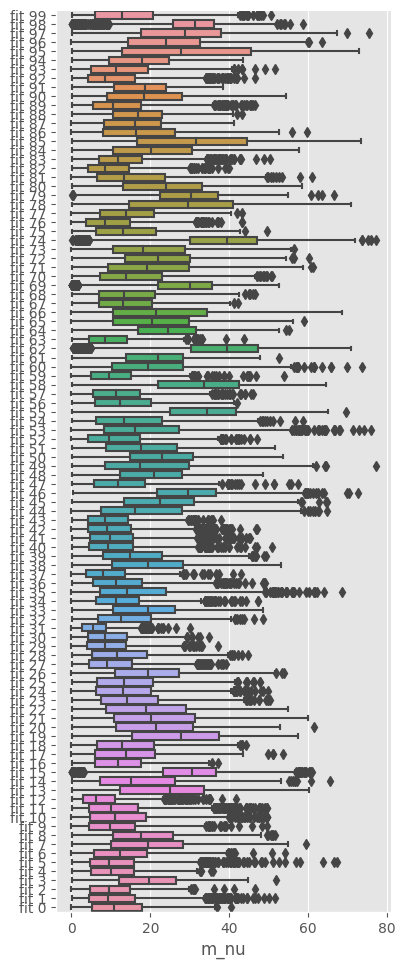

In [54]:
p = FitPlotter(col_wrap=4)
for i in range(len(multi_res[0])):
    p.add_fit(multi_res[0][i], fit_title='fit '+ str(i))
p.cat_plot(parameters='m_nu', fit_titles='all', aspect=0.8)
plt.close()
p.resize(5,12)

In [13]:
stan_file= "Ho_spectrum_SBC.stan"
modelSBC = CmdStanModel(stan_file=stan_file,
                     cpp_options={"STAN_THREADS": True,"jN":4})

In [14]:
def SBC_test(i):
    m = np.random.beta(1,1.05)
    Qp = np.random.normal(2838, 10)
    weight_bkg = np.random.beta(1.5, 20)
    FW = np.random.normal(5, 0.3*2*np.sqrt(2*np.log(2)))
    
    s = SpectraSampler([(HoSpectrum, [m, Qp], A_Ho)], flat_bkg=0, FWHM=FW)
    s.flat_bkg = sum(s.spectrum['HoSpectrum'][s.ROI_idx[0]:s.ROI_idx[1]])*(weight_bkg/(1-weight_bkg))/len(s.ROI_bin_centers)
    s.update_spectrum()
    s.set_measure_time(n_days, n_det=64)
    
    sim_values={
          'Q_sim': Qp,
          'FWHM_sim': FW,
          'bkg_sim': s.weights_in_ROI[1],
          'm_nu_sim': m
    }
    data={'N_bins': len(x)-1, 
          'N_window': n_window,
          'x': x, 
          'counts': s.sample()[0],
          'N_ev': s.n_events,
    }
    data.update(sim_values)
    
    div = True
    while div is True:
        inits={}
        inits['m_nu_red'] = np.random.beta(1,1.05)/3 #the initial value for m_nu shouldn't be too large
        inits['Q'] = np.random.normal(2838, 10)
        inits['bkg'] = np.random.beta(1.5, 20)
        inits['sigma'] = np.random.normal(s.sigma, 0.3)
            
        fit = modelSBC.sample(data,
                           chains=2,
                           iter_warmup=500,
                           iter_sampling=1000,
                           save_warmup=False,
                           show_progress=False,
                           inits=inits,
                           adapt_delta=0.9)
        div = any(fit.divergences)
    return [sim_values, fit]


results = multithreaded_run(SBC_test, [0]*500, 20, filename='data/SBC.pkl')

Number of events in ROI:  3042
Number of events in ROI:  3152


11:56:31 - cmdstanpy - INFO - CmdStan start processing
11:56:31 - cmdstanpy - INFO - CmdStan start processing
11:56:32 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3376


11:56:32 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2731
Number of events in ROI:  2922
Number of events in ROI:  3050


11:56:34 - cmdstanpy - INFO - CmdStan start processing
11:56:34 - cmdstanpy - INFO - CmdStan start processing
11:56:35 - cmdstanpy - INFO - CmdStan start processing
11:56:35 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2715


11:56:36 - cmdstanpy - INFO - CmdStan start processing
11:56:36 - cmdstanpy - INFO - CmdStan start processing
11:56:36 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2821
Number of events in ROI:  2185


11:56:36 - cmdstanpy - INFO - CmdStan start processing
11:56:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3816
Number of events in ROI:  2262
Number of events in ROI:  3008


11:56:38 - cmdstanpy - INFO - CmdStan start processing
11:56:38 - cmdstanpy - INFO - CmdStan start processing
11:56:38 - cmdstanpy - INFO - CmdStan start processing
11:56:38 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2859
Number of events in ROI:  2862


11:56:38 - cmdstanpy - INFO - CmdStan start processing
11:56:38 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2226
Number of events in ROI:  3157


11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3251


11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:39 - cmdstanpy - INFO - CmdStan start processing
11:56:40 - cmdstanpy - INFO - CmdStan start processing
11:56:40 - cmdstanpy - INFO - CmdStan start processing
11:56:40 - cmdstanpy - INFO - CmdStan start processing
11:56:40 - cmdstanpy - INFO - CmdStan start processing
11:56:40 - cmdstanpy - INFO - CmdStan start processing
11:56:40 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2828
Number of events in ROI:  2531
Number of events in ROI:  2723


11:56:52 - cmdstanpy - INFO - CmdStan done processing
11:56:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

11:57:01 - cmdstanpy - INFO - CmdStan done processing
11:57:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

11:57:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

11:57:04 - cmdstanpy - INFO - CmdStan done processing
11:57:04 - cmdstanpy - INFO - CmdStan done processing
11:57:05 - cmdstanpy - INFO - CmdStan done processing
11:57:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	

11:57:08 - cmdstanpy - INFO - CmdStan done processing
11:57:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

11:57:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

11:57:16 - cmdstanpy - INFO - CmdStan done processing
11:57:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3815


11:58:01 - cmdstanpy - INFO - CmdStan start processing
11:58:02 - cmdstanpy - INFO - CmdStan start processing
11:58:16 - cmdstanpy - INFO - CmdStan done processing
11:58:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2262


11:58:24 - cmdstanpy - INFO - CmdStan start processing
11:58:25 - cmdstanpy - INFO - CmdStan start processing
11:58:46 - cmdstanpy - INFO - CmdStan done processing
11:58:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2851


11:58:53 - cmdstanpy - INFO - CmdStan start processing
11:58:54 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2599


11:59:01 - cmdstanpy - INFO - CmdStan start processing
11:59:01 - cmdstanpy - INFO - CmdStan start processing
11:59:12 - cmdstanpy - INFO - CmdStan done processing
11:59:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2580


11:59:24 - cmdstanpy - INFO - CmdStan done processing
11:59:25 - cmdstanpy - INFO - CmdStan start processing
11:59:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

Number of events in ROI:  2574


11:59:37 - cmdstanpy - INFO - CmdStan start processing
11:59:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3150
Number of events in ROI:  2740


11:59:40 - cmdstanpy - INFO - CmdStan start processing
11:59:40 - cmdstanpy - INFO - CmdStan start processing
11:59:40 - cmdstanpy - INFO - CmdStan start processing
11:59:41 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2812
Number of events in ROI:  3349


11:59:43 - cmdstanpy - INFO - CmdStan start processing
11:59:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3073


11:59:43 - cmdstanpy - INFO - CmdStan start processing
11:59:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2913


11:59:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2725


11:59:45 - cmdstanpy - INFO - CmdStan start processing
11:59:46 - cmdstanpy - INFO - CmdStan start processing
11:59:46 - cmdstanpy - INFO - CmdStan start processing
11:59:46 - cmdstanpy - INFO - CmdStan start processing
11:59:47 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2284
Number of events in ROI:  2901
Number of events in ROI:  2906


11:59:49 - cmdstanpy - INFO - CmdStan start processing
11:59:49 - cmdstanpy - INFO - CmdStan start processing
11:59:49 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2974


11:59:49 - cmdstanpy - INFO - CmdStan start processing
11:59:49 - cmdstanpy - INFO - CmdStan start processing
11:59:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, 

Number of events in ROI:  3030
Number of events in ROI:  2691
Number of events in ROI:  2750


11:59:52 - cmdstanpy - INFO - CmdStan start processing
11:59:52 - cmdstanpy - INFO - CmdStan start processing
11:59:53 - cmdstanpy - INFO - CmdStan start processing
11:59:53 - cmdstanpy - INFO - CmdStan start processing
11:59:53 - cmdstanpy - INFO - CmdStan start processing
11:59:53 - cmdstanpy - INFO - CmdStan start processing
11:59:56 - cmdstanpy - INFO - CmdStan done processing
11:59:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line

11:59:58 - cmdstanpy - INFO - CmdStan start processing
11:59:58 - cmdstanpy - INFO - CmdStan start processing
11:59:59 - cmdstanpy - INFO - CmdStan done processing
11:59:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:00:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2899


12:00:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

12:00:10 - cmdstanpy - INFO - CmdStan done processing
12:00:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:00:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2860


12:00:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
Consider re-running with show_console=True if the above output is unclear!
12:00:22 - cmdstanpy - INFO - CmdStan done processing
12:00:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', l

12:00:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
12:00:44 - cmdstanpy - INFO - CmdStan done processing
12:00:44 - cmdstanpy - INFO - CmdStan start processing
12:00:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3852


12:00:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  3204


12:01:00 - cmdstanpy - INFO - CmdStan start processing
12:01:00 - cmdstanpy - INFO - CmdStan start processing
12:01:04 - cmdstanpy - INFO - CmdStan done processing
12:01:04 - cmdstanpy - INFO - CmdStan done processing
12:01:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

Number of events in ROI:  2435


12:01:40 - cmdstanpy - INFO - CmdStan start processing
12:01:41 - cmdstanpy - INFO - CmdStan start processing
12:01:57 - cmdstanpy - INFO - CmdStan done processing
12:01:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2789


12:02:14 - cmdstanpy - INFO - CmdStan start processing
12:02:14 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2661


12:02:19 - cmdstanpy - INFO - CmdStan start processing
12:02:19 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2151


12:02:25 - cmdstanpy - INFO - CmdStan start processing
12:02:26 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3152
Number of events in ROI:  2806


12:02:28 - cmdstanpy - INFO - CmdStan start processing
12:02:29 - cmdstanpy - INFO - CmdStan start processing
12:02:30 - cmdstanpy - INFO - CmdStan start processing
12:02:30 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3072


12:02:33 - cmdstanpy - INFO - CmdStan done processing
12:02:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2521


12:02:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2575


12:02:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3145


12:02:45 - cmdstanpy - INFO - CmdStan start processing
12:02:45 - cmdstanpy - INFO - CmdStan start processing
12:02:46 - cmdstanpy - INFO - CmdStan start processing
12:02:46 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3281
Number of events in ROI:  2872


12:02:48 - cmdstanpy - INFO - CmdStan done processing
12:02:49 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2338
Number of events in ROI:  2769


12:02:49 - cmdstanpy - INFO - CmdStan start processing
12:02:49 - cmdstanpy - INFO - CmdStan start processing
12:02:49 - cmdstanpy - INFO - CmdStan start processing
12:02:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96

Number of events in ROI:  3057


12:02:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2556


12:02:54 - cmdstanpy - INFO - CmdStan start processing
12:02:54 - cmdstanpy - INFO - CmdStan start processing
12:02:54 - cmdstanpy - INFO - CmdStan done processing
12:02:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2209


12:03:02 - cmdstanpy - INFO - CmdStan start processing
12:03:02 - cmdstanpy - INFO - CmdStan start processing
12:03:03 - cmdstanpy - INFO - CmdStan done processing
12:03:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:03:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2331


12:03:11 - cmdstanpy - INFO - CmdStan done processing
12:03:12 - cmdstanpy - INFO - CmdStan done processing
12:03:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, bu

Number of events in ROI:  2404


12:03:18 - cmdstanpy - INFO - CmdStan start processing
12:03:19 - cmdstanpy - INFO - CmdStan start processing
12:03:20 - cmdstanpy - INFO - CmdStan done processing
12:03:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2426


12:03:44 - cmdstanpy - INFO - CmdStan done processing
12:03:44 - cmdstanpy - INFO - CmdStan start processing
12:03:45 - cmdstanpy - INFO - CmdStan done processing
12:03:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)


Number of events in ROI:  3499


12:04:08 - cmdstanpy - INFO - CmdStan start processing
12:04:09 - cmdstanpy - INFO - CmdStan start processing
12:04:10 - cmdstanpy - INFO - CmdStan done processing
12:04:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  3021


12:04:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  3224


12:04:42 - cmdstanpy - INFO - CmdStan start processing
12:04:43 - cmdstanpy - INFO - CmdStan start processing
12:04:50 - cmdstanpy - INFO - CmdStan done processing
12:04:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  3165
Number of events in ROI:  3294
Number of events in ROI:  3154


12:05:15 - cmdstanpy - INFO - CmdStan start processing
12:05:16 - cmdstanpy - INFO - CmdStan start processing
12:05:16 - cmdstanpy - INFO - CmdStan start processing
12:05:16 - cmdstanpy - INFO - CmdStan start processing
12:05:17 - cmdstanpy - INFO - CmdStan start processing
12:05:18 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2885


12:05:21 - cmdstanpy - INFO - CmdStan start processing
12:05:21 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2093


12:05:27 - cmdstanpy - INFO - CmdStan start processing
12:05:28 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2726


12:05:34 - cmdstanpy - INFO - CmdStan start processing
12:05:34 - cmdstanpy - INFO - CmdStan start processing
12:05:34 - cmdstanpy - INFO - CmdStan done processing
12:05:35 - cmdstanpy - INFO - CmdStan done processing
12:05:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

Number of events in ROI:  2604


12:05:39 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2541


12:05:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI: Number of events in ROI:  2952
 2963
Number of events in ROI:  2149


12:05:41 - cmdstanpy - INFO - CmdStan start processing
12:05:41 - cmdstanpy - INFO - CmdStan start processing
12:05:42 - cmdstanpy - INFO - CmdStan start processing
12:05:42 - cmdstanpy - INFO - CmdStan start processing
12:05:42 - cmdstanpy - INFO - CmdStan start processing
12:05:43 - cmdstanpy - INFO - CmdStan start processing
12:05:43 - cmdstanpy - INFO - CmdStan start processing
12:05:43 - cmdstanpy - INFO - CmdStan start processing
12:05:43 - cmdstanpy - INFO - CmdStan start processing
12:05:44 - cmdstanpy - INFO - CmdStan start processing
12:05:47 - cmdstanpy - INFO - CmdStan done processing
12:05:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

Number of events in ROI:  2720


12:05:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
12:05:52 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2344


12:05:53 - cmdstanpy - INFO - CmdStan start processing
12:05:54 - cmdstanpy - INFO - CmdStan start processing
12:05:54 - cmdstanpy - INFO - CmdStan start processing
12:05:54 - cmdstanpy - INFO - CmdStan start processing
12:05:55 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2319


12:05:57 - cmdstanpy - INFO - CmdStan start processing
12:05:57 - cmdstanpy - INFO - CmdStan start processing
12:05:59 - cmdstanpy - INFO - CmdStan done processing
12:06:00 - cmdstanpy - INFO - CmdStan done processing
12:06:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

Number of events in ROI:  2087


12:06:03 - cmdstanpy - INFO - CmdStan done processing
12:06:03 - cmdstanpy - INFO - CmdStan start processing
12:06:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

Number of events in ROI:  3559


12:06:08 - cmdstanpy - INFO - CmdStan start processing
12:06:09 - cmdstanpy - INFO - CmdStan start processing
12:06:10 - cmdstanpy - INFO - CmdStan done processing
12:06:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:06:13 - cmdstanpy - INFO - CmdStan done processing
12:06:14 - cmdstanpy - INFO - CmdStan done processing
12:06:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, bu

12:06:23 - cmdstanpy - INFO - CmdStan done processing
12:06:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:06:27 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2597


12:06:28 - cmdstanpy - INFO - CmdStan done processing
12:06:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2825


12:06:36 - cmdstanpy - INFO - CmdStan start processing
12:06:37 - cmdstanpy - INFO - CmdStan start processing
12:06:51 - cmdstanpy - INFO - CmdStan done processing
12:06:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:06:54 - cmdstanpy - INFO - CmdStan done processing
12:06:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3116
Number of events in ROI:  2465


12:07:11 - cmdstanpy - INFO - CmdStan start processing
12:07:11 - cmdstanpy - INFO - CmdStan start processing
12:07:12 - cmdstanpy - INFO - CmdStan start processing
12:07:13 - cmdstanpy - INFO - CmdStan start processing
12:07:31 - cmdstanpy - INFO - CmdStan done processing
12:07:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2637
Number of events in ROI:  2535


12:07:48 - cmdstanpy - INFO - CmdStan start processing
12:07:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3472


12:07:49 - cmdstanpy - INFO - CmdStan start processing
12:07:50 - cmdstanpy - INFO - CmdStan start processing
12:07:51 - cmdstanpy - INFO - CmdStan start processing
12:07:52 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2916


12:07:55 - cmdstanpy - INFO - CmdStan start processing
12:07:55 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2669


12:08:04 - cmdstanpy - INFO - CmdStan done processing
12:08:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2937


12:08:14 - cmdstanpy - INFO - CmdStan start processing
12:08:15 - cmdstanpy - INFO - CmdStan done processing
12:08:15 - cmdstanpy - INFO - CmdStan start processing
12:08:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2795


12:08:21 - cmdstanpy - INFO - CmdStan start processing
12:08:22 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2393


12:08:27 - cmdstanpy - INFO - CmdStan start processing
12:08:28 - cmdstanpy - INFO - CmdStan start processing
12:08:36 - cmdstanpy - INFO - CmdStan done processing
12:08:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2184


12:08:40 - cmdstanpy - INFO - CmdStan start processing
12:08:40 - cmdstanpy - INFO - CmdStan start processing
12:08:40 - cmdstanpy - INFO - CmdStan done processing
12:08:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI: Number of events in ROI:  2609
 3251
Number of events in ROI:  2847


12:08:42 - cmdstanpy - INFO - CmdStan start processing
12:08:43 - cmdstanpy - INFO - CmdStan done processing
12:08:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
12:08:43 - cmdstanpy - INFO - CmdStan start processing
12:08:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson

Number of events in ROI:  3444


12:08:51 - cmdstanpy - INFO - CmdStan start processing
12:08:52 - cmdstanpy - INFO - CmdStan start processing
12:08:54 - cmdstanpy - INFO - CmdStan done processing
12:08:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2920


12:08:57 - cmdstanpy - INFO - CmdStan done processing
12:08:58 - cmdstanpy - INFO - CmdStan start processing
12:08:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

12:09:04 - cmdstanpy - INFO - CmdStan done processing
12:09:04 - cmdstanpy - INFO - CmdStan done processing
12:09:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, bu

Number of events in ROI:  2534


12:09:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2924
Number of events in ROI:  2974


12:09:12 - cmdstanpy - INFO - CmdStan start processing
12:09:12 - cmdstanpy - INFO - CmdStan start processing
12:09:12 - cmdstanpy - INFO - CmdStan done processing
12:09:13 - cmdstanpy - INFO - CmdStan start processing
12:09:13 - cmdstanpy - INFO - CmdStan start processing
12:09:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  3047


12:09:15 - cmdstanpy - INFO - CmdStan start processing
12:09:16 - cmdstanpy - INFO - CmdStan start processing
12:09:17 - cmdstanpy - INFO - CmdStan done processing
12:09:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:09:32 - cmdstanpy - INFO - CmdStan done processing
12:09:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3300
Number of events in ROI:  3421


12:09:57 - cmdstanpy - INFO - CmdStan start processing
12:09:58 - cmdstanpy - INFO - CmdStan start processing
12:09:58 - cmdstanpy - INFO - CmdStan start processing
12:10:00 - cmdstanpy - INFO - CmdStan start processing
12:10:16 - cmdstanpy - INFO - CmdStan done processing
12:10:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2892


12:10:25 - cmdstanpy - INFO - CmdStan start processing
12:10:25 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2602


12:10:31 - cmdstanpy - INFO - CmdStan start processing
12:10:32 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2633
Number of events in ROI:  3224


12:10:37 - cmdstanpy - INFO - CmdStan start processing
12:10:37 - cmdstanpy - INFO - CmdStan start processing
12:10:40 - cmdstanpy - INFO - CmdStan start processing
12:10:41 - cmdstanpy - INFO - CmdStan start processing
12:10:46 - cmdstanpy - INFO - CmdStan done processing
12:10:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2638


12:10:54 - cmdstanpy - INFO - CmdStan start processing
12:10:55 - cmdstanpy - INFO - CmdStan start processing
12:10:58 - cmdstanpy - INFO - CmdStan done processing
12:10:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2404


12:11:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
12:11:08 - cmdstanpy - INFO - CmdStan start processing
12:11:08 - cmdstanpy - INFO - CmdStan start processing
12:11:10 - cmdstanpy - INFO - CmdStan start processing
12:11:11 - cmdstanpy - INFO - CmdStan start processing
12:11:15 - cmdstanpy - INFO - CmdStan done processing
12:11:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/bayn

Number of events in ROI:  2350
Number of events in ROI:  2902


12:11:25 - cmdstanpy - INFO - CmdStan start processing
12:11:25 - cmdstanpy - INFO - CmdStan start processing
12:11:26 - cmdstanpy - INFO - CmdStan start processing
12:11:27 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2965


12:11:33 - cmdstanpy - INFO - CmdStan start processing
12:11:34 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3483


12:11:34 - cmdstanpy - INFO - CmdStan done processing
12:11:35 - cmdstanpy - INFO - CmdStan done processing
12:11:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, bu

Number of events in ROI:  2800
Number of events in ROI:  3290


12:11:36 - cmdstanpy - INFO - CmdStan start processing
12:11:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2495


12:11:37 - cmdstanpy - INFO - CmdStan start processing
12:11:37 - cmdstanpy - INFO - CmdStan start processing
12:11:38 - cmdstanpy - INFO - CmdStan start processing
12:11:38 - cmdstanpy - INFO - CmdStan start processing
12:11:39 - cmdstanpy - INFO - CmdStan start processing
12:11:39 - cmdstanpy - INFO - CmdStan start processing
12:11:47 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2981


12:11:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  3661


12:11:50 - cmdstanpy - INFO - CmdStan done processing
12:11:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2731


12:11:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI: Number of events in ROI:  2790
 2746


12:11:51 - cmdstanpy - INFO - CmdStan start processing
12:11:51 - cmdstanpy - INFO - CmdStan start processing
12:11:51 - cmdstanpy - INFO - CmdStan start processing
12:11:52 - cmdstanpy - INFO - CmdStan start processing
12:11:52 - cmdstanpy - INFO - CmdStan start processing
12:11:52 - cmdstanpy - INFO - CmdStan start processing
12:11:52 - cmdstanpy - INFO - CmdStan start processing
12:11:53 - cmdstanpy - INFO - CmdStan done processing
12:11:53 - cmdstanpy - INFO - CmdStan start processing
12:11:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, bu

12:12:02 - cmdstanpy - INFO - CmdStan done processing
12:12:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:12:07 - cmdstanpy - INFO - CmdStan done processing
12:12:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:12:11 - cmdstanpy - INFO - CmdStan done processing
12:12:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3085


12:12:26 - cmdstanpy - INFO - CmdStan start processing
12:12:27 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2772


12:12:31 - cmdstanpy - INFO - CmdStan start processing
12:12:32 - cmdstanpy - INFO - CmdStan start processing
12:12:43 - cmdstanpy - INFO - CmdStan done processing
12:12:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2838


12:13:06 - cmdstanpy - INFO - CmdStan start processing
12:13:07 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3133


12:13:12 - cmdstanpy - INFO - CmdStan start processing
12:13:14 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3360


12:13:16 - cmdstanpy - INFO - CmdStan start processing
12:13:17 - cmdstanpy - INFO - CmdStan start processing
12:13:28 - cmdstanpy - INFO - CmdStan done processing
12:13:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  3135


12:13:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2381


12:13:52 - cmdstanpy - INFO - CmdStan start processing
12:13:52 - cmdstanpy - INFO - CmdStan start processing
12:14:00 - cmdstanpy - INFO - CmdStan done processing
12:14:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  3202


12:14:04 - cmdstanpy - INFO - CmdStan start processing
12:14:06 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2551


12:14:14 - cmdstanpy - INFO - CmdStan start processing
12:14:14 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3487
Number of events in ROI:  2655


12:14:22 - cmdstanpy - INFO - CmdStan done processing
12:14:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3176


12:14:23 - cmdstanpy - INFO - CmdStan start processing
12:14:24 - cmdstanpy - INFO - CmdStan start processing
12:14:24 - cmdstanpy - INFO - CmdStan start processing
12:14:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96

Number of events in ROI:  2866
Number of events in ROI:  3185


12:14:35 - cmdstanpy - INFO - CmdStan start processing
12:14:35 - cmdstanpy - INFO - CmdStan start processing
12:14:36 - cmdstanpy - INFO - CmdStan start processing
12:14:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3897
Number of events in ROI:  2594
Number of events in ROI:  2606


12:14:39 - cmdstanpy - INFO - CmdStan start processing
12:14:39 - cmdstanpy - INFO - CmdStan start processing
12:14:40 - cmdstanpy - INFO - CmdStan start processing
12:14:40 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  1994


12:14:41 - cmdstanpy - INFO - CmdStan done processing
12:14:41 - cmdstanpy - INFO - CmdStan start processing
12:14:41 - cmdstanpy - INFO - CmdStan start processing
12:14:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2454


12:14:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  3224


12:14:47 - cmdstanpy - INFO - CmdStan done processing
12:14:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:14:59 - cmdstanpy - INFO - CmdStan done processing
12:14:59 - cmdstanpy - INFO - CmdStan done processing
12:14:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, bu

Number of events in ROI:  2894


12:15:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
Consider re-running with show_console=True if the above output is unclear!
12:15:02 - cmdstanpy - INFO - CmdStan start processing
12:15:02 - cmdstanpy - INFO - Cmd

Number of events in ROI:  2560


12:15:12 - cmdstanpy - INFO - CmdStan start processing
12:15:12 - cmdstanpy - INFO - CmdStan start processing
12:15:13 - cmdstanpy - INFO - CmdStan done processing
12:15:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:15:19 - cmdstanpy - INFO - CmdStan done processing
12:15:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2772


12:15:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  1983


12:15:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3042


12:15:52 - cmdstanpy - INFO - CmdStan start processing
12:15:52 - cmdstanpy - INFO - CmdStan start processing
12:15:53 - cmdstanpy - INFO - CmdStan start processing
12:15:54 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3186


12:16:10 - cmdstanpy - INFO - CmdStan done processing
12:16:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI: 

12:16:33 - cmdstanpy - INFO - CmdStan done processing


 2476


12:16:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2954


12:16:43 - cmdstanpy - INFO - CmdStan start processing
12:16:43 - cmdstanpy - INFO - CmdStan start processing
12:16:55 - cmdstanpy - INFO - CmdStan done processing
12:16:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2310


12:16:58 - cmdstanpy - INFO - CmdStan start processing
12:16:59 - cmdstanpy - INFO - CmdStan start processing
12:16:59 - cmdstanpy - INFO - CmdStan done processing
12:17:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2857
Number of events in ROI:  2474


12:17:03 - cmdstanpy - INFO - CmdStan start processing
12:17:04 - cmdstanpy - INFO - CmdStan start processing
12:17:04 - cmdstanpy - INFO - CmdStan start processing
12:17:05 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2372


12:17:18 - cmdstanpy - INFO - CmdStan start processing
12:17:18 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2527


12:17:21 - cmdstanpy - INFO - CmdStan done processing
12:17:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2304
Number of events in ROI:  2758
Number of events in ROI:  2495


12:17:25 - cmdstanpy - INFO - CmdStan start processing
12:17:25 - cmdstanpy - INFO - CmdStan start processing
12:17:25 - cmdstanpy - INFO - CmdStan done processing
12:17:26 - cmdstanpy - INFO - CmdStan start processing
12:17:26 - cmdstanpy - INFO - CmdStan start processing
12:17:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2774


12:17:33 - cmdstanpy - INFO - CmdStan done processing
12:17:33 - cmdstanpy - INFO - CmdStan start processing
12:17:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

Number of events in ROI:  3037
Number of events in ROI:  3051


12:17:39 - cmdstanpy - INFO - CmdStan start processing
12:17:40 - cmdstanpy - INFO - CmdStan start processing
12:17:41 - cmdstanpy - INFO - CmdStan start processing
12:17:41 - cmdstanpy - INFO - CmdStan done processing
12:17:41 - cmdstanpy - INFO - CmdStan start processing
12:17:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  3538


12:17:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2867


12:17:44 - cmdstanpy - INFO - CmdStan start processing
12:17:44 - cmdstanpy - INFO - CmdStan start processing
12:17:45 - cmdstanpy - INFO - CmdStan start processing
12:17:45 - cmdstanpy - INFO - CmdStan done processing
12:17:45 - cmdstanpy - INFO - CmdStan start processing
12:17:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2704


12:17:50 - cmdstanpy - INFO - CmdStan start processing
12:17:50 - cmdstanpy - INFO - CmdStan start processing
12:17:50 - cmdstanpy - INFO - CmdStan done processing
12:17:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:17:59 - cmdstanpy - INFO - CmdStan done processing
12:17:59 - cmdstanpy - INFO - CmdStan done processing
12:18:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, bu

12:18:01 - cmdstanpy - INFO - CmdStan done processing
12:18:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2357


12:18:30 - cmdstanpy - INFO - CmdStan start processing
12:18:31 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3115


12:18:35 - cmdstanpy - INFO - CmdStan start processing
12:18:36 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3492


12:18:49 - cmdstanpy - INFO - CmdStan start processing
12:18:49 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2897


12:18:54 - cmdstanpy - INFO - CmdStan done processing
12:18:54 - cmdstanpy - INFO - CmdStan start processing
12:18:55 - cmdstanpy - INFO - CmdStan start processing
12:18:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2969


12:19:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2567


12:19:21 - cmdstanpy - INFO - CmdStan start processing
12:19:22 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3674


12:19:30 - cmdstanpy - INFO - CmdStan start processing
12:19:30 - cmdstanpy - INFO - CmdStan start processing
12:19:31 - cmdstanpy - INFO - CmdStan done processing
12:19:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2171


12:19:46 - cmdstanpy - INFO - CmdStan done processing
12:19:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3517


12:20:03 - cmdstanpy - INFO - CmdStan start processing
12:20:04 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3933


12:20:10 - cmdstanpy - INFO - CmdStan start processing
12:20:10 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3246
Number of events in ROI:  2685
Number of events in ROI:  2805
Number of events in ROI:  3233


12:20:17 - cmdstanpy - INFO - CmdStan start processing
12:20:17 - cmdstanpy - INFO - CmdStan start processing
12:20:17 - cmdstanpy - INFO - CmdStan start processing
12:20:18 - cmdstanpy - INFO - CmdStan start processing
12:20:18 - cmdstanpy - INFO - CmdStan done processing
12:20:18 - cmdstanpy - INFO - CmdStan start processing
12:20:18 - cmdstanpy - INFO - CmdStan start processing
12:20:18 - cmdstanpy - INFO - CmdStan start processing
12:20:19 - cmdstanpy - INFO - CmdStan done processing
12:20:19 - cmdstanpy - INFO - CmdStan start processing
12:20:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	

Number of events in ROI:  3772
Number of events in ROI:  2845


12:20:28 - cmdstanpy - INFO - CmdStan start processing
12:20:29 - cmdstanpy - INFO - CmdStan start processing
12:20:29 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3342


12:20:29 - cmdstanpy - INFO - CmdStan start processing
12:20:31 - cmdstanpy - INFO - CmdStan start processing
12:20:32 - cmdstanpy - INFO - CmdStan start processing
12:20:33 - cmdstanpy - INFO - CmdStan done processing
12:20:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum

Number of events in ROI:  2833


12:20:36 - cmdstanpy - INFO - CmdStan start processing
12:20:36 - cmdstanpy - INFO - CmdStan done processing
12:20:36 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2153


12:20:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

12:20:40 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  3451


12:20:40 - cmdstanpy - INFO - CmdStan done processing
12:20:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:20:52 - cmdstanpy - INFO - CmdStan done processing
12:20:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:21:03 - cmdstanpy - INFO - CmdStan done processing
12:21:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2801


12:21:11 - cmdstanpy - INFO - CmdStan start processing
12:21:12 - cmdstanpy - INFO - CmdStan start processing
12:21:15 - cmdstanpy - INFO - CmdStan start processing
12:21:16 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2779


12:21:33 - cmdstanpy - INFO - CmdStan start processing
12:21:34 - cmdstanpy - INFO - CmdStan start processing
12:21:35 - cmdstanpy - INFO - CmdStan done processing
12:21:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2616


12:21:42 - cmdstanpy - INFO - CmdStan start processing
12:21:42 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2144


12:21:44 - cmdstanpy - INFO - CmdStan start processing
12:21:44 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2551


12:21:54 - cmdstanpy - INFO - CmdStan done processing
12:21:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2416


12:21:58 - cmdstanpy - INFO - CmdStan start processing
12:21:59 - cmdstanpy - INFO - CmdStan start processing
12:21:59 - cmdstanpy - INFO - CmdStan done processing
12:21:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  3466


12:22:09 - cmdstanpy - INFO - CmdStan start processing
12:22:09 - cmdstanpy - INFO - CmdStan start processing
12:22:11 - cmdstanpy - INFO - CmdStan done processing
12:22:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:22:27 - cmdstanpy - INFO - CmdStan done processing
12:22:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3091


12:22:34 - cmdstanpy - INFO - CmdStan start processing
12:22:35 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3505


12:22:44 - cmdstanpy - INFO - CmdStan start processing
12:22:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3030


12:22:54 - cmdstanpy - INFO - CmdStan start processing
12:22:54 - cmdstanpy - INFO - CmdStan start processing
12:22:58 - cmdstanpy - INFO - CmdStan done processing
12:22:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2512


12:23:03 - cmdstanpy - INFO - CmdStan start processing
12:23:03 - cmdstanpy - INFO - CmdStan start processing
12:23:05 - cmdstanpy - INFO - CmdStan done processing
12:23:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2712
Number of events in ROI:  2466


12:23:07 - cmdstanpy - INFO - CmdStan start processing
12:23:08 - cmdstanpy - INFO - CmdStan start processing
12:23:09 - cmdstanpy - INFO - CmdStan start processing
12:23:10 - cmdstanpy - INFO - CmdStan start processing
12:23:10 - cmdstanpy - INFO - CmdStan done processing
12:23:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2546


12:23:13 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2725


12:23:14 - cmdstanpy - INFO - CmdStan start processing
12:23:15 - cmdstanpy - INFO - CmdStan start processing
12:23:16 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2572


12:23:19 - cmdstanpy - INFO - CmdStan done processing
12:23:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2688


12:23:23 - cmdstanpy - INFO - CmdStan start processing
12:23:23 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2399


12:23:25 - cmdstanpy - INFO - CmdStan start processing
12:23:26 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2647


12:23:30 - cmdstanpy - INFO - CmdStan done processing
12:23:31 - cmdstanpy - INFO - CmdStan start processing
12:23:31 - cmdstanpy - INFO - CmdStan done processing
12:23:31 - cmdstanpy - INFO - CmdStan start processing
12:23:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

12:23:32 - cmdstanpy - INFO - CmdStan done processing
12:23:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:23:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
12:23:40 - cmdstanpy - INFO - CmdStan start processing
12:23:40 - cmdstanpy - INFO - CmdStan done processing
12:23:40 - cmdstanpy - INFO - CmdStan start processing
12:23:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson

Number of events in ROI:  3225


12:23:52 - cmdstanpy - INFO - CmdStan start processing
12:23:53 - cmdstanpy - INFO - CmdStan start processing
12:23:58 - cmdstanpy - INFO - CmdStan done processing
12:23:59 - cmdstanpy - INFO - CmdStan done processing
12:23:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

Number of events in ROI:  2498


12:24:07 - cmdstanpy - INFO - CmdStan start processing
12:24:08 - cmdstanpy - INFO - CmdStan start processing
12:24:11 - cmdstanpy - INFO - CmdStan done processing
12:24:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2543
Number of events in ROI:  1933


12:24:20 - cmdstanpy - INFO - CmdStan start processing
12:24:20 - cmdstanpy - INFO - CmdStan start processing
12:24:22 - cmdstanpy - INFO - CmdStan start processing
12:24:24 - cmdstanpy - INFO - CmdStan start processing
12:24:25 - cmdstanpy - INFO - CmdStan done processing
12:24:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2413


12:24:37 - cmdstanpy - INFO - CmdStan start processing
12:24:38 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2817


12:24:43 - cmdstanpy - INFO - CmdStan start processing
12:24:44 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2715
Number of events in ROI:  2631


12:24:45 - cmdstanpy - INFO - CmdStan start processing
12:24:46 - cmdstanpy - INFO - CmdStan start processing
12:24:47 - cmdstanpy - INFO - CmdStan start processing
12:24:47 - cmdstanpy - INFO - CmdStan start processing
12:24:50 - cmdstanpy - INFO - CmdStan done processing
12:24:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

12:24:58 - cmdstanpy - INFO - CmdStan done processing
12:24:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
Consider re-running with show_console=True if the above output is unclear!
12:25:02 - cmdstanpy - INFO - CmdStan done processing
12:25:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bay

Number of events in ROI:  3307


12:25:19 - cmdstanpy - INFO - CmdStan start processing
12:25:20 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2902


12:25:23 - cmdstanpy - INFO - CmdStan start processing
12:25:24 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3350


12:25:35 - cmdstanpy - INFO - CmdStan start processing
12:25:35 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI: 

12:25:36 - cmdstanpy - INFO - CmdStan done processing


 2568


12:25:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

12:25:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


Number of events in ROI:  2347
Number of events in ROI:  2774


12:25:59 - cmdstanpy - INFO - CmdStan start processing
12:25:59 - cmdstanpy - INFO - CmdStan start processing
12:25:59 - cmdstanpy - INFO - CmdStan start processing
12:25:59 - cmdstanpy - INFO - CmdStan done processing
12:26:00 - cmdstanpy - INFO - CmdStan start processing
12:26:01 - cmdstanpy - INFO - CmdStan start processing
12:26:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: R

Number of events in ROI:  2677
Number of events in ROI:  2406


12:26:03 - cmdstanpy - INFO - CmdStan start processing
12:26:04 - cmdstanpy - INFO - CmdStan start processing
12:26:05 - cmdstanpy - INFO - CmdStan start processing
12:26:05 - cmdstanpy - INFO - CmdStan start processing
12:26:06 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2965


12:26:11 - cmdstanpy - INFO - CmdStan start processing
12:26:12 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3543


12:26:18 - cmdstanpy - INFO - CmdStan start processing
12:26:19 - cmdstanpy - INFO - CmdStan start processing
12:26:19 - cmdstanpy - INFO - CmdStan done processing
12:26:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2829


12:26:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2401


12:26:25 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2330


12:26:25 - cmdstanpy - INFO - CmdStan start processing
12:26:26 - cmdstanpy - INFO - CmdStan start processing
12:26:26 - cmdstanpy - INFO - CmdStan start processing
12:26:27 - cmdstanpy - INFO - CmdStan start processing
12:26:27 - cmdstanpy - INFO - CmdStan start processing
12:26:30 - cmdstanpy - INFO - CmdStan done processing
12:26:30 - cmdstanpy - INFO - CmdStan done processing
12:26:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 

12:26:37 - cmdstanpy - INFO - CmdStan done processing
12:26:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3056


12:26:48 - cmdstanpy - INFO - CmdStan done processing
12:26:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2955


12:27:12 - cmdstanpy - INFO - CmdStan done processing
12:27:12 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2347


12:27:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2635


12:27:16 - cmdstanpy - INFO - CmdStan start processing
12:27:18 - cmdstanpy - INFO - CmdStan start processing
12:27:19 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3276


12:27:24 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2683


12:27:24 - cmdstanpy - INFO - CmdStan start processing
12:27:25 - cmdstanpy - INFO - CmdStan start processing
12:27:26 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2953


12:27:31 - cmdstanpy - INFO - CmdStan done processing
12:27:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:27:42 - cmdstanpy - INFO - CmdStan done processing
12:27:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2709


12:27:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2321


12:28:09 - cmdstanpy - INFO - CmdStan start processing
12:28:09 - cmdstanpy - INFO - CmdStan start processing
12:28:18 - cmdstanpy - INFO - CmdStan done processing
12:28:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2834


12:28:23 - cmdstanpy - INFO - CmdStan start processing
12:28:23 - cmdstanpy - INFO - CmdStan start processing
12:28:23 - cmdstanpy - INFO - CmdStan start processing
12:28:24 - cmdstanpy - INFO - CmdStan start processing
12:28:36 - cmdstanpy - INFO - CmdStan done processing
12:28:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  3109


12:28:43 - cmdstanpy - INFO - CmdStan done processing
12:28:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2137


12:28:45 - cmdstanpy - INFO - CmdStan start processing
12:28:46 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2731


12:28:47 - cmdstanpy - INFO - CmdStan start processing
12:28:47 - cmdstanpy - INFO - CmdStan start processing
12:28:48 - cmdstanpy - INFO - CmdStan done processing
12:28:48 - cmdstanpy - INFO - CmdStan start processing
12:28:49 - cmdstanpy - INFO - CmdStan start processing
12:28:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2686


12:28:59 - cmdstanpy - INFO - CmdStan start processing
12:29:00 - cmdstanpy - INFO - CmdStan start processing
12:29:01 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2606


12:29:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  3064


12:29:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2786


12:29:10 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2972


12:29:11 - cmdstanpy - INFO - CmdStan start processing
12:29:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
12:29:12 - cmdstanpy - INFO - CmdStan start processing
12:29:13 - cmdstanpy - INFO - CmdStan start processing
12:29:13 - cmdstanpy - INFO - CmdStan start processing
12:29:14 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2584


12:29:16 - cmdstanpy - INFO - CmdStan start processing
12:29:17 - cmdstanpy - INFO - CmdStan start processing
12:29:17 - cmdstanpy - INFO - CmdStan done processing
12:29:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  3244


12:29:20 - cmdstanpy - INFO - CmdStan done processing
12:29:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:29:31 - cmdstanpy - INFO - CmdStan done processing
12:29:31 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  3023


12:29:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

12:29:33 - cmdstanpy - INFO - CmdStan start processing
12:29:34 - cmdstanpy - INFO - CmdStan start processing
12:29:39 - cmdstanpy - INFO - CmdStan done processing
12:29:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2309


12:29:49 - cmdstanpy - INFO - CmdStan done processing
12:29:49 - cmdstanpy - INFO - CmdStan start processing
12:29:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

Number of events in ROI:  3013


12:29:54 - cmdstanpy - INFO - CmdStan start processing
12:29:55 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3273
Number of events in ROI:  2744


12:29:57 - cmdstanpy - INFO - CmdStan start processing
12:29:57 - cmdstanpy - INFO - CmdStan start processing
12:29:58 - cmdstanpy - INFO - CmdStan start processing
12:29:58 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2994


12:30:00 - cmdstanpy - INFO - CmdStan done processing
12:30:00 - cmdstanpy - INFO - CmdStan start processing
12:30:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

Number of events in ROI:  2961


12:30:07 - cmdstanpy - INFO - CmdStan start processing
12:30:07 - cmdstanpy - INFO - CmdStan start processing
12:30:12 - cmdstanpy - INFO - CmdStan done processing
12:30:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:30:17 - cmdstanpy - INFO - CmdStan done processing
12:30:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:30:34 - cmdstanpy - INFO - CmdStan done processing
12:30:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2802
Number of events in ROI:  2636


12:30:49 - cmdstanpy - INFO - CmdStan start processing
12:30:50 - cmdstanpy - INFO - CmdStan start processing
12:30:50 - cmdstanpy - INFO - CmdStan start processing
12:30:51 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3230


12:30:57 - cmdstanpy - INFO - CmdStan start processing
12:30:58 - cmdstanpy - INFO - CmdStan start processing
12:31:13 - cmdstanpy - INFO - CmdStan done processing
12:31:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2126


12:31:16 - cmdstanpy - INFO - CmdStan start processing
12:31:16 - cmdstanpy - INFO - CmdStan start processing
12:31:17 - cmdstanpy - INFO - CmdStan done processing
12:31:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2483


12:31:42 - cmdstanpy - INFO - CmdStan done processing
12:31:43 - cmdstanpy - INFO - CmdStan start processing
12:31:43 - cmdstanpy - INFO - CmdStan start processing
12:31:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2466
Number of events in ROI:  2720
Number of events in ROI:  2665


12:31:51 - cmdstanpy - INFO - CmdStan start processing
12:31:51 - cmdstanpy - INFO - CmdStan start processing
12:31:52 - cmdstanpy - INFO - CmdStan start processing
12:31:52 - cmdstanpy - INFO - CmdStan start processing
12:31:53 - cmdstanpy - INFO - CmdStan start processing
12:31:54 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2818
Number of events in ROI:  2714


12:31:56 - cmdstanpy - INFO - CmdStan start processing
12:31:57 - cmdstanpy - INFO - CmdStan start processing
12:31:57 - cmdstanpy - INFO - CmdStan start processing
12:31:58 - cmdstanpy - INFO - CmdStan start processing
12:32:09 - cmdstanpy - INFO - CmdStan done processing
12:32:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2898


12:32:12 - cmdstanpy - INFO - CmdStan done processing
12:32:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2472


12:32:13 - cmdstanpy - INFO - CmdStan start processing
12:32:13 - cmdstanpy - INFO - CmdStan done processing
12:32:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

12:32:16 - cmdstanpy - INFO - CmdStan start processing
12:32:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bay

Number of events in ROI:  2855


12:32:21 - cmdstanpy - INFO - CmdStan start processing
12:32:22 - cmdstanpy - INFO - CmdStan start processing
12:32:31 - cmdstanpy - INFO - CmdStan done processing
12:32:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI: Number of events in ROI:  2328
 2046
Number of events in ROI:  2621


12:32:41 - cmdstanpy - INFO - CmdStan start processing
12:32:42 - cmdstanpy - INFO - CmdStan start processing
12:32:42 - cmdstanpy - INFO - CmdStan start processing
12:32:42 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2697
Number of events in ROI:  3068


12:32:43 - cmdstanpy - INFO - CmdStan start processing
12:32:43 - cmdstanpy - INFO - CmdStan start processing
12:32:44 - cmdstanpy - INFO - CmdStan start processing
12:32:44 - cmdstanpy - INFO - CmdStan done processing
12:32:45 - cmdstanpy - INFO - CmdStan start processing
12:32:45 - cmdstanpy - INFO - CmdStan start processing
12:32:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: R

Number of events in ROI:  2809


12:32:52 - cmdstanpy - INFO - CmdStan start processing
12:32:53 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3029


12:32:59 - cmdstanpy - INFO - CmdStan start processing
12:32:59 - cmdstanpy - INFO - CmdStan start processing
12:33:04 - cmdstanpy - INFO - CmdStan done processing
12:33:05 - cmdstanpy - INFO - CmdStan done processing
12:33:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

12:33:09 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
12:33:12 - cmdstanpy - INFO - CmdStan start processing
12:33:12 - cmdstanpy - INFO - CmdStan done processing
12:33:13 - cmdstanpy - INFO - CmdStan start processing
12:33:13 - cmdstanpy - INFO - CmdStan done processing
12:33:14 - cmdstanpy - INFO - CmdStan done processing
12:33:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes

12:33:14 - cmdstanpy - INFO - CmdStan done processing
12:33:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2665


12:33:33 - cmdstanpy - INFO - CmdStan start processing
12:33:34 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2948


12:33:36 - cmdstanpy - INFO - CmdStan start processing
12:33:36 - cmdstanpy - INFO - CmdStan done processing
12:33:38 - cmdstanpy - INFO - CmdStan start processing
12:33:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  3793


12:33:46 - cmdstanpy - INFO - CmdStan start processing
12:33:47 - cmdstanpy - INFO - CmdStan start processing
12:33:47 - cmdstanpy - INFO - CmdStan start processing
12:33:48 - cmdstanpy - INFO - CmdStan start processing
12:33:49 - cmdstanpy - INFO - CmdStan done processing
12:33:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2562


12:33:57 - cmdstanpy - INFO - CmdStan start processing
12:33:58 - cmdstanpy - INFO - CmdStan start processing
12:33:59 - cmdstanpy - INFO - CmdStan done processing
12:34:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:34:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
12:34:28 - cmdstanpy - INFO - CmdStan start processing
12:34:28 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2199
Number of events in ROI:  2924
Number of events in ROI:  3129


12:34:34 - cmdstanpy - INFO - CmdStan start processing
12:34:34 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2787
Number of events in ROI:  2876


12:34:34 - cmdstanpy - INFO - CmdStan start processing
12:34:35 - cmdstanpy - INFO - CmdStan start processing
12:34:35 - cmdstanpy - INFO - CmdStan start processing
12:34:35 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2766


12:34:36 - cmdstanpy - INFO - CmdStan start processing
12:34:36 - cmdstanpy - INFO - CmdStan start processing
12:34:36 - cmdstanpy - INFO - CmdStan start processing
12:34:37 - cmdstanpy - INFO - CmdStan start processing
12:34:39 - cmdstanpy - INFO - CmdStan start processing
12:34:39 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3090
Number of events in ROI:  2297


12:34:49 - cmdstanpy - INFO - CmdStan start processing
12:34:49 - cmdstanpy - INFO - CmdStan start processing
12:34:50 - cmdstanpy - INFO - CmdStan start processing
12:34:51 - cmdstanpy - INFO - CmdStan start processing
12:34:52 - cmdstanpy - INFO - CmdStan done processing
12:34:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

12:34:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

12:35:03 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  3023


12:35:04 - cmdstanpy - INFO - CmdStan done processing
12:35:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2649


12:35:23 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2195


12:35:24 - cmdstanpy - INFO - CmdStan start processing
12:35:25 - cmdstanpy - INFO - CmdStan done processing
12:35:25 - cmdstanpy - INFO - CmdStan start processing
12:35:26 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2962


12:35:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2901


12:35:30 - cmdstanpy - INFO - CmdStan start processing
12:35:31 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2616


12:35:35 - cmdstanpy - INFO - CmdStan start processing
12:35:35 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3163


12:35:39 - cmdstanpy - INFO - CmdStan start processing
12:35:40 - cmdstanpy - INFO - CmdStan start processing
12:35:41 - cmdstanpy - INFO - CmdStan done processing
12:35:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:35:44 - cmdstanpy - INFO - CmdStan done processing
12:35:45 - cmdstanpy - INFO - CmdStan done processing
12:35:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, bu

12:35:58 - cmdstanpy - INFO - CmdStan done processing
12:35:59 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2406


12:35:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  3040


12:36:13 - cmdstanpy - INFO - CmdStan start processing
12:36:13 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3408


12:36:22 - cmdstanpy - INFO - CmdStan start processing
12:36:23 - cmdstanpy - INFO - CmdStan done processing
12:36:23 - cmdstanpy - INFO - CmdStan start processing
12:36:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2796


12:36:27 - cmdstanpy - INFO - CmdStan start processing
12:36:28 - cmdstanpy - INFO - CmdStan start processing
12:36:35 - cmdstanpy - INFO - CmdStan done processing
12:36:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2347


12:37:17 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3185


12:37:18 - cmdstanpy - INFO - CmdStan start processing
12:37:19 - cmdstanpy - INFO - CmdStan start processing
12:37:20 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2126
Number of events in ROI:  2381


12:37:23 - cmdstanpy - INFO - CmdStan start processing
12:37:23 - cmdstanpy - INFO - CmdStan start processing
12:37:23 - cmdstanpy - INFO - CmdStan start processing
12:37:24 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2854
Number of events in ROI:  2769


12:37:27 - cmdstanpy - INFO - CmdStan start processing
12:37:28 - cmdstanpy - INFO - CmdStan start processing
12:37:29 - cmdstanpy - INFO - CmdStan start processing
12:37:30 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3175


12:37:35 - cmdstanpy - INFO - CmdStan start processing
12:37:35 - cmdstanpy - INFO - CmdStan start processing
12:37:37 - cmdstanpy - INFO - CmdStan done processing
12:37:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:37:42 - cmdstanpy - INFO - CmdStan done processing
12:37:43 - cmdstanpy - INFO - CmdStan start processing
12:37:43 - cmdstanpy - INFO - CmdStan start processing
12:37:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2788


12:37:47 - cmdstanpy - INFO - CmdStan start processing
12:37:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  1966


12:37:49 - cmdstanpy - INFO - CmdStan done processing
12:37:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:37:54 - cmdstanpy - INFO - CmdStan done processing
12:37:55 - cmdstanpy - INFO - CmdStan done processing
12:37:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, bu

Number of events in ROI:  2880


12:38:03 - cmdstanpy - INFO - CmdStan done processing
12:38:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2727
Number of events in ROI:  3083


12:38:10 - cmdstanpy - INFO - CmdStan start processing
12:38:11 - cmdstanpy - INFO - CmdStan start processing
12:38:11 - cmdstanpy - INFO - CmdStan start processing
12:38:11 - cmdstanpy - INFO - CmdStan start processing
12:38:11 - cmdstanpy - INFO - CmdStan start processing
12:38:12 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3140


12:38:15 - cmdstanpy - INFO - CmdStan start processing
12:38:15 - cmdstanpy - INFO - CmdStan start processing
12:38:17 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2209


12:38:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2936


12:38:21 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3052


12:38:22 - cmdstanpy - INFO - CmdStan start processing
12:38:23 - cmdstanpy - INFO - CmdStan done processing
12:38:23 - cmdstanpy - INFO - CmdStan start processing
12:38:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:38:32 - cmdstanpy - INFO - CmdStan done processing
12:38:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:38:36 - cmdstanpy - INFO - CmdStan start processing
12:38:36 - cmdstanpy - INFO - CmdStan start processing
12:38:39 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2388


12:38:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2934


12:38:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2727


12:38:46 - cmdstanpy - INFO - CmdStan start processing
12:38:46 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2371


12:38:54 - cmdstanpy - INFO - CmdStan start processing
12:38:55 - cmdstanpy - INFO - CmdStan start processing
12:39:00 - cmdstanpy - INFO - CmdStan done processing
12:39:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:39:04 - cmdstanpy - INFO - CmdStan done processing
12:39:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2913


12:39:39 - cmdstanpy - INFO - CmdStan start processing
12:39:40 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2576


12:39:53 - cmdstanpy - INFO - CmdStan start processing
12:39:53 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2701


12:39:55 - cmdstanpy - INFO - CmdStan start processing
12:39:55 - cmdstanpy - INFO - CmdStan done processing
12:39:56 - cmdstanpy - INFO - CmdStan start processing
12:39:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2936


12:40:08 - cmdstanpy - INFO - CmdStan start processing
12:40:09 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3093


12:40:14 - cmdstanpy - INFO - CmdStan done processing
12:40:14 - cmdstanpy - INFO - CmdStan start processing
12:40:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

Number of events in ROI:  3063


12:40:15 - cmdstanpy - INFO - CmdStan start processing
12:40:17 - cmdstanpy - INFO - CmdStan start processing
12:40:18 - cmdstanpy - INFO - CmdStan start processing
12:40:19 - cmdstanpy - INFO - CmdStan done processing
12:40:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum

Number of events in ROI:  3104


12:40:30 - cmdstanpy - INFO - CmdStan done processing
12:40:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2610


12:40:34 - cmdstanpy - INFO - CmdStan start processing
12:40:35 - cmdstanpy - INFO - CmdStan start processing
12:40:44 - cmdstanpy - INFO - CmdStan done processing
12:40:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  3197


12:40:50 - cmdstanpy - INFO - CmdStan start processing
12:40:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3218


12:40:54 - cmdstanpy - INFO - CmdStan done processing
12:40:54 - cmdstanpy - INFO - CmdStan done processing
12:40:54 - cmdstanpy - INFO - CmdStan start processing
12:40:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)


Number of events in ROI:  4036
Number of events in ROI: Number of events in ROI:  2744
 2321


12:41:04 - cmdstanpy - INFO - CmdStan start processing
12:41:05 - cmdstanpy - INFO - CmdStan start processing
12:41:06 - cmdstanpy - INFO - CmdStan start processing
12:41:06 - cmdstanpy - INFO - CmdStan start processing
12:41:06 - cmdstanpy - INFO - CmdStan start processing
12:41:07 - cmdstanpy - INFO - CmdStan start processing
12:41:10 - cmdstanpy - INFO - CmdStan done processing
12:41:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line

Number of events in ROI:  2937


12:41:14 - cmdstanpy - INFO - CmdStan start processing
12:41:14 - cmdstanpy - INFO - CmdStan start processing
12:41:15 - cmdstanpy - INFO - CmdStan done processing
12:41:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2655


12:41:18 - cmdstanpy - INFO - CmdStan start processing
12:41:19 - cmdstanpy - INFO - CmdStan start processing
12:41:23 - cmdstanpy - INFO - CmdStan done processing
12:41:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:41:28 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2288


12:41:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  3459


12:41:30 - cmdstanpy - INFO - CmdStan done processing
12:41:30 - cmdstanpy - INFO - CmdStan start processing
12:41:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

Number of events in ROI:  2477


12:41:32 - cmdstanpy - INFO - CmdStan start processing
12:41:33 - cmdstanpy - INFO - CmdStan start processing
12:41:34 - cmdstanpy - INFO - CmdStan start processing
12:41:34 - cmdstanpy - INFO - CmdStan start processing
12:41:37 - cmdstanpy - INFO - CmdStan done processing
12:41:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2630
Number of events in ROI:  3154


12:41:44 - cmdstanpy - INFO - CmdStan start processing
12:41:45 - cmdstanpy - INFO - CmdStan start processing
12:41:46 - cmdstanpy - INFO - CmdStan start processing
12:41:46 - cmdstanpy - INFO - CmdStan start processing
12:41:49 - cmdstanpy - INFO - CmdStan done processing
12:41:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

12:42:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  3243


12:42:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
Consider re-running with show_console=True if the above output is unclear!
12:42:10 - cmdstanpy - INFO - CmdStan start processing
12:42:10 - cmdstanpy - INFO - Cmd

Number of events in ROI:  2646


12:42:30 - cmdstanpy - INFO - CmdStan done processing
12:42:30 - cmdstanpy - INFO - CmdStan start processing
12:42:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

Number of events in ROI:  3290


12:42:38 - cmdstanpy - INFO - CmdStan start processing
12:42:39 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2467


12:42:42 - cmdstanpy - INFO - CmdStan start processing
12:42:42 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3254


12:42:53 - cmdstanpy - INFO - CmdStan start processing
12:42:53 - cmdstanpy - INFO - CmdStan done processing
12:42:54 - cmdstanpy - INFO - CmdStan start processing
12:42:54 - cmdstanpy - INFO - CmdStan done processing
12:42:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

Number of events in ROI:  3149


12:42:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

12:43:16 - cmdstanpy - INFO - CmdStan done processing
12:43:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2845


12:43:33 - cmdstanpy - INFO - CmdStan start processing
12:43:34 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2845


12:43:42 - cmdstanpy - INFO - CmdStan start processing
12:43:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2721


12:43:47 - cmdstanpy - INFO - CmdStan start processing
12:43:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3088


12:43:51 - cmdstanpy - INFO - CmdStan start processing
12:43:52 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2953


12:43:52 - cmdstanpy - INFO - CmdStan done processing
12:43:53 - cmdstanpy - INFO - CmdStan start processing
12:43:53 - cmdstanpy - INFO - CmdStan start processing
12:43:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  1972


12:43:57 - cmdstanpy - INFO - CmdStan start processing
12:43:57 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2969


12:43:59 - cmdstanpy - INFO - CmdStan done processing
12:44:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2161
Number of events in ROI:  2934


12:44:03 - cmdstanpy - INFO - CmdStan start processing
12:44:04 - cmdstanpy - INFO - CmdStan start processing
12:44:04 - cmdstanpy - INFO - CmdStan start processing
12:44:05 - cmdstanpy - INFO - CmdStan start processing
12:44:09 - cmdstanpy - INFO - CmdStan done processing
12:44:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  3183
Number of events in ROI:  2675


12:44:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2784


12:44:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2732


12:44:25 - cmdstanpy - INFO - CmdStan start processing
12:44:25 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2123


12:44:26 - cmdstanpy - INFO - CmdStan done processing
12:44:27 - cmdstanpy - INFO - CmdStan start processing
12:44:27 - cmdstanpy - INFO - CmdStan start processing
12:44:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:44:28 - cmdstanpy - INFO - CmdStan start processing
12:44:29 - cmdstanpy - INFO - CmdStan start processing
12:44:29 - cmdstanpy - INFO - CmdStan start processing
12:44:39 - cmdstanpy - INFO - CmdStan done processing
12:44:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum

Number of events in ROI:  1916


12:44:46 - cmdstanpy - INFO - CmdStan done processing
12:44:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:45:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  3111
Number of events in ROI:  2668


12:45:12 - cmdstanpy - INFO - CmdStan start processing
12:45:13 - cmdstanpy - INFO - CmdStan start processing
12:45:15 - cmdstanpy - INFO - CmdStan start processing
12:45:15 - cmdstanpy - INFO - CmdStan done processing
12:45:16 - cmdstanpy - INFO - CmdStan start processing
12:45:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2811


12:45:29 - cmdstanpy - INFO - CmdStan done processing
12:45:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3716


12:45:35 - cmdstanpy - INFO - CmdStan start processing
12:45:36 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3054


12:45:40 - cmdstanpy - INFO - CmdStan done processing
12:45:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2650


12:46:06 - cmdstanpy - INFO - CmdStan done processing
12:46:07 - cmdstanpy - INFO - CmdStan start processing
12:46:07 - cmdstanpy - INFO - CmdStan start processing
12:46:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2872


12:46:25 - cmdstanpy - INFO - CmdStan start processing
12:46:26 - cmdstanpy - INFO - CmdStan start processing
12:46:28 - cmdstanpy - INFO - CmdStan done processing
12:46:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2844
Number of events in ROI:  2663


12:46:34 - cmdstanpy - INFO - CmdStan start processing
12:46:35 - cmdstanpy - INFO - CmdStan start processing
12:46:36 - cmdstanpy - INFO - CmdStan start processing
12:46:37 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3677
Number of events in ROI:  2737


12:46:49 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3384


12:46:50 - cmdstanpy - INFO - CmdStan start processing
12:46:50 - cmdstanpy - INFO - CmdStan start processing
12:46:50 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2971


12:46:51 - cmdstanpy - INFO - CmdStan done processing
12:46:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2482


12:46:56 - cmdstanpy - INFO - CmdStan start processing
12:46:56 - cmdstanpy - INFO - CmdStan start processing
12:46:59 - cmdstanpy - INFO - CmdStan done processing
12:46:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2382


12:47:10 - cmdstanpy - INFO - CmdStan done processing
12:47:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3029


12:47:13 - cmdstanpy - INFO - CmdStan start processing
12:47:14 - cmdstanpy - INFO - CmdStan start processing
12:47:14 - cmdstanpy - INFO - CmdStan start processing
12:47:14 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2830


12:47:15 - cmdstanpy - INFO - CmdStan done processing
12:47:15 - cmdstanpy - INFO - CmdStan done processing
12:47:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, bu

Number of events in ROI:  2854


12:47:30 - cmdstanpy - INFO - CmdStan start processing
12:47:31 - cmdstanpy - INFO - CmdStan start processing
12:47:32 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2701


12:47:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2555


12:47:36 - cmdstanpy - INFO - CmdStan done processing
12:47:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3506


12:47:50 - cmdstanpy - INFO - CmdStan start processing
12:47:50 - cmdstanpy - INFO - CmdStan done processing
12:47:51 - cmdstanpy - INFO - CmdStan start processing
12:47:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2939


12:48:03 - cmdstanpy - INFO - CmdStan start processing
12:48:04 - cmdstanpy - INFO - CmdStan start processing
12:48:05 - cmdstanpy - INFO - CmdStan done processing
12:48:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  3517


12:48:22 - cmdstanpy - INFO - CmdStan start processing
12:48:23 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3118


12:48:23 - cmdstanpy - INFO - CmdStan done processing
12:48:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3381


12:48:27 - cmdstanpy - INFO - CmdStan done processing
12:48:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:48:45 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  3038


12:48:47 - cmdstanpy - INFO - CmdStan start processing
12:48:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bay

Number of events in ROI:  2830


12:49:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2383


12:49:19 - cmdstanpy - INFO - CmdStan start processing
12:49:20 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2611


12:49:24 - cmdstanpy - INFO - CmdStan start processing
12:49:24 - cmdstanpy - INFO - CmdStan start processing
12:49:32 - cmdstanpy - INFO - CmdStan done processing
12:49:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  3064
Number of events in ROI:  2059


12:49:36 - cmdstanpy - INFO - CmdStan start processing
12:49:37 - cmdstanpy - INFO - CmdStan start processing
12:49:38 - cmdstanpy - INFO - CmdStan start processing
12:49:39 - cmdstanpy - INFO - CmdStan start processing
12:49:41 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  2945


12:49:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2724


12:49:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2758


12:49:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
12:49:46 - cmdstanpy - INFO - CmdStan start processing
12:49:46 - cmdstanpy - INFO - CmdStan start processing
12:49:47 - cmdstanpy - INFO - CmdStan start processing
12:49:47 - cmdstanpy - INFO - CmdStan start processing
12:49:47 - cmdstanpy - INFO - CmdStan start processing
12:49:48 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2500


12:49:57 - cmdstanpy - INFO - CmdStan done processing
12:49:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3023


12:49:58 - cmdstanpy - INFO - CmdStan start processing
12:49:59 - cmdstanpy - INFO - CmdStan start processing
12:50:00 - cmdstanpy - INFO - CmdStan start processing
12:50:00 - cmdstanpy - INFO - CmdStan start processing
12:50:02 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  3498


12:50:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

12:50:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2863


12:50:13 - cmdstanpy - INFO - CmdStan start processing
12:50:14 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2698


12:50:16 - cmdstanpy - INFO - CmdStan done processing
12:50:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3192


12:50:17 - cmdstanpy - INFO - CmdStan start processing
12:50:17 - cmdstanpy - INFO - CmdStan start processing
12:50:19 - cmdstanpy - INFO - CmdStan done processing
12:50:19 - cmdstanpy - INFO - CmdStan done processing
12:50:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

12:50:20 - cmdstanpy - INFO - CmdStan start processing
12:50:22 - cmdstanpy - INFO - CmdStan done processing
12:50:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

12:50:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2521


12:50:42 - cmdstanpy - INFO - CmdStan start processing
12:50:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  1900


12:50:51 - cmdstanpy - INFO - CmdStan start processing
12:50:51 - cmdstanpy - INFO - CmdStan start processing
12:51:00 - cmdstanpy - INFO - CmdStan done processing
12:51:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2342
Number of events in ROI:  2434


12:51:11 - cmdstanpy - INFO - CmdStan done processing
12:51:12 - cmdstanpy - INFO - CmdStan start processing
12:51:12 - cmdstanpy - INFO - CmdStan start processing
12:51:12 - cmdstanpy - INFO - CmdStan start processing
12:51:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum

Number of events in ROI:  2732


12:51:18 - cmdstanpy - INFO - CmdStan start processing
12:51:18 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2625


12:51:30 - cmdstanpy - INFO - CmdStan done processing
12:51:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:51:51 - cmdstanpy - INFO - CmdStan done processing
12:51:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3060


12:51:59 - cmdstanpy - INFO - CmdStan start processing
12:52:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2496


12:52:05 - cmdstanpy - INFO - CmdStan start processing
12:52:05 - cmdstanpy - INFO - CmdStan start processing
12:52:23 - cmdstanpy - INFO - CmdStan done processing
12:52:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2288


12:52:27 - cmdstanpy - INFO - CmdStan start processing
12:52:28 - cmdstanpy - INFO - CmdStan start processing
12:52:30 - cmdstanpy - INFO - CmdStan done processing
12:52:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2765


12:52:34 - cmdstanpy - INFO - CmdStan start processing
12:52:34 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2944
Number of events in ROI:  1961


12:52:39 - cmdstanpy - INFO - CmdStan start processing
12:52:39 - cmdstanpy - INFO - CmdStan start processing
12:52:40 - cmdstanpy - INFO - CmdStan start processing
12:52:40 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2724


12:52:46 - cmdstanpy - INFO - CmdStan start processing
12:52:46 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI: Number of events in ROI:  2571
 3335


12:52:51 - cmdstanpy - INFO - CmdStan done processing
12:52:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3179


12:52:52 - cmdstanpy - INFO - CmdStan start processing
12:52:53 - cmdstanpy - INFO - CmdStan start processing
12:52:53 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2523


12:52:53 - cmdstanpy - INFO - CmdStan start processing
12:52:53 - cmdstanpy - INFO - CmdStan done processing
12:52:54 - cmdstanpy - INFO - CmdStan start processing
12:52:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2584


12:53:01 - cmdstanpy - INFO - CmdStan start processing
12:53:02 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2759
Number of events in ROI:  2578


12:53:04 - cmdstanpy - INFO - CmdStan start processing
12:53:04 - cmdstanpy - INFO - CmdStan start processing
12:53:04 - cmdstanpy - INFO - CmdStan start processing
12:53:04 - cmdstanpy - INFO - CmdStan start processing
12:53:07 - cmdstanpy - INFO - CmdStan done processing
12:53:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2576


12:53:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

12:53:29 - cmdstanpy - INFO - CmdStan done processing
12:53:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2696


12:53:31 - cmdstanpy - INFO - CmdStan done processing
12:53:31 - cmdstanpy - INFO - CmdStan start processing
12:53:31 - cmdstanpy - INFO - CmdStan start processing
12:53:32 - cmdstanpy - INFO - CmdStan done processing
12:53:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

Number of events in ROI:  2328
Number of events in ROI:  3028


12:53:41 - cmdstanpy - INFO - CmdStan start processing
12:53:41 - cmdstanpy - INFO - CmdStan start processing
12:53:41 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3255


12:53:42 - cmdstanpy - INFO - CmdStan start processing
12:53:43 - cmdstanpy - INFO - CmdStan start processing
12:53:43 - cmdstanpy - INFO - CmdStan start processing
12:53:48 - cmdstanpy - INFO - CmdStan done processing
12:53:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum

Number of events in ROI:  2781


12:53:51 - cmdstanpy - INFO - CmdStan start processing
12:53:51 - cmdstanpy - INFO - CmdStan start processing
12:53:59 - cmdstanpy - INFO - CmdStan done processing
12:53:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2698


12:54:08 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2891


12:54:09 - cmdstanpy - INFO - CmdStan start processing
12:54:10 - cmdstanpy - INFO - CmdStan start processing
12:54:10 - cmdstanpy - INFO - CmdStan start processing
12:54:14 - cmdstanpy - INFO - CmdStan done processing
12:54:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum

12:54:27 - cmdstanpy - INFO - CmdStan done processing
12:54:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2486


12:54:29 - cmdstanpy - INFO - CmdStan start processing
12:54:30 - cmdstanpy - INFO - CmdStan start processing
12:54:30 - cmdstanpy - INFO - CmdStan start processing
12:54:31 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2554


12:54:32 - cmdstanpy - INFO - CmdStan start processing
12:54:32 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3522


12:54:36 - cmdstanpy - INFO - CmdStan start processing
12:54:36 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2677


12:54:43 - cmdstanpy - INFO - CmdStan start processing
12:54:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3797


12:54:43 - cmdstanpy - INFO - CmdStan start processing
12:54:44 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2513


12:54:46 - cmdstanpy - INFO - CmdStan start processing
12:54:46 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3182


12:54:50 - cmdstanpy - INFO - CmdStan start processing
12:54:50 - cmdstanpy - INFO - CmdStan done processing
12:54:50 - cmdstanpy - INFO - CmdStan start processing
12:54:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:54:57 - cmdstanpy - INFO - CmdStan done processing
12:54:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

12:55:10 - cmdstanpy - INFO - CmdStan done processing
12:55:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3175


12:55:14 - cmdstanpy - INFO - CmdStan start processing
12:55:14 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2214


12:55:18 - cmdstanpy - INFO - CmdStan start processing
12:55:18 - cmdstanpy - INFO - CmdStan start processing
12:55:29 - cmdstanpy - INFO - CmdStan done processing
12:55:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2995


12:55:30 - cmdstanpy - INFO - CmdStan start processing
12:55:31 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2536


12:55:32 - cmdstanpy - INFO - CmdStan start processing
12:55:32 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2284


12:55:41 - cmdstanpy - INFO - CmdStan start processing
12:55:41 - cmdstanpy - INFO - CmdStan start processing
12:55:49 - cmdstanpy - INFO - CmdStan done processing
12:55:50 - cmdstanpy - INFO - CmdStan done processing
12:55:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

12:56:02 - cmdstanpy - INFO - CmdStan done processing
12:56:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2194


12:56:13 - cmdstanpy - INFO - CmdStan start processing
12:56:13 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2270


12:56:15 - cmdstanpy - INFO - CmdStan start processing
12:56:15 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2733


12:56:18 - cmdstanpy - INFO - CmdStan start processing
12:56:19 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2633


12:56:22 - cmdstanpy - INFO - CmdStan start processing
12:56:23 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2655


12:56:29 - cmdstanpy - INFO - CmdStan start processing
12:56:29 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2296
Number of events in ROI:  2879


12:56:31 - cmdstanpy - INFO - CmdStan start processing
12:56:31 - cmdstanpy - INFO - CmdStan start processing
12:56:32 - cmdstanpy - INFO - CmdStan start processing
12:56:32 - cmdstanpy - INFO - CmdStan start processing
12:56:33 - cmdstanpy - INFO - CmdStan done processing
12:56:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in 

Number of events in ROI:  2804


12:56:43 - cmdstanpy - INFO - CmdStan start processing
12:56:43 - cmdstanpy - INFO - CmdStan start processing
12:56:44 - cmdstanpy - INFO - CmdStan done processing
12:56:44 - cmdstanpy - INFO - CmdStan done processing
12:56:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/

12:56:56 - cmdstanpy - INFO - CmdStan done processing
12:56:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  1862


12:57:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2267


12:57:08 - cmdstanpy - INFO - CmdStan start processing
12:57:08 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2249


12:57:09 - cmdstanpy - INFO - CmdStan start processing
12:57:09 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3165


12:57:14 - cmdstanpy - INFO - CmdStan start processing
12:57:14 - cmdstanpy - INFO - CmdStan start processing
12:57:27 - cmdstanpy - INFO - CmdStan done processing
12:57:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:57:42 - cmdstanpy - INFO - CmdStan done processing
12:57:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2335


12:57:45 - cmdstanpy - INFO - CmdStan start processing
12:57:45 - cmdstanpy - INFO - CmdStan start processing
12:57:45 - cmdstanpy - INFO - CmdStan start processing
12:57:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3149


12:57:57 - cmdstanpy - INFO - CmdStan start processing
12:57:57 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2350


12:58:00 - cmdstanpy - INFO - CmdStan start processing
12:58:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3061


12:58:04 - cmdstanpy - INFO - CmdStan start processing
12:58:04 - cmdstanpy - INFO - CmdStan start processing
12:58:06 - cmdstanpy - INFO - CmdStan done processing
12:58:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2454


12:58:13 - cmdstanpy - INFO - CmdStan start processing
12:58:13 - cmdstanpy - INFO - CmdStan start processing
12:58:15 - cmdstanpy - INFO - CmdStan done processing
12:58:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2632
Number of events in ROI:  3368


12:58:17 - cmdstanpy - INFO - CmdStan start processing
12:58:17 - cmdstanpy - INFO - CmdStan start processing
12:58:18 - cmdstanpy - INFO - CmdStan start processing
12:58:18 - cmdstanpy - INFO - CmdStan start processing
12:58:19 - cmdstanpy - INFO - CmdStan done processing
12:58:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
Consider re-running with show_console=True if the above output is unclear!


Number of events in ROI:  2914


12:58:22 - cmdstanpy - INFO - CmdStan start processing
12:58:23 - cmdstanpy - INFO - CmdStan start processing
12:58:23 - cmdstanpy - INFO - CmdStan done processing
12:58:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

12:58:38 - cmdstanpy - INFO - CmdStan done processing
12:58:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3008


12:58:43 - cmdstanpy - INFO - CmdStan start processing
12:58:43 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2737


12:58:46 - cmdstanpy - INFO - CmdStan start processing
12:58:46 - cmdstanpy - INFO - CmdStan start processing
12:58:46 - cmdstanpy - INFO - CmdStan done processing


Number of events in ROI:  3531


12:58:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

12:59:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', li

Number of events in ROI:  2354


12:59:15 - cmdstanpy - INFO - CmdStan start processing
12:59:15 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3585


12:59:23 - cmdstanpy - INFO - CmdStan start processing
12:59:24 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2217


12:59:27 - cmdstanpy - INFO - CmdStan start processing
12:59:27 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2383


12:59:34 - cmdstanpy - INFO - CmdStan start processing
12:59:35 - cmdstanpy - INFO - CmdStan start processing
12:59:39 - cmdstanpy - INFO - CmdStan done processing
12:59:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2756


12:59:45 - cmdstanpy - INFO - CmdStan start processing
12:59:45 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  1843


12:59:48 - cmdstanpy - INFO - CmdStan start processing
12:59:48 - cmdstanpy - INFO - CmdStan start processing
12:59:50 - cmdstanpy - INFO - CmdStan done processing
12:59:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2779


12:59:53 - cmdstanpy - INFO - CmdStan start processing
12:59:53 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2921


13:00:01 - cmdstanpy - INFO - CmdStan start processing
13:00:01 - cmdstanpy - INFO - CmdStan start processing
13:00:01 - cmdstanpy - INFO - CmdStan done processing
13:00:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2973


13:00:10 - cmdstanpy - INFO - CmdStan start processing
13:00:11 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3426


13:00:13 - cmdstanpy - INFO - CmdStan start processing
13:00:13 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3686


13:00:15 - cmdstanpy - INFO - CmdStan start processing
13:00:15 - cmdstanpy - INFO - CmdStan start processing
13:00:19 - cmdstanpy - INFO - CmdStan done processing
13:00:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

13:00:29 - cmdstanpy - INFO - CmdStan start processing
13:00:30 - cmdstanpy - INFO - CmdStan done processing
13:00:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

Number of events in ROI:  3191


13:00:31 - cmdstanpy - INFO - CmdStan start processing
13:00:31 - cmdstanpy - INFO - CmdStan start processing
13:00:35 - cmdstanpy - INFO - CmdStan done processing
13:00:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2476


13:00:39 - cmdstanpy - INFO - CmdStan start processing
13:00:39 - cmdstanpy - INFO - CmdStan start processing
13:00:42 - cmdstanpy - INFO - CmdStan done processing
13:00:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2616


13:00:51 - cmdstanpy - INFO - CmdStan start processing
13:00:51 - cmdstanpy - INFO - CmdStan start processing
13:00:58 - cmdstanpy - INFO - CmdStan done processing
13:00:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2714


13:01:07 - cmdstanpy - INFO - CmdStan start processing
13:01:07 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3537


13:01:12 - cmdstanpy - INFO - CmdStan start processing
13:01:13 - cmdstanpy - INFO - CmdStan start processing
13:01:13 - cmdstanpy - INFO - CmdStan done processing
13:01:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2162


13:01:33 - cmdstanpy - INFO - CmdStan start processing
13:01:33 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3455


13:01:46 - cmdstanpy - INFO - CmdStan start processing
13:01:46 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2351


13:01:49 - cmdstanpy - INFO - CmdStan start processing
13:01:49 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3958


13:01:53 - cmdstanpy - INFO - CmdStan start processing
13:01:53 - cmdstanpy - INFO - CmdStan start processing
13:01:59 - cmdstanpy - INFO - CmdStan done processing
13:01:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2181


13:02:00 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3156


13:02:00 - cmdstanpy - INFO - CmdStan start processing
13:02:01 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3357


13:02:01 - cmdstanpy - INFO - CmdStan start processing
13:02:02 - cmdstanpy - INFO - CmdStan start processing
13:02:02 - cmdstanpy - INFO - CmdStan start processing
13:02:03 - cmdstanpy - INFO - CmdStan done processing
13:02:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum

13:02:09 - cmdstanpy - INFO - CmdStan done processing
13:02:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2082


13:02:13 - cmdstanpy - INFO - CmdStan start processing
13:02:13 - cmdstanpy - INFO - CmdStan start processing
13:02:17 - cmdstanpy - INFO - CmdStan done processing
13:02:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2584


13:02:30 - cmdstanpy - INFO - CmdStan start processing
13:02:30 - cmdstanpy - INFO - CmdStan start processing
13:02:30 - cmdstanpy - INFO - CmdStan done processing
13:02:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  3126
Number of events in ROI:  3358


13:02:36 - cmdstanpy - INFO - CmdStan start processing
13:02:36 - cmdstanpy - INFO - CmdStan done processing
13:02:36 - cmdstanpy - INFO - CmdStan start processing
13:02:36 - cmdstanpy - INFO - CmdStan start processing
13:02:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum

13:02:59 - cmdstanpy - INFO - CmdStan done processing
13:02:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  3624


13:03:10 - cmdstanpy - INFO - CmdStan start processing
13:03:10 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3150


13:03:17 - cmdstanpy - INFO - CmdStan start processing
13:03:17 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2381


13:03:21 - cmdstanpy - INFO - CmdStan start processing
13:03:21 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2899


13:03:24 - cmdstanpy - INFO - CmdStan done processing
13:03:25 - cmdstanpy - INFO - CmdStan start processing
13:03:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

Number of events in ROI:  3808


13:03:32 - cmdstanpy - INFO - CmdStan done processing
13:03:32 - cmdstanpy - INFO - CmdStan start processing
13:03:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, b

Number of events in ROI:  2533


13:03:33 - cmdstanpy - INFO - CmdStan start processing
13:03:33 - cmdstanpy - INFO - CmdStan start processing
13:03:41 - cmdstanpy - INFO - CmdStan done processing
13:03:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2374


13:03:42 - cmdstanpy - INFO - CmdStan start processing
13:03:42 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  2998


13:03:46 - cmdstanpy - INFO - CmdStan start processing
13:03:46 - cmdstanpy - INFO - CmdStan start processing
13:03:51 - cmdstanpy - INFO - CmdStan done processing
13:03:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)

Number of events in ROI:  2470


13:03:53 - cmdstanpy - INFO - CmdStan start processing
13:03:53 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3780


13:03:54 - cmdstanpy - INFO - CmdStan start processing
13:03:54 - cmdstanpy - INFO - CmdStan start processing
13:03:56 - cmdstanpy - INFO - CmdStan start processing
13:03:56 - cmdstanpy - INFO - CmdStan start processing


Number of events in ROI:  3260


13:03:56 - cmdstanpy - INFO - CmdStan done processing
13:03:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

Number of events in ROI:  2411


13:03:57 - cmdstanpy - INFO - CmdStan done processing
13:03:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

13:04:12 - cmdstanpy - INFO - CmdStan done processing
13:04:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

13:04:14 - cmdstanpy - INFO - CmdStan done processing
13:04:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/baynes/examples/holmium_spectrum/Ho_spectrum_SBC.stan', line 50, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pcampana/baynes/bayn

In [ ]:
from multiprocessing.dummy import Pool as ThreadPool
pool = ThreadPool(processes=4)

def SBC_sample(data):
    fit = model.sample(data,
                       chains=1,
                       iter_warmup=400,
                       iter_sampling=399,
                       save_warmup=False,
                       show_progress=False,
                       inits={'Q': 2800,'m_mu': 0.1, 'bkg': 0.1, 'sigma':1})
    return sum(fit.draws_pd(['lt_m', 'lt_Q', 'lt_b', 'lt_s',]).to_numpy())

pool = ThreadPool(processes=4)
results = pool.map(SBC_sample, [data]*200)

19:20:06 - cmdstanpy - INFO - CmdStan start processing
19:20:06 - cmdstanpy - INFO - CmdStan start processing
19:20:06 - cmdstanpy - INFO - CmdStan start processing
19:20:06 - cmdstanpy - INFO - Chain [1] start processing
19:20:06 - cmdstanpy - INFO - CmdStan start processing
19:20:06 - cmdstanpy - INFO - Chain [1] start processing
19:20:06 - cmdstanpy - INFO - Chain [1] start processing
19:20:06 - cmdstanpy - INFO - Chain [1] start processing
19:21:06 - cmdstanpy - INFO - Chain [1] done processing
19:21:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirstSBC.stan', line 103, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirstSBC.stan', line 103, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -n

In [ ]:
results = np.array(results).transpose()
ranks={'lt_m': [], 'lt_Q': [], 'lt_b': [], 'lt_s': []}
keys = ['lt_m', 'lt_Q', 'lt_b', 'lt_s']
for i in range(4):
    ranks[keys[i]].extend(results[i])

with open('sbc_sigma_400', "w", encoding="utf-8") as f:
    json.dump(ranks, f, ensure_ascii=False, indent=4)

In [ ]:
def SBC_plot(data, n_bins, percs=[0.005, 0.995]):
    if isinstance(data, str):
        data = pd.read_json(data)
    elif isinstance(data, dict):
        data = pd.DataFrame.from_dict(data)
    hist = sns.displot(data.melt(value_name='rank'), bins=n_bins, kind='hist', x='rank', col='variable', hue='variable', col_wrap=2, alpha=1)
    pdf = stats.binom(len(data), 1/n_bins)
    for ax in hist.axes.flatten():
        xlim = ax.get_xlim()
        ax.fill_between(ax.get_xlim(), pdf.ppf(percs[0]), pdf.ppf(percs[1]), color='green', alpha=0.20, zorder=0)
        ax.axhline(pdf.median(), color='green', alpha=0.50, zorder=0)
        ax.set_xlim(xlim)
        ax.grid(visible=False)
    return hist

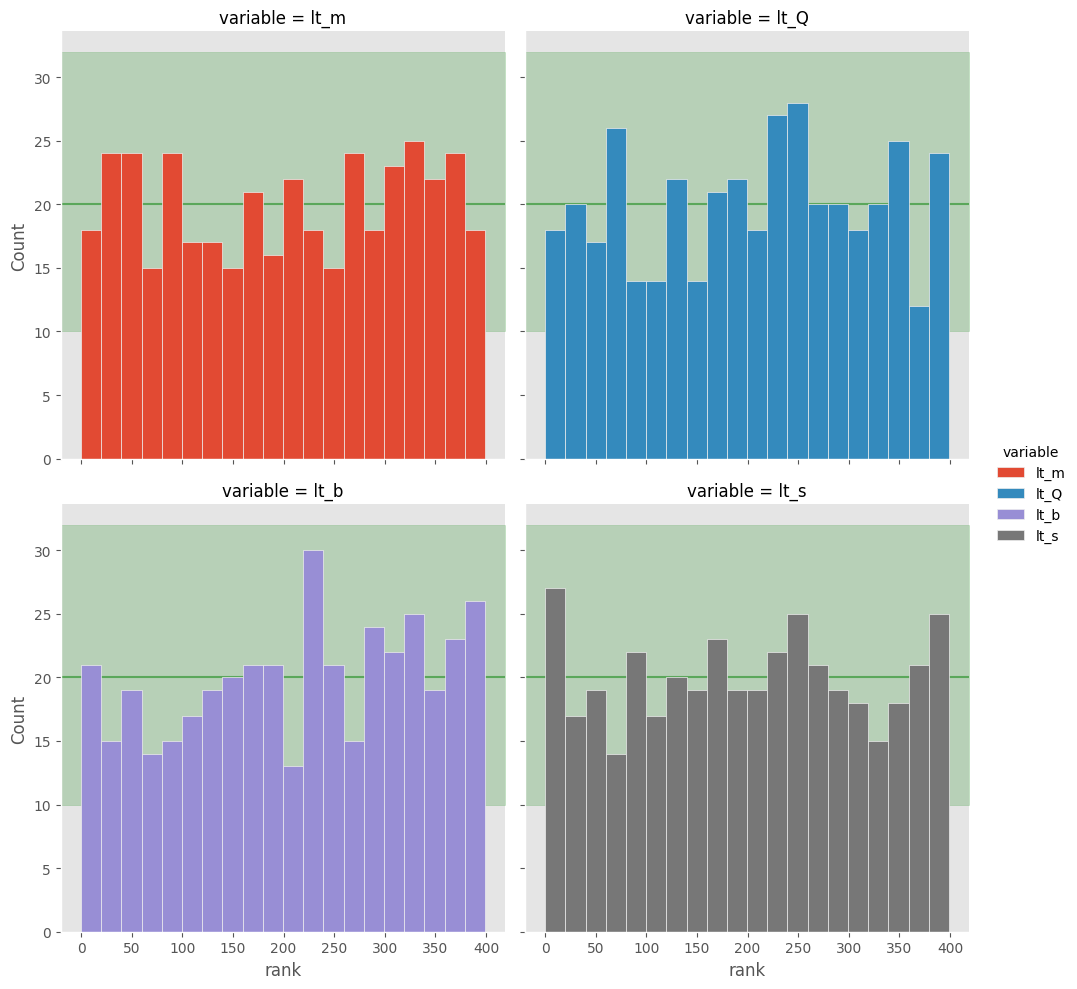

In [ ]:
fig = SBC_plot('sbc_sigma_400', 20)